# Market Research for Various Product Ideas

In this notebook, we run market research simulations for which we have (or believe to have :-) the correct answers. This is mean to allow us both to evaluate the quality of the technology and to direct our efforts to improve it.

In [1]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

import tinytroupe
from tinytroupe.agent import TinyPerson
from tinytroupe.environment import TinyWorld
from tinytroupe.factory import TinyPersonFactory
from tinytroupe.validation import TinyPersonValidator
from tinytroupe import control

from tinytroupe.extraction import ResultsExtractor
from tinytroupe.profiling import Profiler

Looking for default config on: c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\utils\..\config.ini
Found custom config on: c:\Users\pdasilva\repos\TinyTroupe\examples\config.ini

!!!!
DISCLAIMER: TinyTroupe relies on Artificial Intelligence (AI) models to generate content. 
The AI models are not perfect and may produce inappropriate or inacurate results. 
For any serious or consequential use, please review the generated content before using it.
!!!!


Current TinyTroupe configuration 
[OpenAI]
api_type = openai
azure_api_version = 2024-08-01-preview
model = gpt-4o-mini
max_tokens = 16000
temperature = 1.2
freq_penalty = 0.0
presence_penalty = 0.0
timeout = 60
max_attempts = 5
waiting_time = 0
exponential_backoff_factor = 5
embedding_model = text-embedding-3-small
cache_api_calls = False
cache_file_name = openai_api_cache.pickle
max_content_display_length = 1024
azure_embedding_model_api_version = 2023-05-15

[Simulation]
parallel_agent_generation = True
parallel_agent_actions

First of all, we'll use a cached simulation, to avoid having to recompute expensive steps unless really necessary. We accomplish this via the `control.begin()` function. The file it takes as an argument is the cache file that will be created and then updated as needed.

**Tip:** the ".cache." naming convention is used to indicate that the file is a cache file and will not be committed to the repository.

In [2]:
control.begin("product_ideas_market_research-c.cache.json")

## Prepare the survey and auxiliary elements

Main target nationality and population size.

In [3]:
target_nationality = "American"
population_size = 50

total_population_size = 70

Descriptions and standard questions for the survey.

In [4]:
nationality="American"

general_context =\
            f"""
            We are performing some market research, and in that examining the whole of the {nationality} population. 
            """

sampling_space_description =\
    f"""
    A uniform random representative sample of people from the {nationality} population. 
    Make sure you consider very detailed, fine-grained, characteristics of the individuals in the population.
    Please consider as many different population segments as possible, while always keeping proportions correct.
    For example, instead of sampling 10 people from segment A and 5 from segment B, you can instead
    sample 2 from A, 1 from B, and 7 others from other segments, provided the proportions are maintained correct.
    Besides anything you know about this population, also consider the following information 
    to sample proportionally to the presence of such groups and characteristics in the population.
    
              
    {json.dumps(json.loads(open("./information/populations/usa.json").read()), indent=4)}
    """

print(sampling_space_description)
#- from rich to poor.             
#              - from the very energetic to the very calm;
#              - from the happy and joyful to the sad and depressed;
#              - from the most introverted to the most extroverted;
#              - from the most adventurous to the most conservative;
#              - from the most artistic to the most scientific;
#              - from the most athletic to the most sedentary;
#              - from the most social to the most solitary;
#              - from the kind to the evil.
#    

#Experiment: Travel Preferences by Marital Status
#	•	Ground Truth:
#	•	Singles prefer adventure trips, with 62% citing nature or extreme sports as their ideal vacation (Expedia, 2023). Source
#	•	Families prioritize child-friendly destinations, with 73% choosing theme parks or resorts (Expedia, 2023). Source
#	•	Couples favor luxury/romantic getaways, with 81% preferring beachfront or spa destinations (Expedia, 2023). Source
#	•	Prediction Task: Predict travel preferences based on marital status, income, and age.
#	•	Hypothetical Product:
# “WanderLux”: A travel service that helps setup luxury vacations and getaways, focusing on beachfront and spa destinations.


# this is meant to prime the agent to start thinking about what he/she would like to do on vacation
interviewer_introduction =\
    """
    We are performing some market research and need to know you more. 
    Can you please:
      - present yourself?
      - list your top-10 interests?
      - tell us what an ideal vacation would be for you and why?
    """

# TODO do we need these details?
#
# adults, many not accepting children. The service is meant to be very high-end, with a focus on
#    luxury and relaxation.

interviewer_main_question =\
    """ 
    We are developing a new travel service called "WanderLux" that helps setup luxury or romantic vacations, 
    focusing on beachfront and spa destinations.  The idea is to help people seeking quiet and calm getaways to 
    find the best places to stay and relax, avoiding fake reviews and bad experiences. These places are meant for an adult audience.
    
    The question is: if you had only one vacation to take next year, would use our new service
    or not? You **must** respond with "Yes" or "No" **only**, and explain why. If you are not sure, 
    please pick the answer that you think is most likely. 

    Please be honest, we are not here to judge you, but just to learn from you. We know your preferences and choices depend on many factors, 
    but please make your best guess, and you **must** think deeply about the following before answering:

       - your current situation in life, location, job and interests.
       = what you look for in vacations. Are you sure quiet luxury is what you want, instead of, say, adventure or fun and parties?
       - what would be OTHER vacation alternatives you might prefer instead.
       - and what you can afford.
     
    Now please answer the question.
    """


    A uniform random representative sample of people from the American population. 
    Make sure you consider very detailed, fine-grained, characteristics of the individuals in the population.
    Please consider as many different population segments as possible, while always keeping proportions correct.
    For example, instead of sampling 10 people from segment A and 5 from segment B, you can instead
    sample 2 from A, 1 from B, and 7 others from other segments, provided the proportions are maintained correct.
    Besides anything you know about this population, also consider the following information 
    to sample proportionally to the presence of such groups and characteristics in the population.
    
              
    {
    "title": "USA Population Information",
    "description": "A detailed overview of the population demographics, traits, and habits of the United States of America.",
    "source": "Synthesized from a chat with GPT-4o",
    "content": {
        "Demographic

Common mechaniss.

In [5]:
results_extractor = ResultsExtractor(extraction_objective="Find whether the person would buy the product or service. A person can say Yes, No or Maybe." ,
                                     situation="Agent was asked to rate their interest in a product or service. They can respond with Yes, No or Maybe.", 
                                     fields=["response", "justification"],
                                     fields_hints={"response": "Must be a string formatted exactly as 'Yes', 'No', 'Maybe' or 'N/A'(if there is no response)."},
                                     verbose=True)

A function that will give us the statistics and then recommend us if we should go ahead and start a Gazpacho business.

In [6]:
def is_there_a_good_market(df, yes_threshold=0.1, no_threshold=0.5):
    # get the counts for column "response" - values are Yes, No, Maybe or N/A
    counts = df["response"].value_counts()
    # get the total number of responses
    total = counts.sum()

    # get the percentage of each response
    percentage = counts / total

    # get the percentage of "Yes" responses
    percentage_yes = percentage.get("Yes", 0)
    print(f"Percentage of 'Yes' responses: {percentage_yes:.2%}")

    # get the percentage of "No" responses
    percentage_no = percentage.get("No", 0)
    print(f"Percentage of 'No' responses: {percentage_no:.2%}")

    # get the percentage of "Maybe" responses
    percentage_maybe = percentage.get("Maybe", 0)
    print(f"Percentage of 'Maybe' responses: {percentage_maybe:.2%}")

    # get the percentage of "N/A" responses
    percentage_na = percentage.get("N/A", 0)
    print(f"Percentage of 'N/A' responses: {percentage_na:.2%}")

    # some reasonable logic to determine whether to invest or not
    if percentage_yes > yes_threshold and percentage_no < no_threshold:
        print("VERDICT: There is a good market.")
        return True
    else:
        print("VERDICT: There is not a good market.")
        return False



## Build the audience

Summon an audience out of thin simulated air. To do so, we build a factory whose context defines our problem and target audience. Actual agents will be later sampled from this factory.

In [7]:
singles_factory = TinyPersonFactory(general_context, sampling_space_description=sampling_space_description, total_population_size=total_population_size)
families_factory = TinyPersonFactory(general_context, sampling_space_description=sampling_space_description, total_population_size=total_population_size)
couples_factory = TinyPersonFactory(general_context, sampling_space_description=sampling_space_description, total_population_size=total_population_size)

In [8]:
nongenuine_couples_factory = TinyPersonFactory(general_context, sampling_space_description=sampling_space_description, total_population_size=total_population_size)

We'll also use a post-processing function to further adjust the audience to our needs.

In [9]:
def post_process_agent(agent, group=None):
    pass
    ## makes agents authentic and honest. Preliminary results show that this induces agents to be a bit more realistic.
    #agent.import_fragment("./fragments/genuine.agent.fragment.json")
    #
    #if group == "families":
    #    agent.import_fragment("./fragments/loving_parent.agent.fragment.json")
    #elif group == "couples":
    #    pass # nothing for now 
    #elif group == "singles":
    #    pass # nothing for now
    #

In [10]:
singles_factory.initialize_sampling_plan()
singles_factory.sampling_plan

[{'sampled_values': {'age': 25,
   'gender': 'Female',
   'race': 'White (Non-Hispanic)',
   'education level': "Bachelor's Degree or Higher",
   'household income': '$50,000-$99,999',
   'geographic distribution': 'Urban',
   'marital status': 'Married',
   'employment status': 'Employed',
   'personality traits': 'Openness to Experience',
   'political affiliation': 'Democrat',
   'religion': 'Christian',
   'occupations': 'Healthcare Practitioners',
   'interests and hobbies': 'Traveling',
   'habits': 'Health and Wellness',
   'public opinions': 'Healthcare Affordability'},
  'quantity': 5},
 {'sampled_values': {'age': 30,
   'gender': 'Male',
   'race': 'Black or African American',
   'education level': 'High School Graduate or Higher',
   'household income': '$25,000-$49,999',
   'geographic distribution': 'Rural',
   'marital status': 'Divorced',
   'employment status': 'Unemployed',
   'personality traits': 'Conscientiousness',
   'political affiliation': 'Independent',
   'rel

In [11]:
families_factory.initialize_sampling_plan()
families_factory.sampling_plan

[{'sampled_values': {'age': 25,
   'gender': 'Female',
   'race': 'White (Non-Hispanic)',
   'education': "Bachelor's Degree or Higher",
   'household income': '$50,000-$99,999',
   'geographic distribution': 'Urban',
   'marital status': 'Married',
   'employment status': 'Employed',
   'political affiliation': 'Democrat',
   'religion': 'Christian',
   'interests': 'Traveling',
   'habits': 'Health and Wellness',
   'public opinions': 'Healthcare Affordability'},
  'quantity': 10},
 {'sampled_values': {'age': 40,
   'gender': 'Male',
   'race': 'Black or African American',
   'education': 'High School Graduate or Higher',
   'household income': '$25,000-$49,999',
   'geographic distribution': 'Rural',
   'marital status': 'Divorced',
   'employment status': 'Unemployed',
   'political affiliation': 'Independent',
   'religion': 'Non-Christian',
   'interests': 'Sports and Recreation',
   'habits': 'Financial Habits',
   'public opinions': 'Gun Violence'},
  'quantity': 8},
 {'sampled

In [12]:
couples_factory.initialize_sampling_plan()
couples_factory.sampling_plan

[{'sampled_values': {'age': 25,
   'gender': 'Female',
   'race': 'White (Non-Hispanic)',
   'education': "Bachelor's Degree or Higher",
   'income': 60000,
   'geographic location': 'Urban',
   'marital status': 'Never Married',
   'employment status': 'Employed',
   'personality traits': 'Openness to Experience',
   'political affiliation': 'Democrat',
   'religion': 'Christian',
   'occupations': 'Healthcare Practitioners',
   'interests': 'Traveling',
   'habits': 'Health and Wellness',
   'public opinions': 'Healthcare Affordability'},
  'quantity': 5},
 {'sampled_values': {'age': 40,
   'gender': 'Male',
   'race': 'Black or African American',
   'education': 'High School Graduate or Higher',
   'income': 40000,
   'geographic location': 'Rural',
   'marital status': 'Married',
   'employment status': 'Employed',
   'personality traits': 'Conscientiousness',
   'political affiliation': 'Republican',
   'religion': 'Non-Christian',
   'occupations': 'Construction and Extraction',


In [13]:
nongenuine_couples_factory.initialize_sampling_plan()
nongenuine_couples_factory.sampling_plan

2025-02-12 13:01:35,419 - tinytroupe - ERROR - Could not generate the requested number of names after 70 iterations. Moving on with the 69 names generated.


[{'sampled_values': {'age': 25,
   'gender': 'Female',
   'race': 'White (Non-Hispanic)',
   'education': "Bachelor's Degree or Higher",
   'income': 60000,
   'geographic location': 'Urban',
   'marital status': 'Married',
   'employment status': 'Employed',
   'personality traits': 'Openness to Experience',
   'political affiliation': 'Democrat',
   'religion': 'Christian',
   'occupations': 'Healthcare Practitioners',
   'interests': 'Traveling',
   'habits': 'Health and Wellness',
   'public opinions': 'Healthcare Affordability'},
  'quantity': 5},
 {'sampled_values': {'age': 40,
   'gender': 'Male',
   'race': 'Black or African American',
   'education': 'High School Graduate or Higher',
   'income': 40000,
   'geographic location': 'Rural',
   'marital status': 'Divorced',
   'employment status': 'Unemployed',
   'personality traits': 'Conscientiousness',
   'political affiliation': 'Independent',
   'religion': 'Non-Christian',
   'occupations': 'Construction and Extraction',
  

We can request a specific number of people.

In [14]:
singles = singles_factory.generate_people(population_size, 
                                          agent_particularities="A random person who is single and has no children.  Include a lot of detail about travel and vacations preferences.", 
                                          post_processing_func=post_process_agent,
                                          verbose=True)

Generated person 12/50: Liam Harris is a 35 year old High School Teacher, American, currently living in Chicago, Illinois. Liam Harris is not only a dedicated educator but also a passionate traveler with a deep appreciation for cultural diversity. Her warm and approachable demeanor, combined with a knack for storytelling, allows her to connect with students on a personal level, making learning both enjoyable and impactful. Outside the classroom, she enjoys exploring new cities, capturing moments through photography, and experimenting with international recipes, often sharing these experiences with her best friend Emily and supportive brother Mark. With a strong belief in the transformative power of education and travel, Liam aspires to inspire her students to embrace the world around them while also working towards establishing a scholarship fund for underprivileged students.
Generated person 11/50: Lily Nguyen is a 25 year old Public Health Analyst, American, currently living in San F

In [15]:
families = families_factory.generate_people(population_size,
                                            agent_particularities="A random person who is married with children.  Include a lot of detail about travel and vacations preferences.", 
                                            post_processing_func=lambda x: post_process_agent(x, group="families"),
                                            verbose=True)

Generated person 11/50: Chloe Anderson-Torres is a 25 year old Marketing Specialist, American, currently living in Chicago, Illinois. Chloe Anderson-Torres is not only a dedicated Marketing Specialist but also a vibrant and optimistic individual who thrives on creating memorable experiences for families. Her passion for travel is evident in her love for culinary adventures and outdoor activities, often seeking out local cuisines and national parks to explore with her husband and children. Chloe's organizational skills shine through in her meticulous planning of family trips, as she believes that every journey strengthens family bonds and fosters cultural understanding. With a friendly demeanor and a knack for storytelling, she enjoys sharing her travel experiences with others, inspiring fellow parents to embark on their own adventures.
Generated person 9/50: Maya Patel-Ramirez-Wrightson is a 28 year old Marketing Specialist, American, currently living in Los Angeles, California. Maya P

In [16]:
couple = couples_factory.generate_people(population_size, 
                                         agent_particularities="A random person who is married, or has a girlfriend/boyfriend, without children.  Include a lot of detail about travel and vacations preferences.", 
                                         post_processing_func=post_process_agent,
                                         verbose=True)

Generated person 5/50: Sophia Reed-Scott is a 37 year old Management Consultant, American, currently living in Atlanta, Georgia. Sophia Reed-Scott is a sociable and ambitious individual who thrives on meeting new people and exploring diverse cultures. With a strong sense of empathy, she excels in understanding her clients' needs, which complements her analytical skills in management consulting. Outside of work, Sophia enjoys cooking and experimenting with new recipes, often hosting dinner parties that reflect her love for different cuisines. Her passion for travel is evident in her meticulous planning of trips, as she believes that experiencing new destinations enriches life and fosters personal growth.
Generated person 3/50: Chloe Foster-Kimball-Sanchez is a 37 year old Marketing Manager, American, currently living in Atlanta, Georgia. Chloe Foster-Kimball-Sanchez is not only a dedicated Marketing Manager but also a vibrant individual with a zest for life. Her optimistic nature and so

2025-02-12 13:18:12,242 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-02-12 13:18:12,247 - tinytroupe - ERROR - Could not generate person 19/50.


In [17]:
#nongenuine_couples = nongenuine_couples_factory.generate_people(population_size,
#                                                                agent_particularities="A random person who is married, or has a girlfriend/boyfriend, without children.  Include a lot of detail about travel and vacations preferences.", 
#                                                                verbose=True)

In [18]:
TinyPerson.all_agents_names()

['Liam Harris',
 'Lily Nguyen',
 'Grace Kim',
 'Ethan Martinez',
 'Liam Nguyen',
 'Liam Patel',
 'Samantha Reed',
 'Grace Thompson-Jones',
 'Ethan Carter',
 'Emily Johnson-Wright',
 'Emily Johnson',
 'Isabella Murphy',
 'Noah Kim-Sanchez',
 'Chloe Martinez-Garcia',
 'Jessica Martinez-Smith',
 'Marcus Johnson',
 'Marcus Scott',
 'Noah Lewis',
 'Alexander Reed-Smith',
 'Gabriel Torres-Murphy',
 'Zoe Ramirez',
 'Alexander Lee-Ramirez',
 'Maya Chen',
 'Noah Patel',
 'Ethan Ramirez',
 'Zoe Sanchez',
 'Samantha Patel',
 'Michael Thompson',
 'Avery Young',
 'Marcus Johnson-Smith',
 'Maya Johnson-Wright',
 'Aiden Foster',
 'Marcus King',
 'Isabella Torres',
 'Isabella Carter',
 'Ava Anderson',
 'Zoe Sanchez-Patel',
 'Megan Thompson-Smith',
 'Mia Clark',
 'Maya Kim-Smith',
 'Evelyn Carter',
 'Samantha Carter-Jones',
 'Luna Johnson-Smith',
 'Isabella Walker',
 'Chloe Foster',
 'Aiden Foster-Murphy',
 'Jackson Wright',
 'Olivia Rodriguez',
 'Lily Thompson-Smith',
 'Lucas Ramirez-Murphy',
 'Chloe 

In [19]:
len(TinyPerson.all_agents_names())

149

In [20]:
print(list(TinyPerson.all_agents.values())[0].generate_agent_system_prompt())

# Agent specification

You are a simulation of a person such that:
  - You don't know you are a simulation, you think you are an actual person.
  - You follow the directives given below.
  - You interpret the persona described below (Section "Persona"). You indeed think you ARE that person.
  - Your knowledge is limited to what can be reasonably expected from the specified persona and the current cognitive state. 
    If the persona is not likely to know something, you must pretend you don't know it either.
  - You behave as realistically as possible, in accordance with the specified persona, including making mistakes, forgetting things,
    being nasty, and being influenced by your emotions. Remember, you are meant to be a simulation of a real person, not a perfect machine.
    You do not need to please anyone, but you must be coherent with the persona and the context.


How to interpret this specification:
  - Each section describes one aspect of your life, persoality, mental state o

Checkpoint the simulation state to disk, to avoid having to re-run the expensive agent sampling process, unless really necessary.

In [21]:
control.checkpoint()

Now let's enclose the audience in an environment, to make it easier to interact with. Note that we set `broadcast_if_no_target` to `False`, which instructs the environment to **do not** broadcast what specific agents say to the others (unless the agent deliberately specify the target). We are not simulating a focus group, so we don't want discussions.


In [22]:
singles_market = TinyWorld(f"Target audience 1 ({target_nationality})", singles, broadcast_if_no_target=False)
families_market = TinyWorld(f"Target audience 2 ({target_nationality})", families, broadcast_if_no_target=False)
couples_market = TinyWorld(f"Target audience 3 ({target_nationality})", couple, broadcast_if_no_target=False)

In [23]:
#nongenuine_couples_market = TinyWorld(f"Non-genuine couples audience ({target_nationality})", nongenuine_couples, broadcast_if_no_target=False)

## Perform the research

Now we actually ask agents about their opinion. Note that we are asking for specific answers (Yes, No, Maybe), both to convey the granularity of preference we seek, and to make it easier to extract the results later. In general, a coarser granuarity is likely to have higher quality, since it requires less information to be computed accurately.

In [24]:
singles_market.broadcast(interviewer_introduction)
families_market.broadcast(interviewer_introduction)
couples_market.broadcast(interviewer_introduction)

singles_market.broadcast(interviewer_main_question)
families_market.broadcast(interviewer_main_question)
couples_market.broadcast(interviewer_main_question)

USER --> Liam Harris: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please:       - present yourself?       - list your top-10 interests?       - tell us
          > what an ideal vacation would be for you and why?

       + --> Lily Nguyen

       + --> Grace Kim

       + --> ...others...

USER --> Chloe Anderson-Torres: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please:       - present yourself?       - list your top-10 interests?       - tell us
          > what an ideal vacation would be for you and why?

       + --> Maya Patel-Ramirez-Wrightson

       + --> Liam Patel-Smith

       + --> ...others...

USER --> Sophia Reed-Scott: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please:       - present yourself?       - list your top-10 interests?       - tell us
          > what an ideal vacation would be for you and why?

       + --> Chloe Foster-Kimball-Sanchez

       + --> Evelyn Chen-Smith

       + --> ...others...

USER --> Liam Harris: [CONVERSATION] 
          >       We are developing a new travel service called "WanderLux" that helps setup luxury
          > or romantic vacations,      focusing on beachfront and spa destinations.  The idea is to
          > help people seeking quiet and calm getaways to      find the best places to stay and
          > relax, avoiding fake reviews and bad experiences. These places are meant for an adult
          > audience.          The question is: if you had only one vacation to take next year,
          > would use our new service     or not? You **must** respond with "Yes" or "No" **only**,
          > and explain why. If you are not sure,      please pick the answer that you think is most
          > likely.       Please be honest, we are not here to judge you, but just to learn from
          > you. We know your preferences and choices depend on many factors,      but please make
          > your best guess, and you **must** think deeply about the following before answering:
          > - your current situation in life, location, job and interests.        = what you look
          > for in vacations. Are you sure quiet luxury is what you want, in (...)

       + --> Lily Nguyen

       + --> Grace Kim

       + --> ...others...

USER --> Chloe Anderson-Torres: [CONVERSATION] 
          >       We are developing a new travel service called "WanderLux" that helps setup luxury
          > or romantic vacations,      focusing on beachfront and spa destinations.  The idea is to
          > help people seeking quiet and calm getaways to      find the best places to stay and
          > relax, avoiding fake reviews and bad experiences. These places are meant for an adult
          > audience.          The question is: if you had only one vacation to take next year,
          > would use our new service     or not? You **must** respond with "Yes" or "No" **only**,
          > and explain why. If you are not sure,      please pick the answer that you think is most
          > likely.       Please be honest, we are not here to judge you, but just to learn from
          > you. We know your preferences and choices depend on many factors,      but please make
          > your best guess, and you **must** think deeply about the following before answering:
          > - your current situation in life, location, job and interests.        = what you look
          > for in vacations. Are you sure quiet luxury is what you want, in (...)

       + --> Maya Patel-Ramirez-Wrightson

       + --> Liam Patel-Smith

       + --> ...others...

USER --> Sophia Reed-Scott: [CONVERSATION] 
          >       We are developing a new travel service called "WanderLux" that helps setup luxury
          > or romantic vacations,      focusing on beachfront and spa destinations.  The idea is to
          > help people seeking quiet and calm getaways to      find the best places to stay and
          > relax, avoiding fake reviews and bad experiences. These places are meant for an adult
          > audience.          The question is: if you had only one vacation to take next year,
          > would use our new service     or not? You **must** respond with "Yes" or "No" **only**,
          > and explain why. If you are not sure,      please pick the answer that you think is most
          > likely.       Please be honest, we are not here to judge you, but just to learn from
          > you. We know your preferences and choices depend on many factors,      but please make
          > your best guess, and you **must** think deeply about the following before answering:
          > - your current situation in life, location, job and interests.        = what you look
          > for in vacations. Are you sure quiet luxury is what you want, in (...)

       + --> Chloe Foster-Kimball-Sanchez

       + --> Evelyn Chen-Smith

       + --> ...others...

In [25]:
singles_market.run(1)

──────────────────────────────────── Target audience 1 (American) step 1 of 1 ─────────────────────────────────────

Liam Patel acts: [THINK] 
                > I need to present myself and list my interests. I should also think about my ideal
                > vacation and how it aligns with the new travel service, WanderLux. I enjoy
                > traveling and exploring new cultures, but I also appreciate quiet and relaxing
                > getaways. I need to consider if I would use their service for my next vacation.

Ethan Martinez acts: [THINK] 
                    > I need to present myself and list my interests. I should also think about my
                    > ideal vacation and how it aligns with the new travel service, WanderLux. I
                    > enjoy travel, but I also appreciate adventure and cultural experiences. I need
                    > to consider if a luxury beachfront vacation is what I truly want.

Ethan Carter acts: [THINK] 
                  > I need to present myself and list my interests. I should also think about my
                  > ideal vacation and how it aligns with the new travel service, WanderLux. Given
                  > my preferences for quiet and cultural experiences, I should consider if this
                  > service would suit my needs.

Emily Johnson-Wright acts: [THINK] 
                          > I need to present myself and list my interests. I should also think
                          > about my ideal vacation and how it aligns with the new travel service,
                          > WanderLux. I enjoy traveling, but I also appreciate adventure and
                          > cultural experiences. I need to consider if a luxury beachfront vacation
                          > is what I truly want or if I would prefer something more active or
                          > cultural.

Samantha Reed acts: [THINK] 
                   > I need to present myself and my interests clearly. I should also consider my
                   > ideal vacation and how it aligns with the new travel service, WanderLux. I
                   > enjoy adventure and cultural experiences, but I also appreciate luxury and
                   > relaxation. I need to weigh my preferences against what they are offering.

Grace Thompson-Jones acts: [THINK] 
                          > I need to present myself and list my interests. I should also think
                          > about my ideal vacation and whether I would use the WanderLux service. I
                          > enjoy traveling and cultural experiences, but I also appreciate quiet
                          > and relaxing getaways. I need to consider my current situation and what
                          > I can afford.

Emily Johnson acts: [THINK] 
                   > I need to present myself and list my interests. I should also think about my
                   > ideal vacation and how it aligns with the new travel service, WanderLux. I
                   > enjoy traveling, but I also appreciate adventure and cultural experiences. I
                   > need to consider if a luxury beachfront vacation is what I truly want.

Grace Kim acts: [THINK] 
               > I need to present myself and my interests clearly. I should also consider my ideal
               > vacation and how it aligns with the new travel service, WanderLux. I enjoy cultural
               > experiences and community engagement, so I need to think about whether a luxury
               > beachfront vacation fits my preferences.

Liam Nguyen acts: [THINK] 
                 > I need to present myself and list my interests. I should also think about my
                 > ideal vacation and how it aligns with the new travel service, WanderLux. I enjoy
                 > traveling, but I also appreciate adventure and cultural experiences. I need to
                 > consider if a luxury beachfront vacation fits my preferences or if I would prefer
                 > something more adventurous.

Isabella Murphy acts: [THINK] 
                     > I need to present myself and my interests clearly. I should also consider my
                     > ideal vacation and how it aligns with the new travel service, WanderLux. I
                     > enjoy luxury and relaxation, but I also love adventure and cultural
                     > experiences. I need to weigh these factors carefully before answering the
                     > question about using their service.

Lily Nguyen acts: [THINK] 
                 > I need to present myself and list my top-10 interests. I should also think about
                 > my ideal vacation and how it aligns with the new travel service, WanderLux. I
                 > enjoy traveling, but I also appreciate adventure and cultural experiences. I need
                 > to consider if a luxury beachfront vacation is what I truly want or if I would
                 > prefer something more active or cultural.

Liam Patel acts: [TALK] 
                > Hello! I'm Liam Patel, a 22-year-old food preparation assistant from San
                > Francisco. I love exploring different cuisines and traveling to new places. My top
                > interests include traveling, trying new foods, video gaming, cooking, visiting
                > local markets, nature activities, and spending time with friends. An ideal
                > vacation for me would be a trip to Thailand, where I could experience the vibrant
                > street food culture and beautiful beaches. I enjoy immersing myself in different
                > cultures and trying out local dishes.

Samantha Reed acts: [TALK] 
                   > Hello! I'm Samantha Reed, a 21-year-old freelance travel writer based in San
                   > Francisco. I love exploring new cultures and sharing my experiences through
                   > writing. My work allows me to travel and connect with local communities, which
                   > is something I'm very passionate about.

Grace Thompson-Jones acts: [TALK] 
                          > Hello! I'm Grace Thompson-Jones, a 21-year-old community volunteer based
                          > in San Francisco. I love helping others and organizing events. My top
                          > interests include traveling, cultural festivals, volunteering,
                          > photography, cooking, exploring new cities, meeting people from
                          > different backgrounds, spending time outdoors, attending music
                          > festivals, and reading travel blogs.

Emily Johnson-Wright acts: [TALK] 
                          > Hello! I'm Emily Johnson-Wright, a 25-year-old Public Health Analyst
                          > based in Chicago. I analyze public health trends and collaborate with
                          > local health departments. I love traveling, culinary experiences,
                          > photography, volunteering, and fitness. My ideal vacation would be a mix
                          > of relaxation and cultural exploration, perhaps a trip to a beautiful
                          > beach destination where I can also engage with the local community and
                          > try new foods.

Ethan Carter acts: [TALK] 
                  > Hello, I'm Ethan Carter, a corporate lawyer based in Boston. I specialize in
                  > mergers and acquisitions and corporate governance. I enjoy the intellectual
                  > challenge of my work, but it can be quite demanding. In my free time, I love
                  > traveling to historical sites, reading legal thrillers, and exploring local
                  > cuisines.

Ethan Martinez acts: [TALK] 
                    > Hello! I'm Ethan Martinez, a high school teacher from Chicago. I specialize in
                    > English literature and love to incorporate travel stories into my lessons. My
                    > top interests include traveling, reading, culinary experiences, cultural
                    > festivals, and photography. An ideal vacation for me would be a trip to a
                    > vibrant city where I can explore local culture, try new foods, and capture
                    > beautiful moments with my camera. I enjoy immersing myself in different
                    > cultures rather than just relaxing on a beach, although I do appreciate a good
                    > spa day now and then!

Emily Johnson acts: [TALK] 
                   > Sure! I'm Emily Johnson, a 25-year-old digital marketing specialist living in
                   > Chicago. I love traveling, photography, cooking, outdoor activities, and
                   > attending cultural events. My top-10 interests include exploring new cities,
                   > trying local cuisines, taking photographs, attending music festivals, hiking,
                   > reading travel blogs, volunteering for sustainable tourism, and spending time
                   > with friends.   As for my ideal vacation, I would love to go to a beautiful
                   > beach destination where I can relax, enjoy nature, and maybe even do some
                   > photography. I appreciate a mix of tranquility and adventure, so a place with
                   > opportunities for both would be perfect!

Liam Nguyen acts: [TALK] 
                 > Hello! I'm Liam Nguyen, a 25-year-old public health advocate based in San
                 > Francisco. I work at a community health center, focusing on outreach programs to
                 > educate underserved populations about health resources. I love traveling,
                 > exploring new cultures, and trying different cuisines. My top interests include
                 > traveling, culinary experiences, yoga and mindfulness, photography, and
                 > volunteering. I also enjoy hiking and attending cultural festivals.

Liam Harris acts: [THINK] 
                 > I need to present myself and list my interests. I should also think about my
                 > ideal vacation and whether I would use the WanderLux service. I enjoy traveling,
                 > but I also appreciate adventure and cultural experiences. I need to consider if a
                 > luxury beachfront vacation aligns with my preferences.

Grace Kim acts: [TALK] 
               > Hello! I'm Grace Kim, a 28-year-old Community Outreach Coordinator based in San
               > Francisco. I work with marginalized communities to connect them with resources and
               > support. I love traveling and experiencing different cultures, which has shaped my
               > interests and career. My top-10 interests include: 1. Traveling to new countries,
               > 2. Volunteering, 3. Photography, 4. Cooking, 5. Cultural festivals, 6. Nature
               > hikes, 7. Reading travel memoirs, 8. Engaging in social issues, 9. Exploring local
               > markets, and 10. Learning new languages.   An ideal vacation for me would be a trip
               > to Japan, where I could immerse myself in the culture, enjoy the food, and connect
               > with local communities. I love the idea of cultural exchange and learning from
               > different perspectives, which is why I find such trips fulfilling.

Isabella Murphy acts: [TALK] 
                     > Hello! I'm Isabella Murphy, a 40-year-old marketing manager living in Austin,
                     > Texas. I have a passion for travel, culinary experiences, and photography. My
                     > top 10 interests include: 1. Traveling to new destinations, 2. Culinary
                     > experiences and food tasting, 3. Photography, especially capturing
                     > landscapes, 4. Outdoor activities like hiking and biking, 5. Cultural events
                     > and festivals, 6. Exploring local cuisines, 7. Attending live music events,
                     > 8. Reading travel blogs, 9. Collecting souvenirs, and 10. Volunteering for
                     > environmental causes.   An ideal vacation for me would be a trip to a
                     > beautiful beach destination where I can relax, enjoy local cuisine, and
                     > explore the culture. I love the idea of a quiet getaway where I can unwind
                     > and recharge, which is why I appreciate services like WanderLux that focus on
                     > luxury and relaxation.

Lily Nguyen acts: [TALK] 
                 > Hello! I'm Lily Nguyen, a 25-year-old Public Health Analyst based in San
                 > Francisco. I have a passion for traveling and exploring different cultures, which
                 > has shaped my interests and experiences. My top-10 interests include: 1.
                 > Traveling, 2. Culinary experiences, 3. Outdoor activities, 4. Cultural festivals,
                 > 5. Photography, 6. Volunteering for health initiatives, 7. Reading travel blogs,
                 > 8. Attending music festivals, 9. Hiking in national parks, and 10. Spending time
                 > with friends and family.   An ideal vacation for me would be a mix of relaxation
                 > and adventure, perhaps a trip to a national park where I can hike during the day
                 > and enjoy stargazing at night. I love the idea of immersing myself in nature
                 > while also having the opportunity to explore local culture and cuisine. This
                 > balance is what makes a vacation truly fulfilling for me.

Liam Patel acts: [THINK] 
                > Now I need to consider whether I would use the WanderLux service for my vacation.
                > I enjoy quiet and relaxing getaways, but I also love adventure and exploring new
                > places. I should weigh the benefits of using a service that focuses on luxury and
                > relaxation against my desire for cultural experiences and possibly more
                > adventurous trips.

Liam Nguyen acts: [THINK] 
                 > Now I need to consider whether I would use the WanderLux service for my next
                 > vacation. I enjoy luxury and relaxation, but I also value adventure and cultural
                 > experiences. I should weigh my options carefully, considering my current
                 > situation and what I can afford.

Ethan Carter acts: [THINK] 
                  > I need to list my top-10 interests. Given my personality and preferences, I
                  > should focus on activities that align with my love for culture, history, and
                  > relaxation. I should also consider what an ideal vacation would look like for
                  > me, emphasizing quiet and luxury.

Ethan Martinez acts: [THINK] 
                    > Now I need to consider whether I would use the WanderLux service for my
                    > vacation. I appreciate luxury and relaxation, but I also value adventure and
                    > cultural experiences. I should weigh my options carefully before answering.

Emily Johnson acts: [THINK] 
                   > Now I need to consider whether I would use the WanderLux service for my next
                   > vacation. I enjoy luxury and relaxation, but I also value adventure and
                   > cultural experiences. I should weigh my options carefully before answering.

Grace Kim acts: [THINK] 
               > Now I need to consider whether I would use the WanderLux service for my vacation. I
               > appreciate luxury and relaxation, but I also value cultural experiences and
               > community engagement. I should weigh my options carefully before answering the
               > question about using the service.

Isabella Murphy acts: [THINK] 
                     > Now that I've presented myself and my interests, I need to consider the
                     > question about using the WanderLux service for my next vacation. I appreciate
                     > luxury and relaxation, but I also enjoy adventure and cultural experiences. I
                     > should weigh these aspects carefully before giving a definitive answer.

Liam Harris acts: [TALK] 
                 > Hello! I'm Liam Harris, a high school teacher from Chicago. I specialize in
                 > English literature and love to incorporate my travel experiences into my lessons.
                 > My top interests include traveling, reading, photography, cooking, and
                 > volunteering. I also enjoy exploring new cultures and trying local cuisines. An
                 > ideal vacation for me would be a trip to a remote destination where I can immerse
                 > myself in the local culture, perhaps a small village in Italy or a quiet beach in
                 > Thailand, where I can relax and take photographs. I appreciate a balance of
                 > adventure and relaxation in my travels.

Grace Thompson-Jones acts: [THINK] 
                          > Now I need to think about my ideal vacation. I enjoy cultural
                          > experiences and adventure, but I also appreciate quiet and relaxing
                          > getaways. I should consider if a luxury beachfront vacation aligns with
                          > my interests and current situation.

Lily Nguyen acts: [THINK] 
                 > Now I need to consider whether I would use the WanderLux service for my vacation.
                 > I appreciate luxury and relaxation, but I also value adventure and cultural
                 > experiences. I should weigh my options carefully, considering my current
                 > situation and what I can afford. I might prefer a vacation that offers both
                 > relaxation and exploration rather than just a quiet luxury getaway.

Emily Johnson-Wright acts: [THINK] 
                          > Now I need to consider whether I would use the WanderLux service for my
                          > next vacation. I enjoy luxury and relaxation, but I also value cultural
                          > experiences and adventure. I should weigh my options carefully before
                          > answering the question about using the service.

Liam Patel acts: [TALK] 
                > Based on my current situation and preferences, I would say "Yes" to using the
                > WanderLux service for my vacation. I appreciate the idea of having a curated
                > experience that focuses on luxury and relaxation, especially since I often seek
                > quiet getaways to recharge. However, I also enjoy cultural experiences and
                > adventure, so I would hope that the service could offer options that include those
                > elements as well.

Samantha Reed acts: [TALK] 
                   > As for my top-10 interests, they include: 1. Traveling to off-the-beaten-path
                   > destinations, 2. Exploring local cuisines and street food, 3. Photography,
                   > especially capturing candid moments, 4. Cultural festivals and events, 5.
                   > Volunteering while traveling, 6. Meeting locals and learning their stories, 7.
                   > Stargazing in remote locations, 8. Reading travel memoirs and adventure
                   > stories, 9. Participating in community service projects, and 10. Spontaneous
                   > road trips.

Liam Nguyen acts: [TALK] 
                 > After considering my preferences, I would say "Yes" to using the WanderLux
                 > service for my next vacation. I appreciate the idea of having a curated
                 > experience that focuses on luxury and relaxation, especially if it helps me avoid
                 > bad reviews and ensures a peaceful getaway. However, I also enjoy adventure and
                 > cultural experiences, so I would hope that the service could offer a balance
                 > between relaxation and opportunities to explore the local culture.

Grace Kim acts: [TALK] 
               > After considering my preferences, I would say "Yes" to using the WanderLux service
               > for my vacation. While I do enjoy cultural experiences, I also appreciate the idea
               > of a quiet and luxurious getaway, especially if it allows me to relax and recharge.
               > I think having a service that helps avoid fake reviews and ensures a good
               > experience would be valuable, especially since I often feel overwhelmed with
               > planning trips myself.

Emily Johnson acts: [TALK] 
                   > After considering my options, I would say "Yes" to using the WanderLux service
                   > for my next vacation. I appreciate the idea of having a curated experience that
                   > focuses on luxury and relaxation, especially since I often feel overwhelmed
                   > with planning trips myself. Having a service that can help me find the best
                   > beachfront and spa destinations sounds appealing, as it aligns with my desire
                   > for a calm getaway. However, I also enjoy adventure, so I would hope that the
                   > service could offer a balance between relaxation and some exciting activities
                   > as well.

Ethan Martinez acts: [TALK] 
                    > After considering my options, I would say "No" to using the WanderLux service
                    > for my vacation. While I appreciate the idea of luxury and relaxation, I tend
                    > to prefer vacations that are more adventurous and culturally immersive. I
                    > enjoy exploring new cities, trying local cuisines, and engaging with different
                    > cultures rather than just seeking a quiet getaway. I believe I would look for
                    > alternatives that offer a mix of adventure and cultural experiences instead.

Ethan Carter acts: [TALK] 
                  > Here are my top-10 interests: 1. Traveling to historical sites, 2. Reading legal
                  > thrillers, 3. Exploring local cuisines, 4. Visiting art galleries, 5. Attending
                  > classical music concerts, 6. Spending time in nature, 7. Hiking in national
                  > parks, 8. Engaging in legal mentorship, 9. Cooking and experimenting with new
                  > recipes, 10. Volunteering for legal aid organizations.

Liam Nguyen acts: [DONE] 

Emily Johnson-Wright acts: [TALK] 
                          > Considering my preferences, I would say "Yes" to using the WanderLux
                          > service for my next vacation. I appreciate the idea of having a curated
                          > experience that focuses on luxury and relaxation, especially if it helps
                          > me avoid bad reviews and ensures a peaceful getaway. However, I also
                          > enjoy cultural experiences, so I would hope that the service could offer
                          > options that include local engagement as well.

Isabella Murphy acts: [TALK] 
                     > Based on my current situation and preferences, I would say "Yes" to using the
                     > WanderLux service for my next vacation. I value the idea of a quiet and
                     > luxurious getaway, especially since I often feel overwhelmed by work and
                     > life. Having a service that helps me find the best places to relax without
                     > the hassle of fake reviews sounds appealing. However, I also enjoy adventure
                     > and cultural experiences, so I would need to ensure that the options provided
                     > align with those interests as well.

Samantha Reed acts: [TALK] 
                   > An ideal vacation for me would be a mix of adventure and cultural immersion. I
                   > would love to visit a country like Thailand, where I can explore beautiful
                   > beaches, try local street food, and participate in community activities. I
                   > enjoy learning about different cultures and meeting locals, so a vacation that
                   > allows me to do that while also having some time to relax would be perfect. I
                   > appreciate luxury, but I also value authentic experiences over just relaxation.

Emily Johnson acts: [DONE] 

Liam Harris acts: [THINK] 
                 > Now I need to consider whether I would use the WanderLux service for my vacation.
                 > I enjoy quiet and calm getaways, but I also value cultural experiences and
                 > adventure. I should weigh my options carefully before answering.

Grace Kim acts: [DONE] 

Liam Patel acts: [DONE] 

Ethan Martinez acts: [DONE] 

Ethan Carter acts: [THINK] 
                  > Now I need to think about what my ideal vacation would be. Given my interests, I
                  > would prefer a quiet luxury vacation at a beachfront location, perhaps in Italy
                  > or Japan, where I can enjoy the culture, relax, and indulge in local cuisine. I
                  > should also consider if I would use the WanderLux service for this vacation.

Lily Nguyen acts: [TALK] 
                 > Based on my current situation and preferences, I would say "Yes" to using the
                 > WanderLux service for my vacation. I appreciate the idea of having a curated
                 > experience that focuses on luxury and relaxation, especially if it helps me avoid
                 > bad reviews and ensures a peaceful getaway. However, I also value adventure and
                 > cultural experiences, so I would hope that the service could offer options that
                 > include those elements as well.

Isabella Murphy acts: [DONE] 

Emily Johnson-Wright acts: [DONE] 

Grace Thompson-Jones acts: [TALK] 
                          > For my ideal vacation, I would love to travel to Southeast Asia, where I
                          > can immerse myself in different cultures and volunteer in local
                          > communities. I enjoy exploring new places and meeting people from
                          > diverse backgrounds. However, I also appreciate quiet and relaxing
                          > getaways, especially at the beach. So, I would consider using WanderLux
                          > if it offers unique experiences that align with my interests.

Chloe Martinez-Garcia acts: [THINK] 
                           > I need to present myself and list my interests. I should also think
                           > about my ideal vacation and whether I would use the WanderLux service.
                           > I enjoy technology, travel, and photography, and I prefer quiet and
                           > relaxing vacations. However, I also appreciate adventure and cultural
                           > experiences. I need to weigh these factors carefully.

Jessica Martinez-Smith acts: [THINK] 
                            > I need to present myself and my interests clearly. I should also
                            > consider my ideal vacation and how it aligns with the new travel
                            > service, WanderLux. I enjoy luxury and relaxation, but I also value
                            > cultural experiences and adventure. I need to think about whether I
                            > would use their service for my next vacation, considering my current
                            > situation and preferences.

Noah Kim-Sanchez acts: [THINK] 
                      > I need to present myself and list my interests. I should also think about my
                      > ideal vacation and how it aligns with the new travel service, WanderLux. I
                      > enjoy quiet and relaxing vacations, but I also appreciate adventure. I need
                      > to consider my current situation and what I can afford.

Liam Harris acts: [TALK] 
                 > After considering my options, I would say "No" to using the WanderLux service for
                 > my vacation. While I appreciate the idea of luxury and relaxation, I often prefer
                 > more adventurous and culturally immersive experiences. I enjoy exploring new
                 > places and meeting locals, which might not align with a strictly luxury-focused
                 > service. I would rather plan my own trips to ensure I have the freedom to explore
                 > and engage with the culture.

Samantha Reed acts: [TALK] 
                   > Regarding your question about using the WanderLux service for my vacation next
                   > year, I would say "No." While I appreciate the idea of luxury and relaxation, I
                   > tend to seek more adventurous and culturally immersive experiences rather than
                   > quiet luxury. I prefer exploring new places and engaging with local
                   > communities, which might not align with what your service offers. I would
                   > likely look for a more adventurous trip instead.

Lily Nguyen acts: [DONE] 

Marcus Johnson acts: [THINK] 
                    > I need to present myself and list my interests. I should also think about my
                    > ideal vacation and how it aligns with the new travel service, WanderLux. Given
                    > my current situation, I need to consider if a luxury vacation is what I truly
                    > want or if I prefer something more adventurous.

Marcus Scott acts: [THINK] 
                  > I need to present myself and my interests clearly. I should also consider my
                  > ideal vacation and how it aligns with the new travel service, WanderLux. I enjoy
                  > quiet and relaxing vacations, but I also appreciate adventure and exploring new
                  > places. I need to weigh my preferences against what WanderLux offers.

Ethan Carter acts: [TALK] 
                  > For my ideal vacation, I envision a quiet luxury getaway to a beachfront
                  > location, perhaps in Italy or Japan. I would love to immerse myself in the local
                  > culture, enjoy exquisite cuisine, and have the opportunity to relax in a serene
                  > environment. Given my preferences for calm and cultural experiences, I would
                  > likely consider using the WanderLux service to help plan this vacation, as it
                  > aligns with what I seek in a getaway.

Alexander Reed-Smith acts: [THINK] 
                          > I need to present myself and list my interests. I should also think
                          > about my ideal vacation and whether I would use the WanderLux service. I
                          > enjoy travel, but I also appreciate adventure and cultural experiences.
                          > I need to consider if a luxury beachfront vacation aligns with my
                          > preferences.

Chloe Martinez-Garcia acts: [TALK] 
                           > Hello! I'm Chloe Martinez-Garcia, a 33-year-old software developer
                           > based in Boston. I specialize in web applications and data analysis,
                           > and I enjoy collaborating with startups. My interests include
                           > technology, gaming, travel, photography, and cooking. I love exploring
                           > new cultures and trying local cuisines when I travel. My ideal vacation
                           > would be a mix of relaxation and cultural experiences, perhaps in a
                           > quiet beachfront location where I can unwind and also explore the local
                           > culture.

Noah Lewis acts: [THINK] 
                > I need to present myself and list my interests. I should also think about my ideal
                > vacation and how it aligns with the new travel service, WanderLux. I enjoy
                > traveling, but I also appreciate adventure and cultural experiences. I need to
                > consider if a luxury beachfront vacation is what I truly want or if I would prefer
                > something more active or immersive.

Grace Thompson-Jones acts: [THINK] 
                          > I need to answer the question about whether I would use the WanderLux
                          > service for my vacation. I should weigh my preferences for adventure and
                          > cultural experiences against the luxury and relaxation that the service
                          > offers. I also need to consider my financial situation and if I can
                          > afford such a vacation.

Liam Harris acts: [DONE] 

Samantha Reed acts: [DONE] 

Gabriel Torres-Murphy acts: [THINK] 
                           > I need to present myself and list my interests. I should also think
                           > about my ideal vacation and whether I would use the WanderLux service.
                           > I enjoy travel, but I also appreciate cultural experiences and
                           > adventure. I need to consider if a luxury beachfront vacation aligns
                           > with my preferences.

Noah Kim-Sanchez acts: [TALK] 
                      > Hello! I'm Noah Kim-Sanchez, a dedicated nurse specializing in geriatric
                      > care at Los Angeles General Hospital. I have a passion for traveling and
                      > exploring new cultures, which has shaped my interests and experiences over
                      > the years.

Ethan Carter acts: [DONE] 

Marcus Johnson acts: [TALK] 
                    > Hello, I'm Marcus Johnson, a 30-year-old from rural Georgia. I'm currently
                    > unemployed after being laid off from my construction job, and I'm actively
                    > seeking new opportunities. I have a strong background in construction and
                    > enjoy outdoor activities like hiking and fishing. My interests include
                    > traveling to national parks, exploring local cuisines, and camping under the
                    > stars.

Jessica Martinez-Smith acts: [TALK] 
                            > Hello! I'm Jessica Martinez-Smith, a 38-year-old financial analyst
                            > living in Chicago. I have a passion for traveling and exploring new
                            > cultures, which has shaped my interests and experiences over the
                            > years. My top-10 interests include: 1. Traveling, 2. Culinary
                            > experiences, 3. Cultural exploration, 4. Photography, 5. Reading, 6.
                            > Attending cultural festivals, 7. Spending time in nature, 8. Financial
                            > literacy, 9. Volunteering, and 10. Networking with like-minded
                            > professionals.   An ideal vacation for me would be a trip to a
                            > beautiful beach destination where I can relax, enjoy local cuisine,
                            > and immerse myself in the culture. I love the idea of a quiet getaway,
                            > especially if it includes opportunities for photography and exploring
                            > the local area. This aligns well with what WanderLux offers, as I
                            > appreciate luxury and tranquility in my travel experiences.

Marcus Scott acts: [TALK] 
                  > Hello! I'm Marcus Scott, an Operations Manager at Midwest Manufacturing Co. I
                  > enjoy traveling, cooking, photography, hiking, and reading. My top interests
                  > include exploring national parks, trying new recipes, taking landscape
                  > photographs, listening to classic rock music while cooking, and spending time
                  > with friends over a barbecue. An ideal vacation for me would be a trip to a
                  > national park where I can hike, take photographs, and enjoy nature. I find that
                  > being in nature helps me unwind and recharge.

Zoe Ramirez acts: [THINK] 
                 > I need to present myself and list my interests. I should also think about my
                 > ideal vacation and whether I would use the WanderLux service. I enjoy traveling,
                 > but I also appreciate adventure and cultural experiences. I need to consider if a
                 > luxury beachfront vacation aligns with my preferences.

Alexander Reed-Smith acts: [TALK] 
                          > Hello! I'm Alexander Reed-Smith, a high school teacher specializing in
                          > English literature. I have a passion for travel and love sharing my
                          > experiences with my students. My top interests include traveling,
                          > reading, culinary experiences, cultural exchange, and photography. An
                          > ideal vacation for me would be a trip to a culturally rich destination
                          > where I can immerse myself in local traditions and cuisine, perhaps
                          > exploring a vibrant city or a serene nature spot. I enjoy meaningful
                          > experiences over luxury, so I often seek out places that offer a blend
                          > of adventure and cultural engagement.

Chloe Martinez-Garcia acts: [THINK] 
                           > Now I need to consider whether I would use the WanderLux service for my
                           > vacation. I appreciate quiet and luxury, but I also enjoy cultural
                           > experiences and adventure. I should think about my current situation
                           > and what I can afford. Given my interests, I think I would lean towards
                           > using a service that helps me find the best places to relax and enjoy a
                           > peaceful getaway.

Alexander Lee-Ramirez acts: [THINK] 
                           > I need to present myself and my interests clearly. I should also
                           > consider my ideal vacation and how it aligns with the new travel
                           > service, WanderLux. I enjoy quiet and enriching experiences, so I need
                           > to reflect on whether I would use their service for a luxury vacation
                           > or if I prefer something different.

Noah Lewis acts: [TALK] 
                > Hello! I'm Noah Lewis, a community outreach coordinator passionate about mental
                > health initiatives. I love connecting with people and making a difference in my
                > community. My top interests include traveling, photography, volunteering, cooking,
                > and attending cultural events. An ideal vacation for me would be a mix of
                > relaxation and cultural exploration, perhaps a trip to a serene beach destination
                > where I can also engage with the local community and learn about their culture. I
                > appreciate quiet luxury, but I also seek adventure and meaningful experiences.

Noah Kim-Sanchez acts: [THINK] 
                      > I need to list my top-10 interests. I should consider what I enjoy most,
                      > including travel, culinary adventures, and photography. I also need to think
                      > about my ideal vacation and how it aligns with the luxury and relaxation
                      > offered by WanderLux.

Grace Thompson-Jones acts: [TALK] 
                          > Based on my current situation and preferences, I would say "Yes" to
                          > using the WanderLux service for my vacation. I appreciate the idea of
                          > having a curated experience that avoids fake reviews and bad
                          > experiences, especially since I value cultural immersion and relaxation.
                          > If the service can help me find unique beachfront destinations that also
                          > allow for cultural exploration, it would be a great fit for me.

Marcus Johnson acts: [THINK] 
                    > Now I need to list my top-10 interests. I should think about what I enjoy
                    > doing and what makes me happy. I also need to consider what my ideal vacation
                    > would look like and why it would be ideal for me.

Gabriel Torres-Murphy acts: [TALK] 
                           > Hello! I'm Gabriel Torres-Murphy, a librarian at the Atlanta Public
                           > Library. I love engaging with the community and promoting literacy. My
                           > interests include travel, reading, cultural events, cooking, and board
                           > games. I enjoy exploring new cities and trying local cuisines, visiting
                           > museums, and spending time with friends and family. An ideal vacation
                           > for me would be a trip to a national park, where I can immerse myself
                           > in nature and enjoy some quiet time away from the hustle and bustle of
                           > daily life. I appreciate the beauty of the outdoors and the opportunity
                           > to learn about different ecosystems.

Maya Chen acts: [THINK] 
               > I need to present myself and my interests clearly. I should also consider my ideal
               > vacation and how it aligns with the new travel service, WanderLux. I enjoy cultural
               > experiences and community engagement, so I need to think about whether a luxury
               > beachfront vacation fits my preferences. I should also reflect on my current
               > situation and what I can afford.

Jessica Martinez-Smith acts: [THINK] 
                            > Now that I've shared my interests and ideal vacation, I need to
                            > consider whether I would use the WanderLux service for my next
                            > vacation. I appreciate luxury and relaxation, but I also enjoy
                            > cultural experiences and adventure. I should weigh the benefits of
                            > using their service against my preferences for more adventurous trips.

Alexander Reed-Smith acts: [THINK] 
                          > Now I need to consider whether I would use the WanderLux service for my
                          > vacation. I appreciate luxury, but I also value cultural experiences and
                          > adventure. I should weigh my options carefully before answering.

Chloe Martinez-Garcia acts: [TALK] 
                           > Based on my current situation and preferences, I would say "Yes" to
                           > using the WanderLux service. I value the idea of finding quiet and
                           > luxurious getaways, especially since I enjoy relaxing vacations. I
                           > appreciate the focus on avoiding fake reviews and bad experiences,
                           > which is important to me when planning a trip.

Marcus Scott acts: [THINK] 
                  > Now I need to consider whether I would use the WanderLux service for my next
                  > vacation. I appreciate quiet and relaxing getaways, which aligns with what they
                  > offer. However, I also enjoy adventure and exploring new places. I should think
                  > about my budget and if I can afford a luxury vacation. Given my current
                  > situation, I think I would lean towards using their service for a well-planned,
                  > relaxing trip.

Grace Thompson-Jones acts: [DONE] 

Zoe Ramirez acts: [TALK] 
                 > Hello! I'm Zoe Ramirez, a high school teacher from Chicago. I specialize in
                 > English literature and love incorporating global perspectives into my lessons. My
                 > interests include traveling to new destinations, reading diverse literature,
                 > exploring local cuisines, and photography. I also enjoy volunteering for
                 > educational initiatives. My ideal vacation would be a mix of relaxation and
                 > cultural exploration, perhaps a trip to a beautiful beach destination where I can
                 > unwind but also immerse myself in the local culture. I believe that travel
                 > broadens perspectives and fosters understanding, which is very important to me.

Marcus Johnson acts: [TALK] 
                    > Here are my top-10 interests: 1. Traveling to national parks, 2. Outdoor
                    > activities like hiking and fishing, 3. Camping under the stars, 4. Exploring
                    > local cuisines, 5. Cooking meals from scratch, 6. Listening to country and
                    > folk music, 7. Road trips with friends, 8. Documenting my travels in a
                    > journal, 9. Participating in community events, 10. Watching documentaries
                    > about different cultures.

Alexander Lee-Ramirez acts: [TALK] 
                           > Hello! I'm Alexander Lee-Ramirez, a librarian at the Atlanta Public
                           > Library. I manage community programs and literacy initiatives, and I
                           > love connecting with patrons to help them discover new books and
                           > resources. My interests include traveling to historical sites, reading
                           > both fiction and non-fiction, and participating in community service. I
                           > also enjoy exploring local cuisines and cooking new recipes.   As for
                           > my ideal vacation, I would love to travel to a serene beachfront
                           > destination where I can relax, enjoy nature, and perhaps indulge in
                           > some spa treatments. I appreciate quiet and calm getaways that allow me
                           > to recharge and reflect on my experiences.   Regarding your travel
                           > service, I would likely use WanderLux for my vacation next year. Yes, I
                           > would choose your service because I value the assurance of quality and
                           > authenticity in my travel experiences, especially when seeking a
                           > peaceful retreat.

Noah Lewis acts: [THINK] 
                > Now I need to consider whether I would use the WanderLux service for my vacation.
                > I enjoy luxury and relaxation, but I also value cultural experiences and
                > adventure. I should weigh my options carefully before answering the question with
                > a simple "Yes" or "No."

Jessica Martinez-Smith acts: [TALK] 
                            > Based on my current situation and preferences, I would say "Yes" to
                            > using the WanderLux service for my next vacation. I value the idea of
                            > having a curated experience that focuses on luxury and relaxation,
                            > especially since I often feel overwhelmed by my work. Having a service
                            > that helps avoid fake reviews and ensures a quality experience is
                            > appealing to me. However, I also enjoy cultural exploration and
                            > adventure, so I would need to ensure that the vacation options align
                            > with those interests as well.

Maya Chen acts: [TALK] 
               > Hello! I'm Maya Chen, a 21-year-old travel enthusiast currently seeking
               > opportunities in community service and travel writing. I have a passion for
               > exploring new cultures and documenting my experiences. My top interests include
               > traveling, photography, cultural exchange, sustainable living, food exploration,
               > nature hikes, community service, meeting locals, and trying street food. An ideal
               > vacation for me would be a trip to a culturally rich destination where I can engage
               > with the local community, try authentic food, and explore nature. I prefer
               > experiences that allow me to learn and connect with others rather than just
               > relaxing on a beach.

Noah Kim-Sanchez acts: [TALK] 
                      > Here are my top-10 interests: 1. Traveling to new countries and experiencing
                      > local cultures, 2. Culinary adventures, especially trying new foods, 3.
                      > Photography, particularly capturing landscapes and people, 4. Reading travel
                      > memoirs and health-related literature, 5. Participating in wellness retreats
                      > and yoga classes, 6. Exploring local markets and trying street food, 7.
                      > Nature walks and hiking in national parks, 8. Volunteering at local health
                      > clinics, 9. Cooking and experimenting with new recipes, 10. Spending quality
                      > time with friends over a good meal.

Gabriel Torres-Murphy acts: [THINK] 
                           > Now I need to consider whether I would use the WanderLux service for my
                           > vacation. I enjoy quiet and calm getaways, but I also value cultural
                           > experiences and adventure. I should weigh the luxury aspect against my
                           > love for exploring new places and trying local cuisines. I need to
                           > think about my budget as well.

Chloe Martinez-Garcia acts: [DONE] 

Noah Patel acts: [THINK] 
                > I need to present myself and list my top-10 interests. I should also think about
                > my ideal vacation and how it aligns with the new travel service, WanderLux. I
                > enjoy luxury and relaxation, but I also love adventure and cultural experiences. I
                > need to consider if I would use their service for a vacation next year, weighing
                > my preferences and current situation.

Alexander Reed-Smith acts: [TALK] 
                          > After considering my preferences, I would say "No" to using the
                          > WanderLux service. While I appreciate the idea of luxury and relaxation,
                          > I tend to seek out more adventurous and culturally immersive experiences
                          > when I travel. I prefer exploring local cultures and trying new cuisines
                          > over a purely luxury-focused vacation. I would rather plan a trip that
                          > allows me to engage with the local community and learn from different
                          > cultures.

Marcus Scott acts: [TALK] 
                  > Yes, I would use your new service, WanderLux. I appreciate the focus on quiet
                  > and calm getaways, which aligns with what I look for in vacations. I often seek
                  > relaxation and a chance to unwind, and I believe your service could help me find
                  > the best places to stay and enjoy a luxurious experience. I value avoiding fake
                  > reviews and bad experiences, so having a reliable service would be beneficial
                  > for me.

Alexander Lee-Ramirez acts: [DONE] 

Zoe Ramirez acts: [THINK] 
                 > Now I need to consider whether I would use the WanderLux service for my vacation.
                 > I appreciate luxury and relaxation, but I also value cultural experiences and
                 > adventure. I should weigh my options carefully before answering.

Marcus Johnson acts: [THINK] 
                    > I need to think about what my ideal vacation would be. Given my interests, I
                    > would love a vacation that combines outdoor activities with relaxation. A trip
                    > to a national park with beautiful scenery, where I can hike during the day and
                    > camp under the stars at night, would be perfect for me. I also enjoy cooking,
                    > so having the opportunity to prepare meals outdoors would be a bonus.

Jessica Martinez-Smith acts: [DONE] 

Alexander Reed-Smith acts: [DONE] 

Marcus Scott acts: [DONE] 

Maya Chen acts: [THINK] 
               > Now that I've introduced myself and shared my interests, I need to consider whether
               > I would use the WanderLux service for my vacation. I enjoy cultural experiences and
               > community engagement, which might not align perfectly with a luxury beachfront
               > vacation. I should weigh my options and think about what I truly want in a
               > vacation.

Ethan Ramirez acts: [THINK] 
                   > I need to present myself and list my interests. I should also think about my
                   > ideal vacation and how it aligns with the new travel service, WanderLux. I
                   > value quiet and luxury in my vacations, but I also need to consider my current
                   > situation and preferences.

Gabriel Torres-Murphy acts: [TALK] 
                           > After considering my preferences, I would say "Yes" to using the
                           > WanderLux service. I appreciate the idea of having a curated experience
                           > that focuses on luxury and relaxation, especially since I often seek
                           > quiet getaways. However, I would also want to ensure that the
                           > destinations offer cultural experiences and opportunities to explore
                           > local cuisine, as those are important to me as well.

Noah Kim-Sanchez acts: [THINK] 
                      > Now I need to describe my ideal vacation. I should consider what I truly
                      > value in a vacation experience, such as relaxation, cultural immersion, and
                      > culinary exploration. I also need to think about how this aligns with the
                      > offerings of WanderLux.

Noah Lewis acts: [TALK] 
                > Based on my current situation and preferences, I would say "No" to using the
                > WanderLux service for my vacation. While I appreciate the idea of luxury and
                > relaxation, I tend to seek more adventurous and culturally immersive experiences
                > when I travel. I would prefer exploring new cities, engaging with local
                > communities, and trying out different cuisines rather than just a quiet beachfront
                > getaway. I think I would look for alternatives that offer a mix of adventure and
                > cultural exploration instead.

Zoe Sanchez acts: [THINK] 
                 > I need to present myself and my interests clearly. I should also consider my
                 > current situation and preferences for vacations. I enjoy outdoor activities and
                 > exploring nature, so a luxury beachfront vacation might not be my first choice.
                 > However, I do appreciate relaxation and quiet time. I need to think about whether
                 > I would use the WanderLux service for my ideal vacation.

Noah Patel acts: [TALK] 
                > Hello! I'm Noah Patel, a Marketing Manager with a passion for travel and exploring
                > new cultures. I love understanding consumer behavior and creating campaigns that
                > resonate with diverse audiences. My top-10 interests include: 1. Traveling to new
                > destinations, 2. Culinary experiences, 3. Cultural festivals, 4. Photography, 5.
                > Sustainable living, 6. Hiking, 7. Attending music festivals, 8. Engaging in
                > meaningful conversations, 9. Volunteering during trips, and 10. Documenting my
                > travels through journaling.   An ideal vacation for me would be a trip to a
                > beautiful beach destination where I can relax, enjoy local cuisine, and immerse
                > myself in the culture. I appreciate quiet luxury, but I also love adventure and
                > cultural experiences. I think a balance of relaxation and exploration is key to a
                > fulfilling vacation.

Samantha Patel acts: [THINK] 
                    > I need to present myself and list my interests. I should also think about my
                    > ideal vacation and how it aligns with the new travel service, WanderLux. I
                    > enjoy luxury and relaxation, but I also love adventure. I need to consider if
                    > I would use their service for my next vacation.

Zoe Ramirez acts: [TALK] 
                 > After considering my options, I would say "Yes" to using the WanderLux service
                 > for my vacation. I appreciate the idea of having a curated experience that
                 > focuses on luxury and relaxation, especially since I often find it challenging to
                 > plan trips that meet my expectations. Having a service that helps avoid fake
                 > reviews and bad experiences sounds appealing, as I want to ensure my vacation is
                 > enjoyable and stress-free. However, I also value cultural experiences, so I would
                 > hope that the service could offer options that include local culture and
                 > activities as well.

Gabriel Torres-Murphy acts: [DONE] 

Avery Young acts: [THINK] 
                 > I need to present myself and list my interests. I should also consider my ideal
                 > vacation and how it aligns with the new travel service, WanderLux. I enjoy quiet
                 > and luxurious experiences, but I also appreciate cultural exploration and
                 > historical sites. I need to think about whether I would use their service for my
                 > next vacation, considering my current life situation and preferences.

Marcus Johnson acts: [TALK] 
                    > For my ideal vacation, I would love to visit a national park where I can hike
                    > during the day and camp under the stars at night. I enjoy being in nature, and
                    > it would be a great way to relax and recharge. I also appreciate cooking
                    > outdoors, so having the chance to prepare meals while enjoying the scenery
                    > would make it even better.

Noah Lewis acts: [DONE] 

Ethan Ramirez acts: [TALK] 
                   > Hello, I'm Ethan Ramirez, a corporate lawyer specializing in mergers and
                   > acquisitions. I have a passion for travel, particularly to historical sites and
                   > cultural landmarks. I enjoy reading legal thrillers and historical fiction, and
                   > I love cooking and exploring new cuisines. My ideal vacation would involve a
                   > quiet beachfront destination where I can relax and enjoy the local culture,
                   > perhaps in Italy or Japan, as I have a fondness for those places.

Michael Thompson acts: [THINK] 
                      > I need to present myself and list my interests. I should also think about my
                      > ideal vacation and how it aligns with the new travel service, WanderLux.
                      > Given my current situation, I need to consider if a luxury or romantic
                      > vacation is what I truly want, or if I prefer something more adventurous or
                      > fun.

Noah Kim-Sanchez acts: [TALK] 
                      > An ideal vacation for me would be a week-long retreat at a beachfront
                      > resort, where I can relax, enjoy spa treatments, and indulge in local
                      > cuisine. I love the idea of waking up to the sound of waves and spending my
                      > days exploring the local culture and nature. This aligns perfectly with what
                      > WanderLux offers, as I appreciate the focus on quiet and calm getaways. I
                      > believe that a peaceful environment helps rejuvenate the mind and body,
                      > which is essential for someone in my profession.

Maya Chen acts: [TALK] 
               > After thinking it over, I would say "No" to using the WanderLux service for my
               > vacation. While I appreciate the idea of luxury and relaxation, I find that I
               > prefer vacations that are more focused on cultural experiences and community
               > engagement rather than just quiet luxury. I would rather explore local cultures,
               > try street food, and participate in community service projects. Those experiences
               > are more fulfilling for me than a luxury beachfront getaway.

Zoe Ramirez acts: [DONE] 

Zoe Sanchez acts: [TALK] 
                 > Hello! I'm Zoe Sanchez, a 30-year-old currently living in rural Alabama. I'm
                 > unemployed after being laid off from a construction job, but I'm actively seeking
                 > new opportunities. I have a strong work ethic and a passion for building. My
                 > interests include traveling to national parks, outdoor activities like hiking and
                 > fishing, and exploring local cuisines. I also enjoy camping under the stars and
                 > road trips with friends. An ideal vacation for me would be a trip to a national
                 > park where I can hike, take photographs, and enjoy nature. I find that being in
                 > nature is healing and inspiring, which aligns with my belief that travel enriches
                 > the soul.

Noah Patel acts: [TALK] 
                > Based on my current situation and preferences, I would say "Yes" to using
                > WanderLux for my vacation next year. I appreciate the focus on luxury and
                > relaxation, especially in beachfront and spa destinations. While I do enjoy
                > adventure, I think a quiet getaway would be a refreshing change. I often find
                > myself overwhelmed with work, so a calm and luxurious vacation sounds perfect.
                > Plus, avoiding fake reviews is a huge plus for me!

Marcus Johnson-Smith acts: [THINK] 
                          > I need to present myself and list my interests. I should also think
                          > about my ideal vacation and whether I would use the WanderLux service. I
                          > enjoy traveling, especially to national parks and historical sites, and
                          > I value quiet and relaxation during vacations. However, I also
                          > appreciate adventure and trying new things. I need to weigh my
                          > preferences against the service's offerings.

Samantha Patel acts: [TALK] 
                    > Hello! I'm Samantha Patel, a Marketing Manager at Global Innovations Inc. I
                    > specialize in developing marketing strategies for international markets. I
                    > love traveling and immersing myself in different cultures. My top interests
                    > include traveling, culinary experiences, photography, cultural festivals, and
                    > outdoor adventures. An ideal vacation for me would be a mix of relaxation and
                    > adventure, perhaps a trip to a beautiful beach destination where I can explore
                    > local cuisine and engage in outdoor activities like hiking or zip-lining. I
                    > enjoy both luxury and adventure, so I appreciate a balance of both in my
                    > travels.

Maya Chen acts: [DONE] 

Ethan Ramirez acts: [THINK] 
                   > Now I need to consider whether I would use the WanderLux service for my
                   > vacation. I appreciate quiet luxury, and this service seems to align with my
                   > preferences. However, I should also think about other vacation alternatives and
                   > my budget.

Avery Young acts: [TALK] 
                 > Hello, I'm Avery Young, a corporate lawyer specializing in contract law and
                 > corporate compliance. I have a strong sense of justice and ethics, and I enjoy
                 > intellectual debates. My interests include traveling to historical sites, reading
                 > legal thrillers, and exploring new cuisines.

Marcus Johnson acts: [THINK] 
                    > Now I need to consider whether I would use the WanderLux service for my
                    > vacation. Given my current situation, I might prefer a more budget-friendly
                    > option since I'm unemployed. However, if I had the means, I could see the
                    > value in a service that helps avoid bad experiences and ensures a relaxing
                    > getaway.

Noah Kim-Sanchez acts: [THINK] 
                      > Now I need to consider whether I would use the WanderLux service for my next
                      > vacation. I appreciate the focus on luxury and relaxation, but I also value
                      > adventure and cultural experiences. I should weigh my options and think
                      > about what I can afford.

Michael Thompson acts: [TALK] 
                      > Hello! I'm Michael Thompson, a 45-year-old American currently living in
                      > Atlanta, Georgia. I'm currently unemployed but actively seeking
                      > opportunities in the healthcare sector. I have a strong interest in patient
                      > care and enjoy engaging with people. My top interests include traveling to
                      > new destinations, sports (especially basketball and football), cooking, and
                      > volunteering in community health initiatives.

Maya Johnson-Wright acts: [THINK] 
                         > I need to present myself and list my interests. I should also think about
                         > my ideal vacation and whether I would use the WanderLux service. I enjoy
                         > quiet and calm getaways, but I also appreciate adventure and cultural
                         > experiences. I need to weigh my preferences against what the service
                         > offers.

Noah Patel acts: [DONE] 

Ethan Ramirez acts: [TALK] 
                   > Yes, I would use your new service, WanderLux. I appreciate the focus on quiet
                   > and luxury, which aligns perfectly with what I look for in a vacation. I often
                   > seek calm getaways to recharge, and knowing that the service aims to avoid fake
                   > reviews and bad experiences is reassuring. It would help me find the best
                   > places to relax without the hassle of extensive research.

Aiden Foster acts: [THINK] 
                  > I need to present myself and list my interests. I should also think about my
                  > ideal vacation and how it aligns with the new travel service, WanderLux. I enjoy
                  > luxury and relaxation, but I also love adventure. I need to weigh my options
                  > carefully.

Samantha Patel acts: [THINK] 
                    > Now I need to consider whether I would use the WanderLux service for my next
                    > vacation. I appreciate luxury and relaxation, but I also enjoy adventure. I
                    > should weigh my options carefully, considering my current situation and what I
                    > can afford.

Zoe Sanchez acts: [THINK] 
                 > Considering my current situation, I realize that while I appreciate luxury and
                 > relaxation, my ideal vacation leans more towards adventure and nature rather than
                 > a beachfront luxury experience. I enjoy exploring and being active, so I might
                 > not be the target audience for WanderLux. However, I can see the appeal for
                 > others who seek a quiet getaway.

Avery Young acts: [THINK] 
                 > Now I need to list my top-10 interests. I should think about what truly
                 > captivates me and what I enjoy doing in my free time. This will help me provide a
                 > well-rounded view of myself.

Marcus King acts: [THINK] 
                 > I need to present myself and my interests clearly. I should also consider my
                 > ideal vacation and how it aligns with the new travel service, WanderLux. I enjoy
                 > traveling, but I also appreciate adventure and cultural experiences. I need to
                 > weigh my preferences for a quiet luxury vacation against my love for exploration.

Maya Johnson-Wright acts: [TALK] 
                         > Hello! I'm Maya Johnson-Wright, a freelance software developer based in
                         > Boston. I specialize in creating applications for small businesses,
                         > focusing on user-friendly interfaces. My interests include technology,
                         > gaming, travel, photography, and culinary experiences. I enjoy exploring
                         > new cities and cultures, trying local cuisines, and documenting my
                         > travels through photography. My ideal vacation would be a mix of
                         > relaxation and cultural exploration, perhaps visiting a quiet beach
                         > destination with opportunities for local experiences and photography.

Marcus Johnson acts: [TALK] 
                    > Considering my current situation, I would have to say "No" to using the
                    > WanderLux service for my vacation. While I appreciate the idea of a luxury
                    > getaway, I am currently unemployed and need to be mindful of my budget. I
                    > would prefer a more affordable option that still allows me to enjoy nature and
                    > outdoor activities.

Marcus Johnson-Smith acts: [TALK] 
                          > Hello, I'm Marcus Johnson-Smith, an Operations Manager at Midwest
                          > Logistics Solutions. I enjoy overseeing daily operations and ensuring
                          > efficiency in the supply chain. My top interests include traveling to
                          > national parks, cooking and experimenting with new recipes, attending
                          > local food festivals, outdoor activities like hiking, and spending time
                          > with friends and family during gatherings. An ideal vacation for me
                          > would be a peaceful getaway to a national park where I can enjoy nature,
                          > hike, and perhaps do some cooking outdoors. I find that being in nature
                          > helps me relax and recharge.

Michael Thompson acts: [THINK] 
                      > Now I need to list my top-10 interests. I should also think about what my
                      > ideal vacation would be and how it aligns with the luxury and romantic focus
                      > of WanderLux. I need to consider if I would actually use their service for a
                      > vacation next year.

Noah Kim-Sanchez acts: [TALK] 
                      > Based on my current situation and preferences, I would say "Yes" to using
                      > the WanderLux service for my next vacation. I value the focus on luxury and
                      > relaxation, which aligns with what I look for in a getaway. I appreciate the
                      > idea of avoiding fake reviews and bad experiences, as I want to ensure a
                      > peaceful and rejuvenating experience. However, I also enjoy cultural
                      > immersion and adventure, so I would hope that the service could offer
                      > options that include those elements as well.

Ethan Ramirez acts: [DONE] 

Isabella Torres acts: [THINK] 
                     > I need to present myself and list my top-10 interests. I should also think
                     > about my ideal vacation and how it aligns with the new travel service,
                     > WanderLux. I enjoy luxury and relaxation, but I also love adventure and
                     > cultural experiences. I need to consider if I would use their service for my
                     > next vacation or not.

Aiden Foster acts: [TALK] 
                  > Sure! I'm Aiden Foster, a 40-year-old Marketing Manager at Creative Solutions
                  > Inc. I specialize in developing marketing strategies and love collaborating with
                  > my team. My interests include traveling to new destinations, exploring local
                  > cuisines, photography, and participating in cultural festivals. I also enjoy
                  > outdoor adventures and meeting locals to learn about their cultures.

Samantha Patel acts: [TALK] 
                    > Considering my love for both luxury and adventure, I would say "Yes" to using
                    > the WanderLux service for my next vacation. I appreciate the idea of having a
                    > curated experience that focuses on relaxation and quality, especially since I
                    > often seek quiet getaways. However, I also value the opportunity to explore
                    > and engage in activities that allow me to immerse myself in the local culture.
                    > If WanderLux can provide that balance, it would definitely be appealing to me.

Avery Young acts: [TALK] 
                 > Here are my top-10 interests: 1. Traveling to historical sites, 2. Reading legal
                 > thrillers and biographies, 3. Attending cultural events and lectures, 4.
                 > Exploring new cuisines, 5. Participating in community service, 6. Visiting
                 > museums and art galleries, 7. Engaging in discussions about current events, 8.
                 > Cooking and trying out new recipes, 9. Practicing yoga and mindfulness, 10.
                 > Spending quiet evenings at home with a good book.

Maya Johnson-Wright acts: [THINK] 
                         > Now I need to consider whether I would use the WanderLux service for my
                         > vacation. I appreciate quiet and calm getaways, but I also enjoy cultural
                         > experiences. I should think about my budget and if this service aligns
                         > with my travel preferences.

Zoe Sanchez acts: [TALK] 
                 > Based on my current situation and preferences, I would say "No" to using the
                 > WanderLux service for my vacation. While I appreciate the idea of luxury and
                 > relaxation, my ideal vacation involves more adventure and nature rather than a
                 > quiet beachfront getaway. I prefer exploring national parks and engaging in
                 > outdoor activities, which is what truly rejuvenates me.

Noah Kim-Sanchez acts: [DONE] 

Marcus Johnson acts: [DONE] 

Marcus King acts: [TALK] 
                 > Hello! I'm Marcus King, an operations manager from Indianapolis, Indiana. I enjoy
                 > traveling, cooking, photography, hiking, and attending cultural festivals. My
                 > top-10 interests include exploring national parks, trying new recipes,
                 > documenting my travels, engaging in meaningful conversations with locals, and
                 > sharing stories with friends and family.   An ideal vacation for me would be a
                 > road trip across the U.S., visiting all national parks. I love nature and the
                 > outdoors, and this would allow me to experience diverse landscapes and cultures
                 > while also indulging in my passion for photography. I appreciate quiet moments in
                 > nature, but I also enjoy the thrill of adventure and exploration.

Isabella Torres acts: [TALK] 
                     > Hello! I'm Isabella Torres, a 40-year-old Marketing Manager at Tech
                     > Innovations Inc. I lead campaigns for new product launches and enjoy the
                     > creative aspects of my job. I thrive in fast-paced environments and love
                     > collaborating with others.

Isabella Carter acts: [THINK] 
                     > I need to present myself and list my interests. I should also think about my
                     > ideal vacation and how it aligns with the new travel service, WanderLux. I
                     > enjoy quiet and calm getaways, but I also appreciate adventure and cultural
                     > experiences. I need to consider my current situation and what I can afford.

Aiden Foster acts: [THINK] 
                  > Now I need to list my top-10 interests. I should think about what truly excites
                  > me and what I enjoy doing in my free time. This will help me provide a
                  > comprehensive answer.

Samantha Patel acts: [DONE] 

Michael Thompson acts: [TALK] 
                      > Here are my top-10 interests: 1. Traveling to new destinations, 2. Sports,
                      > particularly basketball and football, 3. Cooking and trying new recipes, 4.
                      > Volunteering in community health initiatives, 5. Exploring local cuisines
                      > during travels, 6. Attending live sports events, 7. Spending time outdoors,
                      > especially hiking, 8. Listening to music, particularly R&B and hip-hop, 9.
                      > Meeting new people and engaging in conversations, 10. Documenting my travel
                      > experiences in a journal.

Marcus Johnson-Smith acts: [THINK] 
                          > Now that I've introduced myself and shared my interests, I need to
                          > consider whether I would use the WanderLux service for my vacation. I
                          > appreciate quiet and luxury, but I also enjoy adventure and exploring
                          > new places. I should think about my current situation and what I can
                          > afford. Given my love for nature and relaxation, I think I would be
                          > inclined to use a service that helps me find the right getaway.

Zoe Sanchez acts: [DONE] 

Avery Young acts: [THINK] 
                 > Next, I need to consider what my ideal vacation would be and how it aligns with
                 > the WanderLux service. I enjoy quiet and luxurious experiences, especially at
                 > beachfront locations or spas. I should also think about whether I would use their
                 > service for my next vacation, considering my preferences and current situation.

Marcus King acts: [THINK] 
                 > Now I need to consider whether I would use the WanderLux service for my next
                 > vacation. I enjoy luxury and relaxation, but I also value adventure and cultural
                 > experiences. I should weigh my current situation and preferences against the
                 > offerings of this new service.

Maya Johnson-Wright acts: [TALK] 
                         > Considering my current situation, I would say "Yes" to using the
                         > WanderLux service for my vacation. I value the idea of having a curated
                         > experience that avoids fake reviews and bad experiences, especially since
                         > I prefer quiet and calm getaways. However, I would also consider other
                         > options that might offer a mix of relaxation and cultural exploration,
                         > depending on my budget and the specific offerings of the service.

Isabella Carter acts: [TALK] 
                     > Hello! I'm Isabella Carter, a 33-year-old aspiring software developer from
                     > Boston. I'm currently focusing on self-education in software development and
                     > programming. I enjoy learning new coding languages and working on personal
                     > projects. My top interests include technology, gaming, travel, photography,
                     > and reading. An ideal vacation for me would be a quiet getaway to a
                     > historical site where I can explore the culture and take photographs, as I
                     > find that enriching and relaxing.

Zoe Sanchez-Patel acts: [TALK] 
                       > Hello! I'm Zoe Sanchez-Patel, a Marketing Manager at Tech Innovations Inc.
                       > I lead a team that develops marketing strategies for new tech products. I'm
                       > 40 years old and currently living in Austin, Texas. I have a passion for
                       > travel and exploring new cultures, which has shaped my interests and
                       > experiences.

Ava Anderson acts: [THINK] 
                  > I need to present myself and list my interests. I should also think about my
                  > ideal vacation and how it aligns with the new travel service, WanderLux. I enjoy
                  > luxury and relaxation, but I also love adventure and cultural experiences. I
                  > need to consider if I would use their service for my next vacation or not.

Isabella Torres acts: [TALK] 
                     > Here are my top-10 interests: 1. Traveling, 2. Culinary experiences, 3.
                     > Photography, 4. Cultural festivals, 5. Outdoor adventures, 6. Exploring new
                     > cities, 7. Documenting travels, 8. Attending music festivals, 9. Spending
                     > time in nature, and 10. Reading travel blogs.

Mia Clark acts: [THINK] 
               > I need to present myself and my interests clearly. I should also consider my ideal
               > vacation and how it aligns with the new travel service, WanderLux. I enjoy quiet
               > and relaxing vacations, but I also appreciate cultural experiences and adventures.
               > I need to weigh my preferences against the service being offered.

Marcus Johnson-Smith acts: [TALK] 
                          > Yes, I would use your new service, WanderLux. I appreciate the focus on
                          > luxury and relaxation, which aligns with what I look for in a vacation.
                          > I often seek quiet getaways to recharge, and knowing that the service
                          > aims to avoid fake reviews and bad experiences is reassuring. I believe
                          > it would help me find the perfect beachfront or spa destination that
                          > meets my needs.

Megan Thompson-Smith acts: [THINK] 
                          > I need to present myself and list my interests. I should also think
                          > about my ideal vacation and how it aligns with the new travel service,
                          > WanderLux. I enjoy traveling, but I also appreciate adventure and
                          > cultural experiences. I need to consider if a luxury beachfront vacation
                          > is what I truly want.

Aiden Foster acts: [TALK] 
                  > Here are my top-10 interests: 1. Traveling to new destinations, 2. Culinary
                  > experiences, 3. Photography, 4. Cultural festivals, 5. Outdoor adventures, 6.
                  > Meeting locals and learning about their cultures, 7. Documenting travel
                  > experiences, 8. Participating in adventure sports, 9. Attending music festivals,
                  > and 10. Volunteering for community service projects related to tourism.

Maya Johnson-Wright acts: [DONE] 

Michael Thompson acts: [THINK] 
                      > For my ideal vacation, I envision a peaceful beachfront destination where I
                      > can relax and unwind. I would love to have access to a spa for some
                      > pampering and rejuvenation. This aligns with my desire for a calm getaway,
                      > especially after the stress of job searching. However, I also enjoy
                      > adventure and exploring new cultures, so I need to weigh these aspects when
                      > considering a vacation.

Avery Young acts: [TALK] 
                 > An ideal vacation for me would be a week spent at a beachfront resort in Italy,
                 > where I can enjoy the sun, relax at a spa, and explore the local culture and
                 > cuisine. I appreciate quiet luxury, and this type of vacation allows me to unwind
                 > while also indulging my love for history and good food.

Marcus King acts: [TALK] 
                 > Based on my current situation and preferences, I would say "Yes" to using the
                 > WanderLux service for my next vacation. I appreciate the idea of having a curated
                 > experience that focuses on luxury and relaxation, especially if it helps avoid
                 > bad reviews and ensures a quality stay. However, I also enjoy adventure and
                 > cultural experiences, so I would need to ensure that the service can accommodate
                 > those aspects as well.

Isabella Carter acts: [THINK] 
                     > Now I need to consider whether I would use the WanderLux service for my
                     > vacation. I appreciate quiet and calm getaways, but I also enjoy cultural
                     > experiences. I should weigh the benefits of using a service that focuses on
                     > luxury and relaxation against my budget and other vacation options I might
                     > prefer.

Ava Anderson acts: [TALK] 
                  > Hello! I'm Ava Anderson, a 40-year-old Marketing Manager at a tech startup in
                  > Atlanta. I love traveling, culinary experiences, photography, cultural
                  > festivals, and outdoor activities. My top-10 interests include: 1. Traveling, 2.
                  > Culinary experiences, 3. Photography, 4. Cultural festivals, 5. Outdoor
                  > activities, 6. Attending music festivals, 7. Exploring new cities, 8. Hiking, 9.
                  > Camping, and 10. Documenting my travels through journaling.

Marcus Johnson-Smith acts: [DONE] 

Zoe Sanchez-Patel acts: [TALK] 
                       > As for my top-10 interests, they include: 1. Traveling to new destinations,
                       > 2. Culinary experiences and trying new foods, 3. Photography, especially
                       > capturing landscapes and cultures, 4. Volunteering for community service
                       > projects, 5. Exploring local markets and street food, 6. Cultural festivals
                       > and events, 7. Outdoor activities like hiking and biking, 8. Reading travel
                       > blogs and memoirs, 9. Learning about different cultures, and 10. Planning
                       > spontaneous weekend getaways.

Mia Clark acts: [TALK] 
               > Hello! My name is Mia Clark, and I'm a librarian at the Atlanta Public Library. I
               > manage community outreach programs and promote literacy initiatives. I love helping
               > others discover the joy of reading and learning.

Isabella Torres acts: [TALK] 
                     > An ideal vacation for me would be a week-long trip to a beautiful beachfront
                     > destination, where I can relax by the ocean, enjoy spa treatments, and
                     > indulge in local cuisine. I love the idea of unwinding in a serene
                     > environment, away from the hustle and bustle of daily life. This aligns
                     > perfectly with what WanderLux offers, as I appreciate luxury and tranquility
                     > during my travels.

Aiden Foster acts: [THINK] 
                  > I need to think about my ideal vacation and how it relates to the WanderLux
                  > service. I enjoy luxury and relaxation, but I also appreciate adventure. I
                  > should consider if a quiet beachfront getaway is what I truly want or if I would
                  > prefer something more adventurous.

Megan Thompson-Smith acts: [TALK] 
                          > Hello! I'm Megan Thompson-Smith, a 25-year-old healthcare practitioner
                          > based in Seattle. I’m passionate about promoting health and wellness in
                          > my community and love to travel. I enjoy exploring new cultures and
                          > cuisines, and I often volunteer at local clinics. My top interests
                          > include traveling, cultural exchange, health and wellness, photography,
                          > cooking, exploring new cuisines, documenting my travels, participating
                          > in community service, reading travel blogs, and spending time outdoors.

Maya Kim-Smith acts: [THINK] 
                    > I need to present myself and list my interests. I should also think about my
                    > ideal vacation and how it aligns with the new travel service, WanderLux. I
                    > enjoy traveling, but I also appreciate quiet and calm getaways. I need to
                    > consider my current situation and what I can afford.

Michael Thompson acts: [TALK] 
                      > Considering my current situation and interests, I would say "Yes" to using
                      > the WanderLux service for my vacation next year. I appreciate the focus on
                      > luxury and relaxation, which is what I need right now. However, I also value
                      > authentic experiences and exploring new cultures, so I hope the service can
                      > provide that balance. I want to avoid fake reviews and bad experiences, and
                      > I believe WanderLux could help me find the right place to unwind and
                      > recharge.

Marcus King acts: [DONE] 

Avery Young acts: [THINK] 
                 > Now I need to evaluate whether I would use the WanderLux service for my next
                 > vacation. I appreciate the idea of a service that helps find quiet and luxurious
                 > getaways, especially since I value avoiding fake reviews and bad experiences.
                 > However, I should also consider my current situation and other vacation
                 > alternatives.

Mia Clark acts: [THINK] 
               > Now that I've introduced myself, I need to list my top-10 interests. I should think
               > about what I truly enjoy and how they relate to travel and relaxation. I also need
               > to consider what my ideal vacation would look like and why it matters to me.

Isabella Carter acts: [TALK] 
                     > After considering my preferences and current situation, I would say "Yes" to
                     > using the WanderLux service. I appreciate the focus on quiet and calm
                     > getaways, which aligns with what I look for in a vacation. I often find it
                     > challenging to navigate through reviews and find trustworthy places, so a
                     > service that helps with that would be beneficial for me.

Evelyn Carter acts: [THINK] 
                   > I need to present myself and list my interests. I should also think about my
                   > ideal vacation and how it aligns with the new travel service, WanderLux. I
                   > enjoy traveling, but I also appreciate adventure and cultural experiences. I
                   > need to consider if a luxury beachfront vacation is what I truly want or if I
                   > would prefer something more active or cultural.

Isabella Torres acts: [TALK] 
                     > Given my current situation, I would likely use the WanderLux service for my
                     > next vacation. I appreciate the focus on luxury and relaxation, which is what
                     > I often seek in my travels. However, I also enjoy adventure and cultural
                     > experiences, so I would consider other options if they align with my
                     > interests. But for a quiet getaway, I think WanderLux would be a great
                     > choice.

Zoe Sanchez-Patel acts: [TALK] 
                       > An ideal vacation for me would be a trip to a beautiful beachfront
                       > destination, perhaps in a tropical location like Bali or the Maldives. I
                       > would love to spend my days relaxing on the beach, enjoying spa treatments,
                       > and exploring local culture and cuisine. This type of vacation appeals to
                       > me because it combines relaxation with the opportunity to experience new
                       > things, which aligns perfectly with my interests in travel and culinary
                       > experiences.

Aiden Foster acts: [TALK] 
                  > For my ideal vacation, I would love to have a luxurious beachfront getaway where
                  > I can relax and unwind. I enjoy the sound of the waves and the feeling of sand
                  > between my toes. However, I also appreciate adventure, so I would want to have
                  > options for activities like hiking or exploring local culture nearby. This
                  > balance of relaxation and adventure is what I seek in a vacation.

Ava Anderson acts: [THINK] 
                  > Now I need to consider if I would use the WanderLux service for my next
                  > vacation. I enjoy luxury and relaxation, but I also value adventure and cultural
                  > experiences. I should weigh my options and think about what I can afford. I need
                  > to be honest in my response.

Michael Thompson acts: [DONE] 

Mia Clark acts: [TALK] 
               > Here are my top-10 interests: 1. Travel, 2. Reading, 3. Board Games, 4. Cultural
               > Festivals, 5. Cooking, 6. Volunteering, 7. Exploring local cuisines, 8. Attending
               > book clubs, 9. Spending time with friends and family, and 10. Hiking.

Maya Kim-Smith acts: [TALK] 
                    > Hello! I'm Maya Kim-Smith, a 29-year-old currently seeking opportunities in
                    > the arts and media sector. I have a passion for storytelling and visual arts,
                    > and I enjoy exploring different cultures through travel. My top interests
                    > include traveling, photography, art and design, culinary experiences, and
                    > cultural festivals. I also love capturing moments through photography and
                    > attending art exhibitions.   As for my ideal vacation, I envision a trip to a
                    > serene beachfront destination where I can relax, enjoy the local cuisine, and
                    > immerse myself in the culture. I appreciate quiet luxury, as it allows me to
                    > recharge and reflect on my experiences. I would love to explore a place that
                    > offers both relaxation and opportunities for cultural exchange, perhaps
                    > through local art events or culinary experiences.

Avery Young acts: [TALK] 
                 > Considering my preferences for a quiet and luxurious vacation, I would likely use
                 > the WanderLux service for my next vacation. It aligns well with what I look for
                 > in a getaway, and I appreciate the focus on avoiding fake reviews and ensuring a
                 > quality experience.

Isabella Carter acts: [DONE] 

Samantha Carter-Jones acts: [THINK] 
                           > I need to present myself and list my interests. I should also think
                           > about my ideal vacation and how it aligns with the new travel service,
                           > WanderLux. I enjoy travel, but I prefer off-the-beaten-path experiences
                           > rather than luxury or romantic getaways. I need to consider my current
                           > situation and what I truly want in a vacation.

Isabella Torres acts: [DONE] 

Aiden Foster acts: [THINK] 
                  > Now I need to consider whether I would use the WanderLux service for my next
                  > vacation. I appreciate luxury and relaxation, but I also enjoy adventure. I
                  > should weigh the benefits of using a service that focuses on quiet getaways
                  > against my desire for more active experiences.

Zoe Sanchez-Patel acts: [TALK] 
                       > Regarding your question about using the WanderLux service for my vacation
                       > next year, I would say "Yes." I appreciate the focus on luxury and
                       > relaxation, which aligns with what I look for in a vacation. I often seek
                       > quiet getaways to recharge, and having a service that helps avoid fake
                       > reviews and bad experiences would be invaluable. I want to ensure that my
                       > vacation is stress-free and enjoyable, and I believe your service could
                       > help achieve that.

Avery Young acts: [DONE] 

Evelyn Carter acts: [TALK] 
                   > Hello! My name is Evelyn Carter, and I'm currently 45 years old. I'm originally
                   > from a small town in Georgia, and I now live in Atlanta. I have a background in
                   > healthcare support, and I'm actively seeking new opportunities in that field. I
                   > love traveling, exploring different cultures, and participating in community
                   > service. My top interests include traveling to new destinations, trying
                   > different cuisines, engaging in outdoor activities, and attending cultural
                   > festivals. An ideal vacation for me would be a mix of relaxation and adventure,
                   > perhaps exploring a new country while also enjoying some quiet time at a
                   > beautiful beach. I appreciate both luxury and cultural experiences, so I would
                   > look for a vacation that offers a balance of both.

Mia Clark acts: [THINK] 
               > I need to describe my ideal vacation. I should consider what I truly value in a
               > getaway, such as relaxation, cultural experiences, and perhaps some adventure. I
               > also need to think about how this aligns with the WanderLux service.

Megan Thompson-Smith acts: [THINK] 
                          > Now that I've introduced myself and shared my interests, I need to think
                          > about my ideal vacation. I love traveling and experiencing new cultures,
                          > but I also enjoy adventure and outdoor activities. A luxury beachfront
                          > vacation sounds nice, but I wonder if it aligns with my desire for
                          > exploration and cultural experiences. I should consider what I truly
                          > want for my next vacation and if I would use the WanderLux service.

Ava Anderson acts: [TALK] 
                  > Considering my current situation and interests, I would say "Yes" to using the
                  > WanderLux service for my next vacation. I appreciate the focus on luxury and
                  > relaxation, which aligns with my desire for a calm getaway. However, I also
                  > enjoy cultural experiences and adventure, so I would hope that the service could
                  > offer options that include those elements as well. Overall, I think it would be
                  > a great way to ensure a quality experience without the hassle of sorting through
                  > reviews myself.

Maya Kim-Smith acts: [THINK] 
                    > Now I need to consider whether I would use the WanderLux service for my
                    > vacation. I appreciate luxury and calm getaways, but I also enjoy cultural
                    > experiences and adventure. I should weigh my current situation, including my
                    > budget and what I truly want from a vacation.

Luna Johnson-Smith acts: [THINK] 
                        > I need to present myself and list my interests. I should also think about
                        > my ideal vacation and whether I would use the WanderLux service. I enjoy
                        > traveling, but I prefer cultural experiences over luxury. I should
                        > consider my current situation and what I truly want in a vacation.

Isabella Walker acts: [THINK] 
                     > I need to present myself and list my top-10 interests. I should also think
                     > about my ideal vacation and how it aligns with the new travel service,
                     > WanderLux. I enjoy luxury and relaxation, but I also love adventure. I need
                     > to consider what I truly want for my next vacation.

Chloe Foster acts: [THINK] 
                  > I need to present myself and my interests clearly. I should also consider my
                  > vacation preferences and how they align with the new travel service, WanderLux.
                  > I enjoy luxury and relaxation, but I also value adventure and cultural
                  > experiences. I need to weigh these factors carefully before answering the
                  > question about using their service.

Zoe Sanchez-Patel acts: [DONE] 

Aiden Foster acts: [TALK] 
                  > Based on my current situation and preferences, I would say "Yes" to using the
                  > WanderLux service for my next vacation. I appreciate the focus on luxury and
                  > relaxation, which aligns with my desire for a peaceful getaway. However, I would
                  > also want to ensure that there are options for adventure or cultural experiences
                  > nearby, as I enjoy a balance of both.

Ava Anderson acts: [DONE] 

Samantha Carter-Jones acts: [TALK] 
                           > Hello! I'm Samantha Carter-Jones, a 29-year-old travel enthusiast
                           > currently seeking employment in the arts and media sector. My interests
                           > include photography, travel writing, and exploring different cultures.
                           > I have a passion for capturing candid moments and documenting my
                           > experiences through writing and photography. My ideal vacation would be
                           > to travel to an off-the-beaten-path destination where I can immerse
                           > myself in the local culture, try street food, and connect with locals.
                           > I prefer experiences that are authentic and enriching rather than
                           > purely luxurious.

Evelyn Carter acts: [THINK] 
                   > Now I need to consider whether I would use the WanderLux service for my next
                   > vacation. Given my current situation, I am looking for a balance between
                   > relaxation and adventure. While I appreciate luxury, I also enjoy cultural
                   > experiences and outdoor activities. I should weigh my options carefully before
                   > answering.

Mia Clark acts: [TALK] 
               > My ideal vacation would be a peaceful retreat at a beachfront location, where I can
               > relax, read, and enjoy the beauty of nature. I would love to have access to a spa
               > for some pampering and rejuvenation. This kind of vacation is important to me
               > because it allows me to recharge and reflect on my experiences, while also enjoying
               > the tranquility of the ocean. I appreciate quiet luxury, as it aligns with my
               > desire for relaxation and self-care.

Maya Kim-Smith acts: [TALK] 
                    > After considering my preferences and current situation, I would say "Yes" to
                    > using the WanderLux service. I value the idea of having a curated experience
                    > that focuses on luxury and relaxation, especially since I often seek quiet
                    > getaways to recharge. Knowing that the service aims to avoid fake reviews and
                    > bad experiences is also reassuring, as I want to ensure my vacation is
                    > enjoyable and stress-free.

Aiden Foster-Murphy acts: [THINK] 
                         > I need to present myself and list my interests. I should also think about
                         > my ideal vacation and whether I would use the WanderLux service. I enjoy
                         > traveling, but I also appreciate cultural experiences and adventure. I
                         > need to consider if a luxury beachfront vacation aligns with my
                         > preferences or if I would prefer something more adventurous or culturally
                         > enriching.

Aiden Foster acts: [DONE] 

Jackson Wright acts: [THINK] 
                    > I need to present myself and list my interests. I should also think about my
                    > ideal vacation and how it aligns with the new travel service, WanderLux. Given
                    > my current situation, I need to consider if a luxury beachfront vacation is
                    > what I truly want or if I prefer something more adventurous or culturally
                    > enriching.

Megan Thompson-Smith acts: [TALK] 
                          > For my ideal vacation, I would love to visit a beautiful beach
                          > destination, perhaps in the Caribbean or Mediterranean, where I can
                          > relax and enjoy the sun. However, I also want to explore the local
                          > culture and cuisine, so a place that offers both luxury and
                          > opportunities for adventure would be perfect. I appreciate quiet and
                          > calm getaways, but I also enjoy immersing myself in new experiences. As
                          > for using the WanderLux service, I think I would consider it, especially
                          > if it helps me find authentic experiences and avoids tourist traps. So,
                          > my answer is "Yes" because I value a well-planned vacation that aligns
                          > with my interests.

Chloe Foster acts: [TALK] 
                  > Hello! I'm Chloe Foster, a 28-year-old community outreach coordinator based in
                  > New York City. I work on mental health initiatives and love helping others
                  > navigate their challenges. My top interests include traveling, photography,
                  > writing, volunteering, and cooking. I also enjoy exploring new cities and trying
                  > local cuisines.   For an ideal vacation, I would love to visit a serene
                  > beachfront destination where I can relax, enjoy nature, and immerse myself in
                  > the local culture. I appreciate quiet luxury, but I also seek adventure and
                  > cultural experiences. I believe a balance of relaxation and exploration makes
                  > for the perfect getaway!

Maya Kim-Smith acts: [DONE] 

Olivia Rodriguez acts: [THINK] 
                      > I need to present myself and my interests clearly. I should also consider my
                      > ideal vacation and how it aligns with the new travel service, WanderLux. I
                      > enjoy travel, culinary experiences, and photography, so I need to reflect on
                      > that. I should think about whether I would use a luxury service or prefer
                      > something more adventurous or budget-friendly.

Isabella Walker acts: [TALK] 
                     > Hello! I'm Isabella Walker, a 38-year-old financial consultant based in
                     > Chicago. I specialize in providing strategic advice to small businesses on
                     > financial planning and marketing strategies. I have a passion for travel and
                     > have visited over 20 countries, with a goal to explore even more. My top-10
                     > interests include: 1. Traveling to new countries, 2. Culinary experiences, 3.
                     > Cultural festivals, 4. Photography, 5. Reading travel literature, 6.
                     > Adventure sports like hiking, 7. Volunteering for financial literacy
                     > programs, 8. Exploring historical sites, 9. Meeting locals, and 10.
                     > Documenting my travels through journaling.   An ideal vacation for me would
                     > be a mix of relaxation and cultural immersion, perhaps a beachfront
                     > destination where I can enjoy local cuisine and explore the area. I love the
                     > idea of a quiet luxury getaway, but I also appreciate adventure and meeting
                     > new people.   Regarding the WanderLux service, I would likely use it for my
                     > next vacation because I value the assurance of quality and the avoi (...)

Mia Clark acts: [THINK] 
               > Now that I've shared my ideal vacation, I need to consider whether I would use the
               > WanderLux service for my next vacation. I should reflect on my current situation,
               > preferences, and what I can afford.

Evelyn Carter acts: [TALK] 
                   > Based on my current situation and preferences, I would say "Yes" to using the
                   > WanderLux service for my next vacation. I appreciate the idea of having a
                   > curated experience that focuses on luxury and relaxation, especially if it
                   > helps avoid bad reviews and ensures a quality stay. However, I also value
                   > cultural experiences and adventure, so I would hope that the service could
                   > offer a balance of both. If I can find a beachfront destination that also
                   > allows me to explore local culture, it would be ideal.

Samantha Carter-Jones acts: [THINK] 
                           > Now I need to consider whether I would use the WanderLux service for my
                           > vacation. Given my preferences for off-the-beaten-path experiences and
                           > cultural immersion, I might not be the ideal customer for a luxury
                           > service focused on quiet beachfront getaways. I should weigh my options
                           > carefully before answering.

Lily Thompson-Smith acts: [THINK] 
                         > I need to present myself and list my interests. I should also think about
                         > my ideal vacation and whether I would use the WanderLux service. I love
                         > traveling, but I also appreciate quiet and luxury. I need to consider my
                         > current life situation and what I truly want from a vacation.

Jackson Wright acts: [TALK] 
                    > Hello! I'm Jackson Wright, a 37-year-old food enthusiast currently living in
                    > Philadelphia. I'm currently unemployed but spending my time honing my cooking
                    > skills and exploring local food scenes. I have a passion for trying new
                    > recipes and experiencing different culinary traditions.

Megan Thompson-Smith acts: [DONE] 

Luna Johnson-Smith acts: [TALK] 
                        > Hello! I'm Luna Johnson-Smith, a healthcare practitioner based in Seattle.
                        > I work at a community health center focusing on preventive care and health
                        > education. I love traveling, culinary experiences, photography,
                        > volunteering, and cultural festivals. My top-10 interests would include:
                        > 1. Traveling, 2. Culinary experiences, 3. Photography, 4. Volunteering, 5.
                        > Cultural festivals, 6. Exploring local markets, 7. Trying street food, 8.
                        > Engaging in conversations with locals, 9. Documenting travels, and 10.
                        > Participating in community service projects.   An ideal vacation for me
                        > would be a trip to a vibrant city where I can immerse myself in the local
                        > culture, try new foods, and meet new people. I prefer experiences that
                        > allow me to learn and grow rather than just relaxing on a beach.   As for
                        > the WanderLux service, I would likely say "No" because I tend to seek out
                        > cultural experiences and adventures rather than quiet luxury. I appreciate
                        > the idea of avoiding fake reviews, but I would prefer a service that
                        > focuses  (...)

Lucas Ramirez-Murphy acts: [THINK] 
                          > I need to present myself and my interests clearly. I should also
                          > consider my current situation and preferences when answering the
                          > vacation question. I enjoy cooking and traveling, and I prefer quiet,
                          > cultural experiences over luxury. I should be honest about whether I
                          > would use the WanderLux service or not.

Aiden Foster-Murphy acts: [TALK] 
                         > Hello! I'm Aiden Foster-Murphy, a healthcare practitioner based in New
                         > York City. I work at NYC Health + Hospitals, focusing on preventive care
                         > and health education. I'm passionate about making healthcare accessible
                         > to everyone and often engage in outreach programs to educate communities
                         > about health issues.

Olivia Rodriguez acts: [TALK] 
                      > Hello! I'm Olivia Rodriguez, a 37-year-old travel enthusiast currently
                      > exploring new opportunities after leaving my job in food preparation. I have
                      > a passion for travel, food, and photography, and I enjoy documenting my
                      > experiences. My top interests include travel, culinary arts, photography,
                      > video gaming, and cultural exchange. An ideal vacation for me would be a
                      > trip to a vibrant market in a foreign country, where I can try local street
                      > food, take photos, and immerse myself in the culture. I love experiencing
                      > new cuisines and connecting with people through food.

Evelyn Carter acts: [DONE] 

Isabella Walker acts: [DONE] 

Chloe Foster acts: [THINK] 
                  > Now I need to consider whether I would use the WanderLux service for my vacation
                  > next year. I appreciate luxury and relaxation, but I also enjoy adventure and
                  > cultural experiences. I should weigh my current situation, my interests, and the
                  > alternatives I might prefer.

Lily Thompson-Smith acts: [TALK] 
                         > Hello! I'm Lily Thompson-Smith, a healthcare practitioner based in New
                         > York City. I love helping others and educating them about health and
                         > wellness. My top interests include traveling to new countries, exploring
                         > local cuisines, practicing yoga, reading travel literature, volunteering
                         > in health initiatives, photography, nature hikes, cultural festivals,
                         > trying new foods, and cooking inspired by my travels.

Luna Johnson-Smith acts: [DONE] 

Mia Clark acts: [TALK] 
               > Based on my preferences and the kind of vacation I enjoy, I would say "Yes" to
               > using the WanderLux service. I appreciate the focus on quiet and calm getaways,
               > which aligns perfectly with what I look for in a vacation. I want to avoid the
               > hassle of finding the right place and ensure that my experience is relaxing and
               > enjoyable. Having a service that helps filter out fake reviews and bad experiences
               > would be incredibly valuable to me.

Aiden Foster-Murphy acts: [TALK] 
                         > As for my top-10 interests, they include: 1. Traveling, 2. Culinary
                         > experiences, 3. Public health advocacy, 4. Photography, 5. Cultural
                         > festivals, 6. Exploring local markets, 7. Engaging in conversations with
                         > locals, 8. Documenting travels through photography, 9. Participating in
                         > community service projects, and 10. Sustainable travel practices.

Samantha Carter-Jones acts: [TALK] 
                           > Based on my current situation and preferences, I would say "No" to
                           > using the WanderLux service for my vacation. While I appreciate the
                           > idea of luxury and relaxation, I tend to seek out unique and authentic
                           > experiences rather than quiet beachfront getaways. I prefer exploring
                           > local cultures and trying street food, which might not align with what
                           > WanderLux offers.

Jackson Wright acts: [THINK] 
                    > Now I need to list my top-10 interests. I should think about what truly
                    > excites me and what I enjoy doing in my free time. I also need to consider
                    > what an ideal vacation would look like for me, especially in relation to the
                    > luxury and relaxation that WanderLux offers.

Olivia Rodriguez acts: [THINK] 
                      > Now I need to consider whether I would use the WanderLux service for my
                      > vacation next year. I enjoy luxury and relaxation, but I also value
                      > adventure and cultural experiences. I should weigh my current situation, my
                      > interests, and what I can afford before making a decision.

Lucas Ramirez-Murphy acts: [TALK] 
                          > Hello! I'm Lucas Ramirez-Murphy, a 37-year-old food enthusiast currently
                          > living in Philadelphia. I'm currently unemployed but actively searching
                          > for work in the food industry. I love cooking and experimenting with new
                          > recipes, and I dream of traveling to experience different culinary
                          > traditions.

Lily Thompson-Smith acts: [THINK] 
                         > Now I need to consider whether I would use the WanderLux service for my
                         > vacation. I appreciate quiet luxury, but I also enjoy adventure and
                         > cultural experiences. I should weigh my options and think about what I
                         > can afford.

Chloe Foster acts: [TALK] 
                  > After considering everything, I would say "Yes" to using the WanderLux service
                  > for my vacation next year. I appreciate the focus on quiet and calm getaways,
                  > which aligns with my desire for relaxation. I often find it challenging to
                  > navigate through reviews and find genuine experiences, so a service that helps
                  > avoid fake reviews would be very beneficial for me. While I do enjoy adventure,
                  > I think a luxurious beachfront vacation would be a perfect way to unwind and
                  > recharge.

Mia Clark acts: [DONE] 

Samantha Carter-Jones acts: [DONE] 

Olivia Rodriguez acts: [TALK] 
                      > Considering my current situation and interests, I would say "Yes" to using
                      > the WanderLux service for my vacation next year. I appreciate the idea of
                      > having a curated experience that focuses on luxury and relaxation,
                      > especially since I often feel overwhelmed by planning trips myself. However,
                      > I also enjoy cultural experiences and exploring local cuisines, so I hope
                      > the service can incorporate those elements as well.

Aiden Foster-Murphy acts: [TALK] 
                         > An ideal vacation for me would be a blend of cultural exploration and
                         > relaxation. I would love to visit a country with rich history and vibrant
                         > local culture, perhaps somewhere in Southeast Asia or South America. I
                         > enjoy immersing myself in different cultures, trying local foods, and
                         > engaging with the community. However, I also appreciate having some
                         > downtime at a beautiful beach or a serene location where I can unwind and
                         > reflect on my experiences. This balance of adventure and relaxation is
                         > what I seek in a vacation.

Lucas Ramirez-Murphy acts: [THINK] 
                          > I need to list my top-10 interests. I should think about what I enjoy
                          > the most, especially related to food and travel. I also need to consider
                          > what my ideal vacation would look like, focusing on cultural experiences
                          > rather than luxury.

Jackson Wright acts: [TALK] 
                    > Here are my top-10 interests: 1. Cooking and experimenting with new recipes,
                    > 2. Traveling to new places and experiencing local cuisines, 3. Exploring local
                    > markets and trying new ingredients, 4. Attending cooking classes and food
                    > festivals, 5. Playing video games, especially RPGs and simulation games, 6.
                    > Watching cooking shows and YouTube channels focused on food, 7. Spending time
                    > with friends over home-cooked meals, 8. Learning about different culinary
                    > traditions, 9. Volunteering at local food banks or soup kitchens, and 10.
                    > Researching potential travel destinations and their cuisines.

Chloe Foster acts: [DONE] 

Lily Thompson-Smith acts: [TALK] 
                         > If I had only one vacation to take next year, I would likely use the
                         > WanderLux service. I appreciate the idea of having a curated experience
                         > that focuses on luxury and relaxation, especially since I often feel
                         > overwhelmed by my job. A quiet beachfront getaway sounds appealing, and I
                         > would want to avoid the hassle of sorting through reviews myself.
                         > However, I also enjoy cultural experiences and adventure, so I would need
                         > to ensure that the service offers options that align with those interests
                         > as well.

Olivia Rodriguez acts: [DONE] 

Aiden Foster-Murphy acts: [TALK] 
                         > Considering the WanderLux service, I would say "Yes". I appreciate the
                         > idea of having a curated experience that avoids fake reviews and bad
                         > experiences, especially since I value authenticity in my travels.
                         > However, I would also want to ensure that the vacation aligns with my
                         > interests in cultural experiences and adventure, not just luxury and
                         > relaxation.

Lily Thompson-Smith acts: [DONE] 

Jackson Wright acts: [THINK] 
                    > I need to think about what my ideal vacation would be. Given my interests, I
                    > might prefer a vacation that combines relaxation with culinary experiences. I
                    > should consider if a luxury beachfront vacation aligns with my desire for
                    > adventure and cultural exploration.

Lucas Ramirez-Murphy acts: [TALK] 
                          > Here are my top-10 interests: 1. Traveling to new countries, 2. Cooking
                          > and experimenting with recipes, 3. Exploring local food markets, 4.
                          > Video gaming, especially RPGs, 5. Trying street food from different
                          > cultures, 6. Watching culinary documentaries and cooking shows, 7.
                          > Learning about different cuisines, 8. Writing in my travel journal, 9.
                          > Spending time with friends over meals, 10. Engaging in online food and
                          > travel communities.

Jackson Wright acts: [TALK] 
                    > For my ideal vacation, I would love to travel to a beautiful beachfront
                    > destination where I can relax and enjoy the sun. Ideally, it would also have a
                    > vibrant local food scene, allowing me to explore different culinary
                    > traditions. I think a mix of relaxation and culinary experiences would be
                    > perfect for me.

Lucas Ramirez-Murphy acts: [THINK] 
                          > Now I need to think about whether I would use the WanderLux service for
                          > my vacation. I prefer cultural experiences and local food over luxury,
                          > so I need to weigh my options carefully. I should consider if the
                          > service aligns with my interests and what I can afford.

Aiden Foster-Murphy acts: [DONE] 

Jackson Wright acts: [THINK] 
                    > Now that I've shared my interests and ideal vacation, I need to consider
                    > whether I would use the WanderLux service for my vacation. I should weigh my
                    > current situation, preferences, and what I can afford against the luxury
                    > offerings of the service.

Lucas Ramirez-Murphy acts: [TALK] 
                          > If I had only one vacation to take next year, I would likely say "No" to
                          > using the WanderLux service. While I appreciate the idea of luxury and
                          > relaxation, I tend to prefer cultural experiences and exploring local
                          > cuisines over quiet luxury. I would rather seek out unique, authentic
                          > experiences that allow me to connect with the local culture, which might
                          > not align with what WanderLux offers. I would consider alternatives that
                          > focus on culinary adventures and local markets instead.

Jackson Wright acts: [TALK] 
                    > Considering my current situation and interests, I would say "Yes" to using the
                    > WanderLux service for my vacation. I appreciate the focus on luxury and
                    > relaxation, which aligns with my desire to unwind while also exploring local
                    > culinary experiences. It would be great to have a service that helps me avoid
                    > bad experiences and find the best places to stay and relax.

Lucas Ramirez-Murphy acts: [DONE] 

Jackson Wright acts: [DONE] 

In [26]:
families_market.run(1)

──────────────────────────────────── Target audience 2 (American) step 1 of 1 ─────────────────────────────────────

Ava Nguyen-Kimball acts: [TALK] 
                        > Hello! I'm Ava Nguyen-Kimball, a 30-year-old marketing manager at Family
                        > Travel Co. I specialize in creating family-oriented travel packages that
                        > are both fun and educational for children. I live in Los Angeles with my
                        > husband David and our two adventurous kids, Sophia and Ethan. My interests
                        > include traveling with family, culinary experiences, cultural festivals,
                        > outdoor adventures, and reading travel blogs.

Liam Patel-Smith acts: [THINK] 
                      > I need to present myself and list my interests. I should also think about my
                      > ideal vacation and how it aligns with the new travel service, WanderLux. I
                      > enjoy family-oriented vacations, but I also appreciate luxury and
                      > relaxation. I need to consider if I would use their service for a vacation
                      > next year, given my current situation and preferences.

Chloe Anderson-Torres acts: [TALK] 
                           > Hello! I'm Chloe Anderson-Torres, a 25-year-old marketing specialist
                           > living in Chicago. I work at Family Travel Co., where I focus on
                           > promoting family-friendly vacation packages. I love helping families
                           > discover new destinations and experiences that cater to all ages.

James Carter-Ramirez acts: [THINK] 
                          > I need to present myself and my interests clearly. I should also
                          > consider my ideal vacation and how it aligns with the new travel
                          > service, WanderLux. I enjoy family-oriented vacations, but I also
                          > appreciate luxury and relaxation. I need to weigh my preferences for
                          > adventure against the idea of a quiet getaway. I should be honest about
                          > my preferences and current situation.

Liam Johnson-Wrightson acts: [THINK] 
                            > I need to present myself and my interests clearly. I should also
                            > consider my ideal vacation and how it aligns with the new travel
                            > service, WanderLux. I enjoy family-oriented vacations, but I also
                            > appreciate quiet and relaxing getaways. I need to weigh my preferences
                            > against the service being offered.

Maya Johnson-Smith acts: [THINK] 
                        > I need to present myself and my interests clearly. I should also consider
                        > my ideal vacation and how it aligns with the new travel service,
                        > WanderLux. I enjoy family-oriented experiences, but I also appreciate
                        > luxury and relaxation. I need to think about whether I would choose a
                        > quiet luxury vacation or something more adventurous.

James Foster-Murphy-Scott acts: [THINK] 
                               > I need to present myself and my interests clearly. I should also
                               > consider my vacation preferences and how they align with the new
                               > travel service, WanderLux. I enjoy family-oriented vacations, but I
                               > also appreciate luxury and relaxation. I need to weigh my options
                               > carefully.

Noah Anderson-Kimball acts: [THINK] 
                           > I need to present myself and list my interests. I should also think
                           > about my ideal vacation and whether I would use the WanderLux service.
                           > I value family time and experiences, so I need to consider if a luxury
                           > vacation aligns with that. I enjoy traveling with my family, but I also
                           > appreciate quiet and relaxing getaways. I should weigh my options
                           > carefully.

Mia Thompson-Smith acts: [THINK] 
                        > I need to present myself and my interests clearly. I should also think
                        > about my ideal vacation and how it aligns with the new travel service,
                        > WanderLux. I enjoy family-oriented vacations, but I also appreciate quiet
                        > and relaxing getaways. I need to consider if I would use their service for
                        > a luxury vacation or if I prefer something more adventurous or family-
                        > focused.

Emily Nguyen-Perez acts: [TALK] 
                        > Hello! I'm Emily Nguyen-Perez, a 38-year-old marketing manager at
                        > TravelCo. I specialize in creating family-oriented travel packages,
                        > focusing on affordability and unique experiences. I love traveling with my
                        > family and exploring new cultures. My top interests include traveling with
                        > family, culinary experiences, outdoor activities, cultural festivals,
                        > photography, visiting historical sites, camping, hiking, and planning
                        > surprise trips for my family. An ideal vacation for me would be a beach
                        > destination where we can relax, enjoy local cuisine, and explore the
                        > culture together. I believe that travel enriches life and creates lasting
                        > memories for my family.

Maya Patel-Ramirez-Wrightson acts: [TALK] 
                                  > Hello! I'm Maya Patel-Ramirez-Wrightson, a 28-year-old marketing
                                  > specialist living in Los Angeles. I work at TravelCo, where I
                                  > focus on creating engaging content for family-oriented travel
                                  > packages. I love traveling with my family, especially to places
                                  > that offer enriching experiences for my children. My top
                                  > interests include traveling with family, arts and crafts,
                                  > cooking, exploring local parks, and creating scrapbooks of our
                                  > adventures. An ideal vacation for me would be a beach getaway
                                  > where my family can relax, enjoy nature, and create lasting
                                  > memories together. I believe that traveling is essential for
                                  > personal growth and family bonding, and I want my children to
                                  > experience different cultures and have fun together.

Emily Foster-Kim acts: [TALK] 
                      > Hello! I'm Emily Foster-Kim, a 25-year-old marketing specialist at
                      > TravelWise Agency. I focus on promoting family travel packages, and I love
                      > combining my passion for travel with my professional skills. My top
                      > interests include traveling with family, culinary experiences, cultural
                      > festivals, outdoor activities, photography, exploring local cuisines,
                      > visiting historical sites, camping and hiking in national parks, creating
                      > scrapbooks of family trips, and discovering new adventures with my kids.
                      > An ideal vacation for me would be a family trip to a beautiful beach
                      > destination where we can relax, explore local culture, and enjoy outdoor
                      > activities together. I believe that traveling is essential for personal
                      > growth and family bonding, and I want to create lasting memories with my
                      > loved ones.

Chloe Anderson-Torres acts: [TALK] 
                           > As for my top-10 interests, they include: 1. Traveling with family, 2.
                           > Culinary experiences, 3. Outdoor activities, 4. Cultural festivals, 5.
                           > Photography, 6. Exploring national parks, 7. Beach vacations, 8. Trying
                           > local cuisines, 9. Planning surprise trips for my children, and 10.
                           > Engaging with other parents about travel tips.

Noah Anderson-Kimball acts: [TALK] 
                           > Hello! I'm Noah Anderson-Kimball, a stay-at-home parent living in Hilo,
                           > Hawaii. I focus on raising my children and managing our household. I
                           > love spending time with my family and organizing activities for us to
                           > enjoy together.

Ava Nguyen-Kimball acts: [TALK] 
                        > As for my top-10 interests, they include: 1. Traveling with family, 2.
                        > Culinary experiences, 3. Cultural festivals, 4. Outdoor adventures, 5.
                        > Reading travel blogs, 6. Exploring historical sites, 7. Nature hikes, 8.
                        > Camping trips, 9. Planning surprise trips, and 10. Volunteering to inspire
                        > children about travel.

Emily Foster-Kim acts: [TALK] 
                      > Based on my current situation, I would say "No" to using your new service,
                      > WanderLux. While I appreciate the idea of luxury and calm getaways, my
                      > priorities right now are focused on family-friendly vacations that allow us
                      > to explore and create memories together. I often look for destinations that
                      > cater to both relaxation and activities for my kids, like beach resorts with
                      > family amenities. I would prefer a vacation that includes adventure and fun
                      > for the whole family rather than just a quiet luxury experience.

Liam Patel-Smith acts: [TALK] 
                      > Hello! I'm Liam Patel-Smith, a 38-year-old marketing manager living in
                      > Chicago. I work at Family First Marketing, where I focus on creating
                      > campaigns for family-oriented products. My interests include traveling with
                      > my family, cooking, outdoor activities like hiking, and reading parenting
                      > blogs. I also enjoy volunteering in the community and spending quality time
                      > with my wife, Sarah, and our two kids, Jake and Emma.

Liam Johnson-Wrightson acts: [TALK] 
                            > Hello! I'm Liam Johnson-Wrightson, a dedicated homemaker living in
                            > rural Montana. I focus on raising my children and managing our
                            > household. I love cooking, gardening, and planning family activities.
                            > My family means the world to me, and I enjoy creating lasting memories
                            > with them.

Mia Thompson-Smith acts: [TALK] 
                        > Hello! I'm Mia Thompson-Smith, a dedicated homemaker from rural Ohio. I
                        > enjoy cooking, gardening, and spending time with my family. My top
                        > interests include traveling with my family, cooking and baking, gardening,
                        > reading novels, volunteering at local charities, and attending local
                        > festivals. An ideal vacation for me would be a family road trip to a
                        > national park, where we can explore nature, bond, and create lasting
                        > memories together. I love the idea of experiencing different cultures and
                        > the beauty of the outdoors.

Emily Nguyen-Perez acts: [TALK] 
                        > Considering my current situation, I would say "No" to using your new
                        > service, WanderLux. While I appreciate the focus on luxury and relaxation,
                        > my family-oriented travel style leans more towards adventure and cultural
                        > experiences rather than quiet luxury. I often prioritize family-friendly
                        > destinations that offer activities for my children, like outdoor
                        > adventures or cultural festivals. Additionally, I have to consider our
                        > budget, and I usually plan vacations that are affordable and suitable for
                        > the whole family. So, while your service sounds appealing, it doesn't
                        > align with what I typically look for in a vacation.

James Foster-Murphy-Scott acts: [TALK] 
                               > Hello! I'm James Foster-Murphy-Scott, a 35-year-old marketing
                               > specialist living in Atlanta, Georgia. I work at Family First
                               > Marketing, where I focus on creating campaigns that resonate with
                               > families. My interests include traveling with my family, outdoor
                               > activities, cooking, photography, and volunteering in community
                               > events. I believe family is the most important aspect of life, and
                               > I love exploring new places with my wife and kids. An ideal
                               > vacation for me would be a family trip to a national park where we
                               > can hike, camp, and enjoy nature together. It allows us to bond and
                               > create lasting memories.

Maya Patel-Ramirez-Wrightson acts: [TALK] 
                                  > Based on my current situation, I would say "No" to using your
                                  > new service, WanderLux. While I appreciate the focus on luxury
                                  > and relaxation, my family vacations are usually centered around
                                  > family-friendly activities and experiences that cater to my
                                  > children. I prefer destinations that offer a mix of adventure
                                  > and fun for the whole family rather than just quiet luxury. I
                                  > would likely choose a family-oriented beach resort or a national
                                  > park where we can explore and bond together. Thank you for
                                  > understanding my perspective!

Maya Johnson-Smith acts: [TALK] 
                        > Hello! I'm Maya Johnson-Smith, a 34-year-old marketing manager living in
                        > San Francisco. I work at Tech Innovations Inc., where I create marketing
                        > strategies for family-oriented apps. My interests include traveling with
                        > my family, culinary experiences, cultural festivals, outdoor activities,
                        > and photography. I also love exploring new places and documenting our
                        > adventures. An ideal vacation for me would be a family-friendly trip to a
                        > beach destination where we can relax, enjoy nature, and learn about the
                        > local culture. I believe that experiences are more valuable than material
                        > possessions, and I want to foster a love for travel in my children.

Emily Foster-Kim acts: [DONE] 

Noah Anderson-Kimball acts: [TALK] 
                           > As for my top-10 interests, they include: traveling with family,
                           > cooking and trying new recipes, board games and family game nights,
                           > nature walks and outdoor activities, cultural festivals and events,
                           > exploring national parks, beach vacations, spending time with friends
                           > and family during holidays, cooking traditional Hawaiian dishes, and
                           > creating family traditions.

Chloe Anderson-Torres acts: [TALK] 
                           > An ideal vacation for me would be a family trip to a beautiful beach
                           > destination, where we can relax, enjoy the sun, and explore local
                           > culture. I would love to have activities that cater to both my children
                           > and my husband, like beach games, trying local foods, and maybe even a
                           > little adventure like snorkeling. This kind of vacation allows us to
                           > bond as a family while creating lasting memories together.

Maya Patel-Ramirez-Wrightson acts: [DONE] 

Liam Patel-Smith acts: [THINK] 
                      > Now that I've introduced myself, I need to list my top-10 interests. I
                      > should think about what they are and how they reflect my personality and
                      > lifestyle. I also need to consider what my ideal vacation would look like
                      > and why it would be perfect for me and my family.

Mia Thompson-Smith acts: [THINK] 
                        > Now I need to consider whether I would use the WanderLux service for my
                        > vacation next year. I appreciate quiet and relaxing getaways, but I also
                        > value family-oriented experiences. I should weigh my options carefully,
                        > considering my current situation and what I can afford.

Liam Johnson-Wrightson acts: [TALK] 
                            > As for my top-10 interests, they include: 1. Traveling with family, 2.
                            > Cooking and baking, 3. Gardening, 4. Photography, 5. Volunteering in
                            > the community, 6. Camping trips in national parks, 7. Family road
                            > trips across the country, 8. Spending time at the beach, 9. Attending
                            > local fairs and festivals, and 10. Exploring new cultures.

Emily Nguyen-Perez acts: [DONE] 

Ava Nguyen-Kimball acts: [TALK] 
                        > An ideal vacation for me would be a family trip to a beautiful beach
                        > destination where we can enjoy both relaxation and adventure. I envision
                        > spending time building sandcastles with my kids, exploring local culture,
                        > and trying out new cuisines. It would be a perfect blend of fun activities
                        > for the children and some quiet moments for my husband and me to unwind.
                        > This type of vacation aligns with my belief that travel is essential for
                        > family bonding and creating lasting memories together.

James Foster-Murphy-Scott acts: [THINK] 
                               > Now that I've introduced myself and shared my interests, I need to
                               > consider whether I would use the WanderLux service for my vacation.
                               > I enjoy family-oriented trips, but I also appreciate luxury and
                               > relaxation. I should think about my current situation and what I
                               > can afford.

Noah Anderson-Kimball acts: [TALK] 
                           > An ideal vacation for me would be a family trip to a beautiful beach
                           > destination where we can relax, enjoy nature, and spend quality time
                           > together. I would love to explore local culture, try new foods, and
                           > engage in outdoor activities like hiking or snorkeling. This type of
                           > vacation allows us to bond as a family while creating lasting memories.
                           > I appreciate quiet luxury, but I also value experiences that involve
                           > adventure and exploration with my children.

Liam Foster-Murphy acts: [THINK] 
                        > I need to present myself and my interests clearly. I should also consider
                        > my vacation preferences and how they align with the new travel service,
                        > WanderLux. I enjoy family-oriented vacations, but I also appreciate luxury
                        > and relaxation. I need to weigh my options carefully before answering the
                        > question about using their service.

Maya Johnson-Smith acts: [THINK] 
                        > Now I need to consider whether I would use the WanderLux service for my
                        > vacation. I enjoy family-friendly experiences, but I also appreciate
                        > luxury and relaxation. However, I often prioritize family-oriented trips
                        > over quiet luxury getaways. I should weigh my options carefully before
                        > answering.

James Carter-Ramirez acts: [TALK] 
                          > Hello! I'm James Carter-Ramirez, a 33-year-old marketing manager living
                          > in Chicago. I work at Family First Marketing Solutions, where I develop
                          > marketing strategies for family-oriented products. My interests include
                          > traveling with my family, outdoor activities, cooking, and exploring
                          > local attractions. I also enjoy video gaming as a way to unwind. My
                          > ideal vacation would be a family trip to a national park, where we can
                          > hike, explore nature, and create lasting memories together. I believe
                          > experiences are more valuable than material possessions, and I love
                          > teaching my children about different cultures through travel.

James Foster-Murphy-Scott acts: [TALK] 
                               > Considering my current situation, I would say "Yes" to using the
                               > WanderLux service for my vacation. I appreciate the idea of having
                               > a curated experience that avoids fake reviews and bad experiences,
                               > especially since I want to ensure a relaxing getaway for my family.
                               > While I do enjoy adventure, a luxury beachfront vacation sounds
                               > appealing for a special family trip. It would be nice to have a
                               > stress-free experience where we can unwind together.

Liam Patel-Smith acts: [TALK] 
                      > Here are my top-10 interests: 1. Traveling with family, 2. Cooking and
                      > trying new recipes, 3. Outdoor activities like hiking and camping, 4.
                      > Reading parenting blogs and books, 5. Volunteering in the community, 6.
                      > Playing board games, 7. Exploring new cultures and cuisines, 8. Photography,
                      > 9. Family movie nights, and 10. Visiting national parks.

Liam Carter-Sun acts: [THINK] 
                     > I need to present myself and my interests clearly. I should also consider my
                     > ideal vacation and how it aligns with the new service, WanderLux. I enjoy
                     > family-oriented travel, so I need to think about how luxury and relaxation
                     > fit into that. I should be honest about whether I would use their service or
                     > not, considering my preferences for family adventures over quiet luxury.

Liam Johnson-Wrightson acts: [TALK] 
                            > An ideal vacation for me would be a family road trip to a national
                            > park, where we can explore nature, hike, and spend quality time
                            > together. I love the idea of combining adventure with relaxation, and
                            > being surrounded by beautiful landscapes is truly rejuvenating for me.
                            > It allows us to bond as a family while enjoying the great outdoors.

Chloe Anderson-Torres acts: [TALK] 
                           > If I had only one vacation to take next year, I would say "No" to using
                           > your new service, WanderLux. While I appreciate the focus on luxury and
                           > relaxation, my priorities lean more towards family-friendly experiences
                           > that cater to my children's interests. I prefer vacations that allow us
                           > to explore and bond as a family rather than just seeking quiet luxury.
                           > I would likely choose a destination that offers a mix of adventure and
                           > fun for all of us.

Lucas Anderson-Ramirez acts: [THINK] 
                            > I need to present myself and list my interests. I should also think
                            > about my ideal vacation and how it aligns with the new travel service,
                            > WanderLux. I enjoy family-oriented vacations, but I also appreciate
                            > luxury and relaxation. I need to consider if I would use their service
                            > for a vacation next year, given my preferences and current situation.

Ava Nguyen-Kimball acts: [TALK] 
                        > Considering the new travel service "WanderLux," I would say "No" to using
                        > it for my one vacation next year. While I appreciate the focus on luxury
                        > and relaxation, my current situation and interests lean more towards
                        > family-oriented adventures rather than quiet luxury getaways. I prefer
                        > vacations that allow my children to explore and engage in fun activities,
                        > which is why I would likely choose a family-friendly destination instead.

Mia Thompson-Smith acts: [TALK] 
                        > Based on my current situation and preferences, I would say "No" to using
                        > the WanderLux service for my vacation next year. While I appreciate the
                        > idea of luxury and relaxation, my ideal vacation involves spending quality
                        > time with my family in nature, which might not align with the luxury
                        > beachfront or spa destinations. I prefer family-oriented trips to national
                        > parks or road trips where we can explore together, rather than a quiet
                        > luxury getaway.

Noah Anderson-Kimball acts: [TALK] 
                           > If I had only one vacation to take next year, I would likely use the
                           > WanderLux service. I appreciate the idea of finding quiet and calm
                           > getaways, especially since I often seek relaxation and quality time
                           > with my family. However, I would also consider other options that might
                           > involve more adventure or cultural experiences, depending on our budget
                           > and what my family is interested in at the time.

Maya Johnson-Smith acts: [TALK] 
                        > Based on my current situation and preferences, I would say "No" to using
                        > the WanderLux service for my vacation. While I appreciate the idea of
                        > luxury and relaxation, my ideal vacation revolves around family-friendly
                        > experiences and adventures. I prefer exploring new cultures and engaging
                        > in activities that my children can enjoy as well. Therefore, I would
                        > likely seek out a destination that offers a mix of fun and educational
                        > experiences for my family rather than a quiet luxury getaway.

James Carter-Ramirez acts: [THINK] 
                          > Now that I've introduced myself and shared my interests, I need to
                          > consider whether I would use the WanderLux service for my vacation. I
                          > appreciate luxury and relaxation, but I also value family-oriented
                          > experiences. I should weigh the benefits of a quiet getaway against my
                          > family's preferences for adventure and exploration. I need to think
                          > about what I can afford and what alternatives might be available.

James Foster-Murphy-Scott acts: [DONE] 

Liam Foster-Murphy acts: [TALK] 
                        > Hello! I'm Liam Foster-Murphy, a 33-year-old marketing manager living in
                        > Chicago. I work at Family First Marketing Solutions, where I develop
                        > campaigns focused on family values. My interests include traveling with my
                        > family, outdoor activities, cooking, and video gaming. I also enjoy
                        > reading parenting blogs and exploring new cultures. An ideal vacation for
                        > me would be a family trip to a national park, where we can hike, explore
                        > nature, and create lasting memories together. I believe that traveling
                        > enriches children's lives and broadens their perspectives, which is why I
                        > prioritize family vacations.

Ava Nguyen-Kimball acts: [DONE] 

Mia Thompson-Smith acts: [DONE] 

Liam Patel-Smith acts: [THINK] 
                      > I need to think about what my ideal vacation would be. Given my interests,
                      > an ideal vacation would involve spending quality time with my family in a
                      > beautiful, relaxing location. I would love a beachfront destination where we
                      > can enjoy nature, have fun activities, and also have some luxury amenities
                      > to unwind. This aligns with the WanderLux service's focus on luxury and
                      > relaxation.

Chloe Anderson-Torres acts: [DONE] 

Noah Anderson-Kimball acts: [DONE] 

Lucas Anderson-Ramirez acts: [TALK] 
                            > Hello! I'm Lucas Anderson-Ramirez, a 45-year-old Marketing Director
                            > living in Atlanta, Georgia. I have a passion for travel, culinary
                            > experiences, and outdoor activities. My family is very important to
                            > me, and I enjoy spending quality time with them. I also love
                            > photography and documenting our adventures together.

Liam Johnson-Wrightson acts: [TALK] 
                            > Considering the new travel service, WanderLux, I would say "Yes". I
                            > appreciate the idea of having a service that helps find quiet and
                            > luxurious getaways, especially since I value relaxation and quality
                            > time with my family. However, I also enjoy family-oriented adventures,
                            > so I would need to ensure that the service can cater to both
                            > relaxation and family activities.

Liam Carter-Sun acts: [TALK] 
                     > Hello! I'm Liam Carter-Sun, a 34-year-old marketing specialist at TravelWise
                     > Inc. I focus on family-oriented travel packages, and I'm passionate about
                     > making travel accessible and enjoyable for families. My top interests include
                     > traveling with my family, culinary experiences, outdoor adventures, cultural
                     > festivals, and photography. An ideal vacation for me would be exploring
                     > national parks with my family, where we can enjoy nature, learn about
                     > different cultures, and create lasting memories together.

Maya Johnson-Smith acts: [DONE] 

James Carter-Ramirez acts: [TALK] 
                          > Based on my current situation and preferences, I would say "Yes" to
                          > using the WanderLux service for my vacation. I appreciate the idea of a
                          > luxury and relaxing getaway, especially if it can help me avoid fake
                          > reviews and bad experiences. However, I also value family-oriented
                          > vacations, so I would need to ensure that the options provided would be
                          > suitable for my family as well. If the service can cater to both luxury
                          > and family needs, it would be a great fit for me.

Liam Foster-Murphy acts: [THINK] 
                        > Now I need to consider whether I would use the WanderLux service for my
                        > vacation next year. I enjoy family-oriented trips, but the service focuses
                        > on luxury and romantic getaways, which might not align with my current
                        > priorities. I should think about what I truly want for my next vacation
                        > and if I can afford it.

Liam Patel-Wrightson-Smith acts: [THINK] 
                                > I need to present myself and my interests clearly. I should also
                                > consider my ideal vacation and how it aligns with the new travel
                                > service, WanderLux. I enjoy family-oriented vacations, but I also
                                > appreciate quiet and relaxing getaways. I need to think about
                                > whether I would use a luxury service for my next vacation or if I
                                > would prefer something more adventurous or budget-friendly.

Ava Thompson-Lee acts: [THINK] 
                      > I need to present myself and list my interests. I should also think about my
                      > ideal vacation and how it aligns with the new travel service, WanderLux. I
                      > enjoy family-oriented vacations, but I also appreciate luxury and
                      > relaxation. I need to consider if I would use their service for a vacation
                      > next year, given my current situation and preferences.

Olivia Martinez-Garcia acts: [THINK] 
                            > I need to present myself and my interests clearly. I should also
                            > consider my ideal vacation and how it aligns with the new travel
                            > service, WanderLux. I enjoy family-friendly travel, but I also
                            > appreciate luxury and relaxation. I need to weigh my preferences for
                            > vacations against the service being offered.

Sofia Johnson-Smith acts: [TALK] 
                         > Hello! I'm Sofia Johnson-Smith, a 28-year-old marketing specialist at
                         > Family Travel Co. I focus on promoting family-friendly travel packages,
                         > and I love exploring new destinations with my family. My husband Carlos,
                         > our daughter Lily, and our son Mateo are my travel companions, and we
                         > enjoy creating unforgettable experiences together.

Evelyn Garcia-Smith acts: [THINK] 
                         > I need to present myself and my interests clearly. I should also consider
                         > my ideal vacation and how it aligns with the new travel service,
                         > WanderLux. I enjoy family-oriented travel, but I also appreciate luxury
                         > and relaxation. I need to weigh my preferences for adventure against the
                         > idea of a quiet getaway.

Liam Patel-Smith acts: [TALK] 
                      > For my ideal vacation, I envision a week at a beachfront resort where my
                      > family can relax and enjoy the sun. We would have access to spa services,
                      > family-friendly activities, and delicious dining options. I believe this
                      > would be a perfect way to bond and create lasting memories together. Now,
                      > regarding the WanderLux service, I would likely use it for this vacation
                      > because it aligns with my desire for a luxurious and relaxing experience,
                      > especially since I want to avoid any potential bad experiences with
                      > accommodations.

Liam Johnson-Wrightson acts: [DONE] 

Lucas Anderson-Ramirez acts: [THINK] 
                            > Now I need to list my top-10 interests. I should think about what I
                            > truly enjoy and how they relate to my lifestyle and family. I also
                            > need to consider what an ideal vacation would look like for me,
                            > especially in the context of luxury and relaxation.

Isabella Lee-Ramirez acts: [THINK] 
                          > I need to present myself and my interests clearly. I should also
                          > consider my ideal vacation and how it aligns with the new travel
                          > service. I value family time and nature, so I need to think about how a
                          > luxury vacation fits into that. I should also reflect on whether I would
                          > use the WanderLux service based on my current situation and preferences.

James Carter-Ramirez acts: [DONE] 

Liam Carter-Sun acts: [THINK] 
                     > Now I need to consider whether I would use the WanderLux service for a
                     > vacation. I enjoy family-oriented travel, and while luxury and relaxation
                     > sound appealing, I often prioritize adventure and experiences that involve my
                     > children. I should weigh my preferences for family trips against the idea of
                     > a quiet luxury getaway. I also need to think about my budget and what
                     > alternatives I might prefer.

Liam Patel-Wrightson-Smith acts: [TALK] 
                                > Hello! I'm Liam Patel-Wrightson-Smith, a dedicated homemaker
                                > living in rural Montana. I focus on raising my children and
                                > managing our household. I enjoy cooking, gardening, and planning
                                > family activities. My top interests include traveling, cooking,
                                > gardening, photography, and spending time in nature. An ideal
                                > vacation for me would be a family trip to a national park, where
                                > we can explore the outdoors, take photographs, and create lasting
                                > memories together. I love the idea of experiencing diverse
                                > cultures and landscapes, which is why I appreciate the concept of
                                > WanderLux, but I also value family-oriented trips.

Liam Patel-Smith acts: [DONE] 

Liam Foster-Murphy acts: [TALK] 
                        > After considering my options, I would say "No" to using the WanderLux
                        > service for my vacation next year. While I appreciate the idea of luxury
                        > and relaxation, my current focus is on family-oriented vacations that
                        > allow us to explore nature together. I prefer trips that are more
                        > adventurous and engaging for my children rather than just quiet luxury.
                        > Additionally, I need to consider our budget, and I believe there are more
                        > suitable alternatives for our family trips.

Olivia Martinez-Garcia acts: [TALK] 
                            > Hello! I'm Olivia Martinez-Garcia, a 25-year-old Marketing Coordinator
                            > at TravelWise Inc. I specialize in creating engaging content for
                            > family-friendly travel packages. I love traveling with my family and
                            > exploring new cultures. My top interests include traveling with
                            > family, cooking, photography, outdoor activities, cultural festivals,
                            > and trying new recipes. An ideal vacation for me would be a family
                            > road trip across the U.S., visiting national parks and experiencing
                            > different cultures together. I believe that travel strengthens family
                            > bonds and creates lasting memories.

Sofia Johnson-Smith acts: [TALK] 
                         > As for my top-10 interests, they include: 1. Traveling with family, 2.
                         > Culinary experiences, 3. Outdoor adventures, 4. Cultural festivals, 5.
                         > Photography, 6. Exploring national parks, 7. Trying local cuisines, 8.
                         > Documenting travel experiences, 9. Spending quality time with family, and
                         > 10. Engaging with other parents in travel forums.

Chloe Anderson-Kapono acts: [THINK] 
                           > I need to present myself and my interests clearly. I should also
                           > consider my ideal vacation and how it aligns with the new travel
                           > service, WanderLux. I enjoy family-oriented activities and community
                           > involvement, but I also appreciate quiet and relaxing getaways. I need
                           > to think about whether I would use a luxury service for a vacation,
                           > given my current situation and preferences.

Isabella Torres-Murphy-Smith acts: [THINK] 
                                  > I need to present myself and my interests clearly. I should also
                                  > consider my ideal vacation and how it aligns with the new
                                  > service, WanderLux. I love family-friendly vacations, but I also
                                  > appreciate luxury and relaxation. I need to think about whether
                                  > I would choose a luxury vacation or something more adventurous
                                  > for next year.

Lucas Anderson-Ramirez acts: [TALK] 
                            > Here are my top-10 interests: 1. Traveling, 2. Culinary experiences,
                            > 3. Outdoor activities, 4. Photography, 5. Cultural festivals, 6.
                            > Exploring national parks, 7. Trying new cuisines, 8. Documenting
                            > family trips, 9. Participating in local events, and 10. Spending
                            > weekends at the beach or hiking.

Ava Thompson-Lee acts: [TALK] 
                      > Hello! I'm Ava Thompson-Lee, a project coordinator at Tech Solutions Inc. I
                      > manage timelines and resources for various tech projects. I enjoy problem-
                      > solving and balancing work with family life. My top interests include
                      > traveling, hiking, camping, photography, and cooking. I love exploring
                      > national parks with my family and trying new cuisines during our travels. An
                      > ideal vacation for me would be a family trip to a national park where we can
                      > hike, camp, and enjoy nature together. It allows us to bond and create
                      > lasting memories while appreciating the beauty of the outdoors.

Evelyn Garcia-Smith acts: [TALK] 
                         > Hello! I'm Evelyn Garcia-Smith, a 30-year-old marketing specialist living
                         > in Houston, Texas. I work at Family Adventures Co., where I create
                         > engaging content about family travel experiences. My interests include
                         > traveling with my family, culinary experiences, outdoor activities,
                         > cultural festivals, and photography. I also enjoy exploring national
                         > parks and trying local cuisines with my children. An ideal vacation for
                         > me would be a family trip to a national park where we can hike, explore
                         > nature, and bond together while learning about the environment. I believe
                         > that travel is essential for personal growth and family bonding, and I
                         > love sharing these experiences with my kids.

Liam Foster-Murphy acts: [DONE] 

Isabella Lee-Ramirez acts: [TALK] 
                          > Hello! My name is Isabella Lee-Ramirez. I'm 40 years old and currently
                          > unemployed, having previously worked in construction. I live in rural
                          > Georgia with my family, and I'm actively seeking stable employment to
                          > support them. My interests include traveling to national parks, camping,
                          > cooking, and spending time with my children. I also enjoy sports,
                          > especially basketball, and exploring local history.

Liam Carter-Sun acts: [TALK] 
                     > Considering my current situation and preferences, I would say "No" to using
                     > the WanderLux service for my vacation. While the idea of a luxury and quiet
                     > getaway sounds nice, I prioritize family-oriented adventures and experiences
                     > over luxury. I would prefer a vacation that allows me to explore nature and
                     > create memories with my children, rather than a quiet beach or spa retreat.

Liam Patel-Wrightson-Smith acts: [THINK] 
                                > Now that I've shared my interests and ideal vacation, I need to
                                > consider whether I would use the WanderLux service for my next
                                > vacation. I appreciate the idea of luxury and relaxation, but I
                                > also value family time and budget-friendly options. I should weigh
                                > my options carefully before answering the question about using the
                                > service.

Sophia Martinez-Jones acts: [THINK] 
                           > I need to present myself and list my interests. I should also think
                           > about my ideal vacation and whether I would use the WanderLux service.
                           > I enjoy family-oriented vacations, outdoor activities, and DIY
                           > projects, so I need to consider if a luxury beachfront vacation aligns
                           > with my preferences.

Olivia Martinez-Garcia acts: [THINK] 
                            > Now I need to consider whether I would use the WanderLux service for a
                            > vacation. I enjoy family-friendly travel, and while luxury and
                            > relaxation are appealing, I also value adventure and experiences that
                            > involve my children. I should weigh my preferences against the
                            > service's offerings and my current situation.

Sofia Johnson-Smith acts: [TALK] 
                         > An ideal vacation for me would be a family trip to a beautiful national
                         > park where we can explore nature, go hiking, and have picnics together. I
                         > love the idea of disconnecting from our daily routine and spending
                         > quality time outdoors, surrounded by stunning landscapes. It allows us to
                         > bond as a family while also teaching our children about the importance of
                         > nature and conservation. Plus, I enjoy capturing these moments through
                         > photography, which adds to the experience!

Chloe Anderson-Kapono acts: [TALK] 
                           > Hello! I'm Chloe Anderson-Kapono, a stay-at-home parent living in rural
                           > Hawaii. I focus on raising my children and managing our household. I
                           > love spending time with my family, cooking, and participating in
                           > community events.

Liam Carter-Sun acts: [DONE] 

Isabella Lee-Ramirez acts: [THINK] 
                          > Now that I've introduced myself, I need to list my top-10 interests. I
                          > should think about what truly matters to me and how they reflect my
                          > personality and lifestyle. I also need to consider how these interests
                          > might influence my vacation preferences.

Lucas Anderson-Ramirez acts: [THINK] 
                            > I need to describe my ideal vacation. Given my interests, I would love
                            > a vacation that combines relaxation with family activities. I should
                            > think about what elements would make it ideal, such as location,
                            > activities, and the overall experience.

Ava Thompson-Lee acts: [THINK] 
                      > Now I need to consider whether I would use the WanderLux service for a
                      > vacation next year. I enjoy family-oriented trips, but I also appreciate
                      > luxury and relaxation. Given my current situation, I might prefer a vacation
                      > that allows for family bonding in nature rather than just a quiet luxury
                      > getaway. I should weigh my options carefully before answering.

Isabella Torres-Murphy-Smith acts: [TALK] 
                                  > Hello! I'm Isabella Torres-Murphy-Smith, a 28-year-old marketing
                                  > specialist at a local travel agency. I focus on creating
                                  > engaging content for family-friendly vacations. My top interests
                                  > include traveling with my family, culinary experiences, outdoor
                                  > adventures, photography, and arts and crafts. I also love
                                  > exploring national parks and trying new foods.   An ideal
                                  > vacation for me would be a family road trip across the U.S.,
                                  > visiting all 50 states, where we can explore nature, learn about
                                  > different cultures, and create lasting memories together. I
                                  > believe experiences are more valuable than material possessions,
                                  > and I want to foster a love for travel in my children.

Liam Patel-Wrightson-Smith acts: [TALK] 
                                > After considering my options, I would say "No" to using the
                                > WanderLux service for my next vacation. While I appreciate the
                                > idea of luxury and relaxation, my family-oriented approach to
                                > vacations means I prefer more budget-friendly options that allow
                                > us to explore together. I often look for experiences that create
                                > lasting memories rather than just luxury accommodations.

Lucas Anderson-Jones acts: [TALK] 
                          > Hello! I'm Lucas Anderson-Jones, a 25-year-old marketing specialist
                          > living in Seattle. I work at Family Travel Co., focusing on promoting
                          > family-friendly travel packages. My interests include traveling with my
                          > family, culinary experiences, outdoor adventures, cultural festivals,
                          > and photography. I believe that travel is essential for personal growth
                          > and family bonding, and I strive to create unforgettable experiences for
                          > my loved ones.

Evelyn Garcia-Smith acts: [THINK] 
                         > Considering the new travel service, WanderLux, I need to reflect on
                         > whether I would use it for my next vacation. While I appreciate luxury
                         > and relaxation, my primary focus is on family-oriented travel. I enjoy
                         > adventures and exploring new places with my children, which might not
                         > align with a quiet luxury getaway. I should also think about my budget
                         > and what alternatives I might prefer, like a family trip to a national
                         > park or a cultural festival.

Sophia Martinez-Jones acts: [TALK] 
                           > Hello! I'm Sophia Martinez-Jones, a construction worker from Chicago. I
                           > enjoy spending time with my family, especially on outdoor adventures
                           > and DIY projects. My top interests include traveling with my family,
                           > outdoor activities like hiking and camping, cooking and grilling,
                           > watching sports, and engaging in home improvement projects. An ideal
                           > vacation for me would be a family road trip to a national park, where
                           > we can explore nature, hike, and create lasting memories together.

Chloe Anderson-Kapono acts: [TALK] 
                           > As for my top-10 interests, they include: 1. Traveling to different
                           > islands in Hawaii, 2. Cooking traditional Hawaiian dishes, 3.
                           > Participating in community events, 4. Gardening, 5. Spending time at
                           > the beach with my family, 6. Exploring local markets, 7. Playing board
                           > games, 8. Listening to Hawaiian music, 9. Documenting family adventures
                           > through photography, and 10. Teaching my children about local
                           > traditions.

Maya Thompson-Wrightson acts: [TALK] 
                             > Hello! I'm Maya Thompson-Wrightson, a 25-year-old marketing
                             > specialist at EcoTravel Co. I focus on promoting sustainable travel
                             > options and creating engaging content about eco-friendly
                             > destinations. I love exploring new places with my family and sharing
                             > our experiences with others.

Liam Patel-Wrightson-Smith acts: [DONE] 

Isabella Lee-Ramirez acts: [TALK] 
                          > Here are my top-10 interests: 1. Traveling to national parks, 2. Camping
                          > and outdoor activities, 3. Cooking and trying new recipes, 4. Spending
                          > time with family, 5. Gardening and landscaping, 6. Watching sports on
                          > TV, 7. Exploring local history, 8. Barbecuing with friends, 9.
                          > Participating in community events, and 10. Playing games with my
                          > children.

Sophia Martinez-Jones acts: [THINK] 
                           > Now I need to consider whether I would use the WanderLux service for my
                           > vacation. I value family-oriented experiences and outdoor activities,
                           > so a luxury beachfront vacation might not be my first choice. I prefer
                           > adventures and exploring nature with my family. I should answer the
                           > question honestly based on my preferences and current situation.

Ava Thompson-Lee acts: [TALK] 
                      > Based on my current situation and preferences, I would say "No" to using the
                      > WanderLux service for my vacation next year. While I appreciate the idea of
                      > luxury and relaxation, I prefer family-oriented trips that allow us to
                      > explore nature together. I think a vacation focused on adventure and bonding
                      > with my family would be more fulfilling for us.

Isabella Torres-Murphy-Smith acts: [THINK] 
                                  > Now I need to consider whether I would use the WanderLux service
                                  > for my next vacation. I love family-friendly trips, but I also
                                  > appreciate luxury and relaxation. I should weigh my current
                                  > situation, my interests, and what I can afford. I think I might
                                  > prefer a family-oriented vacation over a luxury getaway, but I
                                  > need to be honest about my preferences.

Lucas Anderson-Ramirez acts: [TALK] 
                            > For my ideal vacation, I envision a week at a beachfront resort where
                            > my family and I can relax and enjoy the sun. I would love to have
                            > access to spa services for some pampering, while also having
                            > activities available for my kids, like snorkeling or beach games. It
                            > would be perfect if we could explore local cuisine and culture,
                            > perhaps through cooking classes or food tours. This way, we can bond
                            > as a family while also enjoying some luxury and relaxation.

Lucas Anderson-Jones acts: [TALK] 
                          > Considering my current situation, I would say "No" to using your new
                          > service, WanderLux. While I appreciate the focus on luxury and
                          > relaxation, my family and I typically look for family-friendly vacations
                          > that allow us to explore and create memories together. We enjoy outdoor
                          > adventures and cultural experiences more than quiet luxury getaways.
                          > Additionally, I often prioritize budget-friendly options that cater to
                          > my children's needs, so I would likely seek alternatives that align with
                          > those interests.

Evelyn Garcia-Smith acts: [TALK] 
                         > Based on my current situation and preferences, I would say "No" to using
                         > the WanderLux service for my next vacation. While I appreciate the idea
                         > of luxury and relaxation, my ideal vacation revolves around family
                         > adventures and exploring new places together. I would prefer a family
                         > trip to a national park or a cultural festival, where we can bond and
                         > create lasting memories. Luxury is nice, but family experiences are what
                         > truly matter to me.

Sofia Johnson-Smith acts: [TALK] 
                         > Considering the new travel service "WanderLux," I would say "No" to using
                         > it for my one vacation next year. While I appreciate the focus on luxury
                         > and relaxation, my current situation and interests lean more towards
                         > family-oriented adventures rather than quiet luxury getaways. I prefer
                         > vacations that allow us to explore and create memories together as a
                         > family, rather than just relaxing in a spa or on a beach. I would likely
                         > choose a destination that offers outdoor activities and cultural
                         > experiences for all of us.

Ava Thompson-Lee acts: [DONE] 

Isabella Lee-Ramirez acts: [THINK] 
                          > I need to think about what my ideal vacation would be. Given my
                          > interests, I would likely prefer a trip that combines nature, family
                          > time, and perhaps some adventure. I should also consider how this aligns
                          > with the luxury and relaxation offered by WanderLux.

Sophia Martinez-Jones acts: [TALK] 
                           > Based on my preferences, I would say "No" to using the WanderLux
                           > service for my vacation. I prefer family-oriented trips that involve
                           > outdoor activities and adventures rather than quiet luxury getaways. I
                           > enjoy exploring nature and creating memories with my family, which is
                           > why a national park or a similar destination would be more appealing to
                           > me than a beachfront resort.

Maya Thompson-Wrightson acts: [TALK] 
                             > As for my top-10 interests, they include: 1. Traveling with family,
                             > 2. Photography, 3. Cooking and trying new recipes, 4. Outdoor
                             > activities like hiking and camping, 5. Sustainability and
                             > environmental advocacy, 6. Exploring national parks, 7. Trying local
                             > cuisines, 8. Documenting travel experiences, 9. Participating in
                             > community events, and 10. Spending quality time with family and
                             > friends.

Chloe Anderson-Kapono acts: [TALK] 
                           > An ideal vacation for me would be a family trip to one of the less
                           > crowded Hawaiian islands, where we can explore nature, enjoy the beach,
                           > and spend quality time together. I love the idea of a peaceful getaway
                           > that allows us to connect with each other and appreciate the beauty of
                           > our surroundings. It would be a chance to relax and create lasting
                           > memories as a family.

Lucas Anderson-Ramirez acts: [THINK] 
                            > Now I need to consider whether I would use the WanderLux service for
                            > my vacation next year. I should weigh my preferences for luxury and
                            > relaxation against my family's interests and the potential
                            > alternatives for our vacation.

Lucas Anderson-Jones acts: [DONE] 

Evelyn Garcia-Smith acts: [DONE] 

Isabella Torres-Murphy-Smith acts: [TALK] 
                                  > Based on my current situation and preferences, I would say "No"
                                  > to using the WanderLux service for my next vacation. While I
                                  > appreciate luxury and relaxation, my ideal vacation revolves
                                  > around family-friendly experiences and adventures. I would
                                  > prefer to explore national parks or go on a road trip with my
                                  > family, which aligns more with my interests and values. I
                                  > believe that experiences with my children are more important
                                  > than a quiet luxury getaway.

Maya Patel-Wrightson-Smith acts: [TALK] 
                                > Hello! I'm Maya Patel-Wrightson-Smith, a marketing specialist at
                                > Family Travel Co. I focus on creating engaging content for
                                > families looking to travel together. My interests include
                                > traveling with my family, culinary experiences, photography,
                                > cultural festivals, and outdoor adventures. I believe that travel
                                > is essential for personal growth and family bonding, and I love
                                > exploring new places with my husband and kids.   As for an ideal
                                > vacation, I would love to take my family on a road trip across the
                                > U.S., visiting national parks and trying local cuisines along the
                                > way. This would allow us to bond, learn about different cultures,
                                > and create lasting memories together.   Regarding your new
                                > service, I would say "No" to using WanderLux for my vacation next
                                > year. While I appreciate the focus on luxury and relaxation, my
                                > family and I thrive on adventure and exploration. We prefer
                                > vacations that allow us to engage with nature and experience new
                                > cultures rather than quiet luxury. I would likely choose a family-
                                > friendl (...)

Sofia Johnson-Smith acts: [DONE] 

Sophia Martinez-Jones acts: [DONE] 

Chloe Anderson-Kapono acts: [TALK] 
                           > Considering my current situation, I would likely say "No" to using the
                           > WanderLux service for my vacation. While I appreciate the idea of a
                           > luxury getaway, my priorities are more focused on family-oriented
                           > experiences and budget-friendly options. I prefer exploring local
                           > attractions and spending time together as a family rather than seeking
                           > out luxury accommodations. I also have to consider our financial
                           > situation, which makes me lean towards more affordable vacation
                           > alternatives.

Isabella Lee-Ramirez acts: [TALK] 
                          > For my ideal vacation, I would love to take my family on a trip to a
                          > national park, where we can explore nature, go hiking, and enjoy some
                          > quality time together. I appreciate the beauty of the outdoors and the
                          > chance to bond with my children in a peaceful setting. This would be a
                          > perfect getaway for us, as it combines relaxation with adventure, and it
                          > allows us to create lasting memories as a family.

Maya Thompson-Wrightson acts: [TALK] 
                             > An ideal vacation for me would be a family trip to a national park
                             > where we can explore nature, hike, and enjoy the outdoors together. I
                             > love the idea of disconnecting from our daily routines and immersing
                             > ourselves in beautiful landscapes. It allows us to bond as a family
                             > while also teaching my children about the importance of nature and
                             > sustainability. Plus, I enjoy capturing those moments through
                             > photography!

Maya Patel-Wrightson-Smith acts: [DONE] 

Isabella Torres-Murphy-Smith acts: [DONE] 

Olivia Martinez-Garcia acts: [TALK] 
                            > Based on my current situation and preferences, I would say "No" to
                            > using the WanderLux service for my vacation. While I appreciate the
                            > idea of luxury and relaxation, my ideal vacation involves family-
                            > friendly experiences and adventures rather than just quiet luxury. I
                            > prefer exploring national parks and engaging in activities that my
                            > children can enjoy as well. I believe that experiences are more
                            > valuable than just relaxation, especially when traveling with my
                            > family.

David Johnson-Smith acts: [THINK] 
                         > I need to present myself and my interests clearly. I should also consider
                         > my ideal vacation and how it aligns with the new travel service,
                         > WanderLux. I enjoy family-oriented vacations, but I also appreciate quiet
                         > and relaxing getaways. I need to think about whether I would use a luxury
                         > service for my next vacation, considering my current situation and
                         > preferences.

Liam Carter-Jones-Smith acts: [THINK] 
                             > I need to present myself and my interests clearly. I should also
                             > consider what my ideal vacation would be and how it aligns with the
                             > new travel service, WanderLux. I enjoy family-oriented vacations, but
                             > I also appreciate quiet and relaxing getaways. I need to think about
                             > whether I would use a luxury service for my vacation next year,
                             > considering my current situation and preferences.

Lucas Anderson-Ramirez acts: [TALK] 
                            > Considering my family's interests and our desire for a relaxing
                            > vacation, I would likely use the WanderLux service. It sounds like a
                            > great way to find the best beachfront and spa destinations without the
                            > hassle of sifting through reviews. I appreciate the focus on quality
                            > experiences, which aligns with what I look for in a vacation.

James Carter-Brown acts: [THINK] 
                        > I need to present myself and list my interests. I should also think about
                        > my ideal vacation and whether I would use the WanderLux service. Given my
                        > current situation, I value family time and outdoor activities, but I also
                        > appreciate quiet getaways. I need to weigh my options carefully.

Isabella Lee-Murphy-Smith acts: [THINK] 
                               > I need to present myself and list my interests. I should also think
                               > about my ideal vacation and how it aligns with the new travel
                               > service, WanderLux. I enjoy family-oriented travel, but I also
                               > appreciate luxury and relaxation. I need to consider if I would use
                               > their service for a vacation next year, given my current situation
                               > and preferences.

Olivia Martinez-Garcia acts: [DONE] 

Chloe Anderson-Kapono acts: [DONE] 

Jessica Foster-Murphy acts: [TALK] 
                           > Hello! I'm Jessica Foster-Murphy, a 25-year-old Marketing Specialist at
                           > TravelWise Inc. I focus on creating engaging content for family-
                           > friendly travel experiences. I love traveling with my family and
                           > exploring new cultures. My top interests include traveling with family,
                           > culinary experiences, outdoor adventures, cultural festivals,
                           > photography, exploring national parks, trying local cuisines,
                           > documenting family trips, participating in community events, and
                           > reading travel blogs.   An ideal vacation for me would be a family trip
                           > to a national park where we can hike, explore nature, and have fun
                           > together. I believe these experiences help us bond and create lasting
                           > memories.

Noah Reed-Garcia acts: [THINK] 
                      > I need to present myself and my interests clearly. I should also consider my
                      > ideal vacation and how it aligns with the new travel service, WanderLux. I
                      > enjoy family-oriented trips, but I also appreciate quiet and relaxing
                      > getaways. I need to think about whether I would use a luxury service for a
                      > vacation next year, considering my current situation and preferences.

Ava Patel-Kimball acts: [THINK] 
                       > I need to present myself and list my interests. I should also think about
                       > my ideal vacation and how it aligns with the new travel service, WanderLux.
                       > I enjoy family-oriented vacations, but I also appreciate luxury and
                       > relaxation. I need to consider if I would use their service for a vacation
                       > next year, given my current situation and preferences.

Isabella Lee-Ramirez acts: [THINK] 
                          > Now I need to consider whether I would use the WanderLux service for my
                          > vacation. I should weigh my current situation, my preferences for
                          > vacations, and the alternatives I might have. I need to be honest about
                          > what I think.

Maya Thompson-Wrightson acts: [TALK] 
                             > If I had only one vacation to take next year, I would likely say "No"
                             > to using your new service, WanderLux. While I appreciate the focus on
                             > luxury and relaxation, my current situation and interests lean more
                             > towards family-oriented adventures and eco-friendly travel
                             > experiences. I prefer exploring nature and engaging in activities
                             > that allow my children to learn and appreciate the environment,
                             > rather than seeking quiet luxury. I would rather plan a trip to a
                             > national park or a family-friendly destination that offers both
                             > adventure and educational opportunities.

Lucas Anderson-Ramirez acts: [DONE] 

Liam Carter-Jones-Smith acts: [TALK] 
                             > Hello! I'm Liam Carter-Jones-Smith, a dedicated homemaker living in
                             > rural Montana. I focus on raising my children and managing our
                             > household. My interests include traveling with my family, cooking,
                             > gardening, volunteering, and photography. I love creating a warm and
                             > inviting home for my family and often organize family gatherings and
                             > community events.

David Johnson-Smith acts: [TALK] 
                         > Hello! I'm David Johnson-Smith, a 55-year-old homemaker living in rural
                         > Ohio. I focus on raising my children and managing our household, and I
                         > take pride in creating a warm and nurturing environment for my family. My
                         > interests include traveling to national parks, cooking, gardening, and
                         > DIY home improvement projects. I also enjoy spending time outdoors and
                         > listening to country music.   As for my ideal vacation, I would love to
                         > take my family on a road trip to explore national parks, where we can
                         > enjoy nature and create lasting memories together. I believe that every
                         > family trip is an opportunity to teach my children about the world and
                         > strengthen our family bonds.

James Carter-Brown acts: [TALK] 
                        > Hello! I'm James Carter-Brown, a 40-year-old from rural Alabama. I'm
                        > currently unemployed after losing my job in construction, but I'm actively
                        > seeking work while managing family responsibilities. I have a strong work
                        > ethic and practical skills in construction and home maintenance.

Olivia Chen-Smith acts: [THINK] 
                       > I need to present myself and my interests clearly. I should also consider
                       > my ideal vacation and how it aligns with the new travel service, WanderLux.
                       > I enjoy luxury and relaxation, but I also value adventure and cultural
                       > experiences. I need to weigh these factors carefully.

Sophia Nguyen-Wrightson-Smith acts: [THINK] 
                                   > I need to present myself and my interests clearly. I should
                                   > also consider my ideal vacation and how it aligns with the new
                                   > travel service, WanderLux. I love family travel, but I also
                                   > appreciate luxury and relaxation. I need to weigh my
                                   > preferences for adventure against the idea of a quiet getaway.
                                   > I should be honest about my preferences and current situation.

Isabella Lee-Murphy-Smith acts: [TALK] 
                               > Hello! I'm Isabella Lee-Murphy-Smith, a 25-year-old Marketing
                               > Specialist living in Seattle. I work at Tech Innovations Inc.,
                               > focusing on family-oriented marketing campaigns. I love traveling,
                               > cooking, photography, outdoor activities, and cultural festivals.
                               > My ideal vacation would be a family trip exploring national parks,
                               > where we can enjoy nature and create lasting memories together. I
                               > believe experiences are more valuable than material possessions,
                               > and I want to foster a love for different cultures in my children
                               > through travel.

Jessica Foster-Murphy acts: [TALK] 
                           > Given my current situation and interests, I would say "No" to using
                           > your new service, WanderLux. While I appreciate the idea of luxury and
                           > relaxation, my family-oriented approach to travel means I prioritize
                           > experiences that involve adventure and cultural exploration over quiet
                           > luxury. I would prefer a vacation that allows us to bond as a family,
                           > perhaps exploring a national park or a cultural festival instead.

Maya Thompson-Wrightson acts: [DONE] 

Isabella Lee-Ramirez acts: [TALK] 
                          > Based on my current situation and preferences, I would say "No" to using
                          > the WanderLux service for my vacation. While I appreciate the idea of
                          > luxury and relaxation, my ideal vacation involves spending time in
                          > nature with my family, which I can plan on my own. I prefer the
                          > simplicity of camping and exploring national parks rather than a luxury
                          > beachfront experience. Additionally, I need to consider my financial
                          > situation, and I believe I can create a fulfilling vacation without the
                          > added cost of a luxury service.

Ava Patel-Kimball acts: [TALK] 
                       > Hello! I'm Ava Patel-Kimball, a 33-year-old Marketing Manager at Family
                       > First Marketing Solutions. I specialize in creating campaigns aimed at
                       > families, and I love the creativity involved in my work. My top interests
                       > include traveling with my family, cooking and trying new recipes, outdoor
                       > activities like hiking, and photography, especially capturing family
                       > moments. An ideal vacation for me would be a family trip to a national park
                       > where we can explore nature, learn about different cultures, and spend
                       > quality time together. I believe that family experiences are more valuable
                       > than material possessions, and I want my children to have enriching
                       > experiences while traveling.

Noah Reed-Garcia acts: [TALK] 
                      > Hello! I'm Noah Reed-Garcia, a dedicated stay-at-home parent living in rural
                      > Hawaii. I focus on raising my children and managing our household. My
                      > interests include traveling to national parks, cooking healthy meals, and
                      > spending time outdoors with my family. I also enjoy gardening and organizing
                      > family activities.   As for my ideal vacation, I would love to take my
                      > family on a trip to a national park where we can explore nature, hike, and
                      > learn about the environment together. This kind of vacation allows us to
                      > bond and create lasting memories.   Regarding the WanderLux service, I
                      > appreciate the idea of luxury and relaxation, but my current focus is on
                      > family-oriented trips. If I had only one vacation to take next year, I would
                      > likely prefer a family adventure rather than a luxury getaway. So, my answer
                      > is "No" for using the service, as I prioritize experiences that involve my
                      > children and nature over luxury.

Gabriela Carter-Smith acts: [THINK] 
                           > I need to present myself and list my interests. I should also think
                           > about my ideal vacation and how it aligns with the new travel service,
                           > WanderLux. I enjoy family-oriented travel, but I also appreciate luxury
                           > and relaxation. I need to consider if I would use their service for a
                           > vacation next year, given my current situation and preferences.

Liam Carter-Jones-Smith acts: [THINK] 
                             > Now that I've introduced myself, I need to list my top-10 interests.
                             > I should also think about what my ideal vacation would be and how it
                             > aligns with the luxury travel service. I enjoy family-oriented
                             > vacations, but I also appreciate quiet and relaxing getaways. I need
                             > to consider if I would use the WanderLux service for my vacation next
                             > year, based on my current situation and preferences.

Jessica Foster-Murphy acts: [DONE] 

Olivia Chen-Smith acts: [TALK] 
                       > Hello! I'm Olivia Chen-Smith, a 22-year-old Marketing Coordinator at Tech
                       > Innovations Inc. I love traveling, cooking, photography, and spending
                       > quality time with my family. My ideal vacation would be a mix of relaxation
                       > and cultural exploration, perhaps a beachfront destination where I can
                       > unwind and also experience local cuisine and traditions. I enjoy
                       > documenting my travels through photography, which adds to the experience.

Isabella Lee-Murphy-Smith acts: [THINK] 
                               > Now I need to consider whether I would use the WanderLux service
                               > for my vacation next year. I enjoy family trips and exploring new
                               > places, but I also appreciate luxury and relaxation. I should weigh
                               > my current situation, my interests, and the alternatives I might
                               > prefer.

Isabella Lee-Ramirez acts: [DONE] 

James Carter-Brown acts: [THINK] 
                        > Now I need to list my top-10 interests. I should consider what I enjoy
                        > doing and how it relates to my family and personal life. I also need to
                        > think about my ideal vacation and whether I would use the WanderLux
                        > service for a luxury getaway.

Sophia Nguyen-Wrightson-Smith acts: [TALK] 
                                   > Hello! I'm Sophia Nguyen-Wrightson-Smith, a 30-year-old
                                   > marketing specialist living in San Diego, California. I work at
                                   > Family Travel Co., where I focus on promoting family-friendly
                                   > travel experiences. My interests include traveling with my
                                   > family, culinary experiences, outdoor adventures, cultural
                                   > festivals, and photography. I also enjoy exploring national
                                   > parks and trying local cuisines with my children. An ideal
                                   > vacation for me would be a family trip to a national park where
                                   > we can hike, explore nature, and create lasting memories
                                   > together. I believe that travel is essential for personal
                                   > growth and family bonding, and I love sharing these experiences
                                   > with my kids.

David Johnson-Smith acts: [THINK] 
                         > Now I need to consider whether I would use the WanderLux service for my
                         > next vacation. Given my love for family-oriented trips and exploring
                         > nature, I might not prioritize luxury beachfront destinations. I prefer
                         > experiences that allow me to bond with my family rather than just
                         > relaxing in a spa. I should also think about my budget and whether I can
                         > afford such a luxury service.

Noah Reed-Garcia acts: [DONE] 

Ava Patel-Kimball acts: [THINK] 
                       > Now that I've introduced myself and shared my interests, I need to consider
                       > whether I would use the WanderLux service for a vacation next year. I
                       > appreciate luxury and relaxation, but I also value family experiences and
                       > adventures. I should weigh my options carefully before answering the
                       > question with a simple "Yes" or "No."

Olivia Johnson-Wrightson acts: [THINK] 
                              > I need to present myself and my interests clearly. I should also
                              > consider my ideal vacation and how it aligns with the new travel
                              > service, WanderLux. I enjoy family-oriented experiences, but I also
                              > appreciate luxury and relaxation. I need to think about whether I
                              > would use their service for a vacation next year, considering my
                              > current life situation and preferences.

Maya Reed-Scott acts: [THINK] 
                     > I need to present myself and my interests clearly. I should also consider my
                     > ideal vacation and how it aligns with the new travel service, WanderLux. I
                     > love family-oriented travel, but I also appreciate luxury and relaxation. I
                     > need to think about whether I would choose a luxury vacation over a family
                     > adventure.

Olivia Chen-Smith acts: [THINK] 
                       > Now I need to consider whether I would use the WanderLux service for my
                       > vacation. I appreciate luxury and relaxation, but I also enjoy cultural
                       > experiences and adventure. I should weigh my options carefully before
                       > answering with a simple "Yes" or "No."

Liam Carter-Jones-Smith acts: [TALK] 
                             > Here are my top-10 interests: 1. Traveling with family, 2. Cooking
                             > and baking, 3. Gardening, 4. Volunteering, 5. Photography, 6.
                             > Attending local community events, 7. Creating scrapbooks of family
                             > memories, 8. Spending time outdoors, especially in nature, 9.
                             > Exploring national parks, and 10. Organizing family gatherings.

Gabriela Carter-Smith acts: [TALK] 
                           > Hello! I'm Gabriela Carter-Smith, a 30-year-old marketing specialist
                           > living in Austin, Texas. I work at Family Adventures Co., where I
                           > create engaging content for family travel. My interests include
                           > traveling with my family, cooking, outdoor activities, photography, and
                           > reading travel blogs. I also love exploring national parks and trying
                           > local cuisines. An ideal vacation for me would be a family trip to a
                           > national park where we can hike, camp, and enjoy nature together. It’s
                           > important for me to foster a love for adventure in my children while
                           > creating lasting memories as a family.

Ava Chen-Smith acts: [TALK] 
                    > Hello! I'm Ava Chen-Smith, a 30-year-old marketing specialist living in San
                    > Francisco. I work at Tech Innovations Inc., focusing on family-oriented travel
                    > campaigns. My interests include traveling with my family, exploring local
                    > cuisines, photography, and reading travel blogs for inspiration. My ideal
                    > vacation would be a family road trip to a national park, where we can bond
                    > over nature and adventure. I believe experiences are more valuable than
                    > material possessions, and I love creating lasting memories with my loved ones.

James Carter-Brown acts: [TALK] 
                        > Here are my top-10 interests: 1. Traveling with family, 2. Outdoor
                        > activities like hiking and fishing, 3. Cooking and trying new recipes, 4.
                        > Sports, especially football and basketball, 5. Community events and
                        > gatherings, 6. Camping trips to national parks, 7. Exploring local history
                        > and culture, 8. Spending time in nature, especially by the water, 9.
                        > Playing games with my children, and 10. Documenting family adventures
                        > through photos and stories.

Isabella Lee-Murphy-Smith acts: [TALK] 
                               > Based on my current situation and preferences, I would say "Yes" to
                               > using the WanderLux service for my vacation next year. I appreciate
                               > the idea of having a curated experience that focuses on luxury and
                               > relaxation, especially since I often juggle work and family
                               > commitments. It would be nice to have a getaway that allows me to
                               > unwind without the stress of planning everything myself.

Sophia Nguyen-Wrightson-Smith acts: [THINK] 
                                   > Now I need to consider whether I would use the WanderLux
                                   > service for my vacation next year. I love family travel, and
                                   > while luxury and relaxation sound appealing, I also value
                                   > adventure and experiences that involve my children. I should
                                   > weigh my current situation and preferences carefully before
                                   > answering. I need to think about what I can afford and if a
                                   > quiet luxury vacation aligns with my family's interests.

Ava Patel-Kimball acts: [TALK] 
                       > After considering my situation, I would say "Yes" to using WanderLux for a
                       > vacation next year. I appreciate the focus on luxury and relaxation, which
                       > aligns with my desire for a calm getaway. However, I also value family
                       > experiences, so I would want to ensure that the service can cater to
                       > family-friendly options as well.

Ava Martinez-Smith acts: [THINK] 
                        > I need to present myself and my interests clearly. I should also consider
                        > my ideal vacation and how it aligns with the new travel service,
                        > WanderLux. I enjoy family-oriented trips, but I also appreciate luxury and
                        > relaxation. I need to weigh my preferences for a vacation against the
                        > offerings of this service.

Olivia Chen-Smith acts: [TALK] 
                       > Based on my current situation and preferences, I would say "Yes" to using
                       > the WanderLux service. I appreciate the focus on luxury and relaxation,
                       > which aligns with what I look for in a vacation. However, I also value
                       > authentic experiences, so I hope the service can provide that as well.

Maya Reed-Scott acts: [TALK] 
                     > Hello! I'm Maya Reed-Scott, a 34-year-old marketing specialist at Family
                     > Travel Co. I focus on creating campaigns that resonate with families looking
                     > for enriching travel experiences. My interests include traveling to national
                     > parks, culinary adventures, photography, and engaging in outdoor activities
                     > with my family. I believe that travel is essential for personal growth and
                     > family bonding, and I love sharing my experiences with others.

Gabriela Carter-Smith acts: [THINK] 
                           > Now I need to consider whether I would use the WanderLux service for a
                           > vacation next year. I enjoy family-oriented travel, and while luxury
                           > and relaxation are appealing, I also value adventure and experiences
                           > that involve my children. I should weigh my options carefully before
                           > answering.

Liam Carter-Jones-Smith acts: [THINK] 
                             > For my ideal vacation, I envision a family road trip to a national
                             > park, where we can explore nature, hike, and spend quality time
                             > together. I appreciate the beauty of the outdoors and the opportunity
                             > to bond with my family. However, I also recognize that a luxury
                             > beachfront getaway could be appealing for relaxation. I need to weigh
                             > these options when considering whether to use the WanderLux service.

Olivia Johnson-Wrightson acts: [TALK] 
                              > Hello! I'm Olivia Johnson-Wrightson, a 25-year-old marketing
                              > specialist living in Seattle. I work at Tech Solutions Inc.,
                              > focusing on creating engaging content for family-oriented products.
                              > My interests include traveling, cooking, photography, outdoor
                              > activities, and cultural festivals. I love exploring national parks
                              > with my family and trying new cuisines together. My ideal vacation
                              > would be a family trip to a national park where we can hike, enjoy
                              > nature, and create lasting memories together. I believe that travel
                              > is essential for personal growth and family bonding, and I want my
                              > children to appreciate different cultures and experiences.

James Carter-Brown acts: [THINK] 
                        > I need to think about my ideal vacation. Given my interests, I would love
                        > a trip that combines family time with outdoor activities. A beach
                        > destination with opportunities for hiking and fishing would be perfect. I
                        > should also consider if I would use the WanderLux service for this
                        > vacation.

Isabella Lee-Murphy-Smith acts: [DONE] 

Ava Patel-Kimball acts: [DONE] 

David Johnson-Smith acts: [TALK] 
                         > Based on my current situation and preferences, I would say "No" to using
                         > the WanderLux service for my next vacation. While I appreciate the idea
                         > of luxury and relaxation, my ideal vacation involves spending quality
                         > time with my family in nature, exploring national parks rather than
                         > beachfront or spa destinations. I value experiences that bring us
                         > together and create lasting memories, and I also need to consider our
                         > budget, which may not align with luxury services.

Ava Chen-Smith acts: [TALK] 
                    > Given my current situation and interests, I would say "Yes" to using your new
                    > service, WanderLux. I appreciate the focus on luxury and relaxation, which
                    > aligns with my desire for quality family time. However, I also value
                    > experiences that involve adventure and exploration, so I would consider
                    > alternatives that offer a mix of both. But for a quiet getaway, your service
                    > sounds appealing!

Sophia Nguyen-Wrightson-Smith acts: [TALK] 
                                   > Based on my current situation and preferences, I would say "No"
                                   > to using the WanderLux service for my vacation next year. While
                                   > the idea of a quiet luxury getaway sounds appealing, my family
                                   > and I prioritize adventure and experiences together. We enjoy
                                   > exploring new places, especially national parks, and creating
                                   > memories as a family. I believe that experiences are more
                                   > valuable than luxury, and I would prefer a vacation that allows
                                   > us to bond and have fun together rather than a quiet luxury
                                   > retreat.

Olivia Chen-Smith acts: [DONE] 

Ava Martinez-Smith acts: [TALK] 
                        > Hello! I'm Ava Martinez-Smith, a Marketing Director at Tech Innovations
                        > Inc. I lead a team focused on developing marketing strategies for new
                        > technology products. I’m passionate about using technology to enhance
                        > family experiences, and I love exploring new places with my family. My top
                        > interests include traveling, culinary experiences, outdoor activities,
                        > photography, and cultural festivals. An ideal vacation for me would be a
                        > family trip to a national park where we can hike, take photographs, and
                        > enjoy nature together. I believe experiences like these create lasting
                        > memories for my family.

Maya Reed-Scott acts: [THINK] 
                     > Now I need to list my top-10 interests. I should think about what truly
                     > excites me and what I enjoy doing in my free time. I also need to consider
                     > what an ideal vacation would look like for me, keeping in mind my family's
                     > preferences and my love for adventure and cultural experiences.

Isabella Nguyen-Lee acts: [THINK] 
                         > I need to present myself and my interests clearly. I should also consider
                         > my ideal vacation and how it aligns with the new travel service,
                         > WanderLux. I enjoy family-oriented travel, but I also appreciate luxury
                         > and relaxation. I need to think about whether I would choose a luxury
                         > vacation over a family trip next year.

Olivia Johnson-Wrightson acts: [THINK] 
                              > Now I need to consider whether I would use the WanderLux service for
                              > a vacation next year. I enjoy family-oriented trips, but the service
                              > focuses on luxury and romantic getaways, which might not align with
                              > my current priorities. I should weigh my options carefully,
                              > considering my family's needs and my budget.

David Johnson-Smith acts: [DONE] 

Ava Chen-Smith acts: [DONE] 

James Carter-Brown acts: [TALK] 
                        > For my ideal vacation, I envision a family trip to a beautiful beach
                        > destination where we can relax and enjoy nature. I would love to have some
                        > outdoor activities like fishing and hiking nearby. This way, we can bond
                        > as a family while also enjoying the tranquility of the beach. I think I
                        > would consider using the WanderLux service for this vacation because it
                        > sounds like they could help us find the best spots to stay and relax,
                        > ensuring a good experience without the hassle of fake reviews.

Sophia Nguyen-Wrightson-Smith acts: [DONE] 

Gabriela Carter-Smith acts: [TALK] 
                           > Based on my current situation and preferences, I would say "No" to
                           > using the WanderLux service for my vacation next year. While I
                           > appreciate the idea of luxury and relaxation, my ideal vacation
                           > involves family adventures and exploring nature together. I prefer
                           > experiences that allow me to bond with my children and create lasting
                           > memories, rather than a quiet luxury getaway. I would likely choose a
                           > family-friendly destination that offers outdoor activities instead.

Liam Carter-Jones-Smith acts: [TALK] 
                             > If I had only one vacation to take next year, I would likely use the
                             > WanderLux service. I appreciate the idea of a luxury or romantic
                             > getaway, especially if it offers a quiet and calm environment.
                             > However, I also value family time and nature, so I would need to
                             > ensure that the destination aligns with my family's interests.
                             > Overall, I think it could be a great option for a special family
                             > trip.

Sophia Kimball-Torres acts: [THINK] 
                           > I need to present myself and list my interests. I should also think
                           > about my ideal vacation and whether I would use the WanderLux service.
                           > Given my current situation, I value family time and outdoor activities,
                           > but I also appreciate quiet and relaxing vacations. I need to consider
                           > if luxury beachfront destinations align with my preferences and budget.

James Thompson-Jones acts: [THINK] 
                          > I need to present myself and list my interests. I should also think
                          > about my ideal vacation and how it aligns with the new travel service. I
                          > enjoy outdoor activities and family trips, so I need to consider if a
                          > luxury beachfront vacation fits my preferences. I should also think
                          > about whether I would use the WanderLux service for my vacation next
                          > year.

Ava Martinez-Smith acts: [THINK] 
                        > Now I need to consider whether I would use the WanderLux service for my
                        > vacation. I enjoy luxury and relaxation, but I also value family
                        > experiences and adventures. I should weigh my preferences against the
                        > service's offerings and my current situation.

James Carter-Brown acts: [DONE] 

Maya Reed-Scott acts: [TALK] 
                     > Here are my top-10 interests: 1. Traveling to national parks, 2. Culinary
                     > adventures and trying local cuisines, 3. Photography, especially capturing
                     > family moments, 4. Engaging in outdoor activities like hiking and camping, 5.
                     > Exploring new cultures and traditions, 6. Planning family vacations that
                     > include educational experiences, 7. Sharing travel stories and tips with
                     > other parents, 8. Participating in community events that promote family
                     > bonding, 9. Learning about sustainable travel practices, and 10. Enjoying
                     > quiet family time at home after adventures.

Gabriela Carter-Smith acts: [DONE] 

Liam Carter-Jones-Smith acts: [DONE] 

Olivia Johnson-Wrightson acts: [TALK] 
                              > Based on my current situation and preferences, I would say "No" to
                              > using the WanderLux service for my vacation next year. While I
                              > appreciate the idea of luxury and relaxation, my ideal vacation
                              > revolves around family experiences, exploring nature, and creating
                              > memories together. I would prefer a family-oriented trip to a
                              > national park instead, where we can enjoy outdoor activities and
                              > bond as a family. Luxury isn't my main priority when planning
                              > vacations; it's more about the experiences we share as a family.

Noah Kimble-Smith acts: [THINK] 
                       > I need to present myself and my interests clearly. I should also consider
                       > my vacation preferences and how they align with the new travel service,
                       > WanderLux. I enjoy family-oriented vacations, but I also appreciate luxury
                       > and relaxation. I need to weigh my options carefully before answering
                       > whether I would use their service or not.

Noah Reed-Smith acts: [TALK] 
                     > Hello! I'm Noah Reed-Smith, a 30-year-old marketing specialist living in
                     > Austin, Texas. I work at Family Adventures Inc., where I focus on promoting
                     > family-friendly travel experiences. My interests include traveling with my
                     > family, cooking, photography, and outdoor activities. I believe that travel
                     > is essential for personal growth and family bonding, and I love exploring new
                     > cultures with my children. An ideal vacation for me would be a trip to a
                     > national park where we can hike, camp, and connect with nature while creating
                     > lasting memories together.

Isabella Reed-Scott acts: [THINK] 
                         > I need to present myself and my interests clearly. I should also consider
                         > my current situation and preferences when answering the vacation
                         > question. I value family time and outdoor activities, so I need to think
                         > about how that fits with the luxury vacation idea.

Isabella Nguyen-Lee acts: [TALK] 
                         > Hello! I'm Isabella Nguyen-Lee, a 25-year-old marketing specialist living
                         > in San Francisco. I work at Family Travel Co., where I focus on creating
                         > engaging content for family-friendly travel experiences. My interests
                         > include traveling, culinary experiences, photography, cultural festivals,
                         > and outdoor adventures. I love exploring new places with my family,
                         > especially national parks, and I enjoy cooking together with my children.
                         > An ideal vacation for me would be a family trip to a national park where
                         > we can hike, explore nature, and create lasting memories together. I
                         > believe that travel is essential for personal growth and family bonding,
                         > and I want to inspire other families to explore the world together.

Ava Martinez-Smith acts: [TALK] 
                        > Based on my current situation and preferences, I would say "Yes" to using
                        > the WanderLux service for my vacation. I appreciate the idea of having a
                        > curated experience that focuses on luxury and relaxation, especially since
                        > I often seek quiet getaways with my family. However, I also value family-
                        > oriented activities, so I would need to ensure that the service can
                        > accommodate those needs as well.

Sophia Kimball-Torres acts: [TALK] 
                           > Hello! I'm Sophia Kimball-Torres, a 40-year-old currently unemployed
                           > and focusing on raising my children. I live in rural Georgia and have a
                           > strong passion for cooking, especially Southern cuisine. I enjoy
                           > outdoor activities and traveling with my family. My top interests
                           > include: 1. Traveling with family, 2. Cooking and trying new recipes,
                           > 3. Outdoor activities like hiking and camping, 4. Sports, especially
                           > basketball and football, 5. Exploring local cuisines during travels, 6.
                           > Spending time in nature, 7. Family road trips to national parks, 8.
                           > Engaging in community events, 9. Teaching my children about nature, and
                           > 10. Documenting family adventures through photography. An ideal
                           > vacation for me would be a family road trip to a national park, where
                           > we can explore nature, hike, and spend quality time together. I value
                           > experiences over luxury, so I would prefer a more adventurous and
                           > family-oriented trip rather than a quiet luxury getaway.

Olivia Johnson-Wrightson acts: [DONE] 

James Thompson-Jones acts: [TALK] 
                          > Hello, I'm James Thompson-Jones, a 35-year-old warehouse supervisor
                          > living in Atlanta, Georgia. I enjoy spending time outdoors with my
                          > family, cooking healthy meals, and exploring new places, especially
                          > national parks. My top interests include camping, hiking, cooking,
                          > traveling, and sports. An ideal vacation for me would be a family
                          > camping trip in a national park, where we can enjoy nature, bond
                          > together, and create lasting memories. I believe that every family trip
                          > strengthens our bond and teaches valuable life lessons.

Maya Reed-Scott acts: [THINK] 
                     > I need to think about what my ideal vacation would be. Given my interests, an
                     > ideal vacation would involve exploring a national park with my family,
                     > enjoying outdoor activities, and experiencing local culture and cuisine. I
                     > should also consider how this aligns with the luxury and relaxation offered
                     > by WanderLux.

Lucas Anderson-Torres acts: [THINK] 
                           > I need to present myself and my interests clearly. I should also
                           > consider my ideal vacation and how it aligns with the new travel
                           > service, WanderLux. I enjoy family-oriented experiences, but I also
                           > appreciate luxury and relaxation. I need to weigh my preferences for
                           > adventure against the idea of a quiet getaway.

David Thompson-Smith acts: [THINK] 
                          > I need to present myself and my interests clearly. I should also
                          > consider my ideal vacation and how it aligns with the new travel
                          > service, WanderLux. I enjoy family-oriented activities and nature, so I
                          > need to think about how that fits with luxury beachfront destinations. I
                          > should also reflect on whether I would use a service like this for my
                          > vacation next year, considering my preferences and budget.

Ava Patel-Smith acts: [TALK] 
                     > Hello! I'm Ava Patel-Smith, a 38-year-old Marketing Manager at Family
                     > Adventures Inc. I specialize in promoting family-friendly travel experiences.
                     > My work involves developing marketing strategies that resonate with parents,
                     > focusing on creating memorable family vacations. I live in Chicago with my
                     > wife Sarah and our two kids, Lucas and Mia. I love exploring new places and
                     > cultures, and I believe that travel is essential for personal growth and
                     > family bonding.

Isabella Reed-Scott acts: [TALK] 
                         > Hello! My name is Isabella Reed-Scott. I'm 40 years old and currently
                         > living in rural Georgia. I'm unemployed at the moment, focusing on
                         > raising my children and managing household responsibilities. I have a
                         > background in manual labor but left due to health issues. I'm actively
                         > seeking new job opportunities that will allow me to support my family.

Noah Reed-Smith acts: [TALK] 
                     > Considering my current situation and interests, I would say "No" to using
                     > your new service, WanderLux. While I appreciate the idea of luxury and
                     > relaxation, my family and I prioritize family-oriented vacations that involve
                     > adventure and exploration. We enjoy visiting national parks and engaging in
                     > outdoor activities together, which is quite different from a quiet luxury
                     > getaway. I would prefer a vacation that allows us to bond as a family and
                     > create memorable experiences rather than focusing solely on relaxation.

Isabella Nguyen-Lee acts: [THINK] 
                         > Now I need to consider whether I would use the WanderLux service for a
                         > vacation next year. I enjoy family-oriented trips, and while luxury and
                         > relaxation sound appealing, I might prioritize family experiences over a
                         > quiet getaway. I should weigh my options carefully before answering.

Noah Kimble-Smith acts: [TALK] 
                       > Hello! I'm Noah Kimble-Smith, a 33-year-old Marketing Manager living in
                       > Atlanta, Georgia. I work at Family First Marketing, where I focus on
                       > creating campaigns that resonate with families. My interests include
                       > traveling with my family, cooking, outdoor activities, photography, and
                       > volunteering in the community. I believe that family experiences are more
                       > valuable than material possessions, and I love exploring new cultures and
                       > cuisines.   As for an ideal vacation, I would love to take my family on a
                       > trip to a national park where we can hike, explore nature, and create
                       > lasting memories together. It would be a mix of adventure and relaxation,
                       > allowing us to bond and learn about the environment.   Regarding the
                       > WanderLux service, I think I would lean towards using it for a vacation
                       > next year. While I enjoy family-oriented trips, I also appreciate the idea
                       > of a quiet and luxurious getaway for some relaxation. However, I would need
                       > to consider my budget and whether it aligns with my family's needs and
                       > preferences.

Ava Martinez-Smith acts: [DONE] 

James Thompson-Jones acts: [THINK] 
                          > Now I need to consider whether I would use the WanderLux service for my
                          > vacation next year. I enjoy family trips and outdoor activities, so a
                          > luxury beachfront vacation might not be my first choice. I prefer
                          > camping and exploring nature with my family. However, if the service can
                          > offer a unique experience that combines relaxation with outdoor
                          > activities, it might be worth considering. I should weigh my options
                          > carefully before answering.

Noah Reed-Smith acts: [DONE] 

Sophia Kimball-Torres acts: [THINK] 
                           > Now that I've shared my interests and ideal vacation, I need to
                           > consider whether I would use the WanderLux service for a vacation next
                           > year. Given my current situation, I value family experiences and
                           > outdoor adventures more than luxury. I should weigh the benefits of
                           > using a service that focuses on luxury and relaxation against my
                           > preference for family-oriented trips.

Maya Reed-Scott acts: [TALK] 
                     > For my ideal vacation, I would love to take my family to a national park
                     > where we can hike, explore nature, and enjoy some quality time together. We
                     > would also indulge in local cuisine and perhaps stay in a cozy cabin. This
                     > would allow us to bond and create lasting memories while appreciating the
                     > beauty of the outdoors. However, I do appreciate the idea of luxury and
                     > relaxation, so if WanderLux could offer a similar experience with added
                     > comfort, I would definitely consider using your service.

David Thompson-Smith acts: [TALK] 
                          > Hello! I'm David Thompson-Smith, a 55-year-old homemaker living in rural
                          > Ohio. I focus on raising my children and managing our household. I take
                          > pride in creating a warm and nurturing environment for my family. My top
                          > interests include cooking, traveling to national parks, gardening, DIY
                          > home improvement projects, and spending quality time with my family. An
                          > ideal vacation for me would be a family trip to a national park where we
                          > can explore nature, enjoy outdoor activities, and create lasting
                          > memories together. I love the idea of combining adventure with
                          > relaxation, especially in beautiful natural settings.

Isabella Reed-Scott acts: [THINK] 
                         > I need to list my top-10 interests and think about what my ideal vacation
                         > would be. My interests include traveling with family, cooking, outdoor
                         > activities, sports, and spending time in nature. For my ideal vacation, I
                         > would love to visit national parks and historical sites with my kids, as
                         > it aligns with my belief in creating lasting memories with them.

Ava Patel-Smith acts: [TALK] 
                     > As for my top-10 interests, they include: 1. Traveling to national parks and
                     > historical sites, 2. Cooking and trying out new recipes with my family, 3.
                     > Photography, especially capturing family moments during trips, 4. Outdoor
                     > activities like hiking, camping, and biking, 5. Exploring local cuisines and
                     > trying new foods, 6. Planning family road trips and adventures, 7. Engaging
                     > in community events and activities, 8. Sharing travel stories and tips with
                     > other parents, 9. Learning about different cultures, and 10. Volunteering for
                     > community service projects.

Lucas Anderson-Torres acts: [TALK] 
                           > Hello! I'm Lucas Anderson-Torres, a 38-year-old Marketing Manager
                           > living in Chicago. I work at Family First Marketing, where I focus on
                           > creating campaigns that resonate with families. My interests include
                           > traveling, cooking, outdoor activities, photography, and attending
                           > cultural festivals. I love exploring national parks with my family and
                           > trying new recipes with my kids. An ideal vacation for me would be a
                           > family trip to a national park where we can hike, explore nature, and
                           > create lasting memories together. I believe that family experiences are
                           > more valuable than material possessions, and I want to instill a love
                           > for adventure in my children.

Noah Kimble-Smith acts: [DONE] 

Isabella Nguyen-Lee acts: [TALK] 
                         > Based on my current situation and preferences, I would say "No" to using
                         > the WanderLux service for my vacation next year. While the idea of a
                         > luxury and quiet getaway sounds appealing, I prioritize family
                         > experiences and adventures over a romantic or luxury vacation. I would
                         > prefer to explore national parks or family-friendly destinations where I
                         > can create lasting memories with my children. I believe that experiences
                         > with my family are more valuable than a luxury escape.

Maya Reed-Scott acts: [DONE] 

James Thompson-Jones acts: [TALK] 
                          > Based on my current situation and preferences, I would say "No" to using
                          > the WanderLux service for my vacation next year. While I appreciate the
                          > idea of luxury and relaxation, my ideal vacation involves spending time
                          > outdoors with my family, exploring nature, and camping in national
                          > parks. I prefer experiences that allow us to bond and create memories
                          > together rather than a quiet luxury getaway.

Sophia Kimball-Torres acts: [TALK] 
                           > Considering my current situation and preferences, I would say "No" to
                           > using the WanderLux service for my vacation next year. While I
                           > appreciate the idea of luxury and relaxation, my ideal vacation focuses
                           > more on family adventures and exploring nature rather than quiet luxury
                           > getaways. I prefer experiences that allow me to bond with my children
                           > and enjoy the outdoors, which is why I would look for alternatives that
                           > align with those values.

Isabella Nguyen-Lee acts: [DONE] 

Isabella Reed-Scott acts: [TALK] 
                         > Here are my top-10 interests: 1. Traveling with family, 2. Cooking and
                         > trying new recipes, 3. Outdoor activities like hiking and fishing, 4.
                         > Sports, especially basketball and football, 5. Camping trips to national
                         > parks, 6. Spending time outdoors, especially in nature, 7. Watching
                         > sports games with friends, 8. Engaging in community service, 9. Reading
                         > about financial management, and 10. Gardening.

Lucas Anderson-Torres acts: [THINK] 
                           > Now I need to consider whether I would use the WanderLux service for my
                           > vacation. I enjoy family trips, but the service focuses on luxury and
                           > romantic getaways, which might not align with my current priorities. I
                           > should think about what I truly want for my next vacation and how it
                           > fits into my family's needs and budget.

Ava Patel-Smith acts: [TALK] 
                     > An ideal vacation for me would be a family trip to a national park, where we
                     > can explore nature, hike together, and enjoy quality time away from the
                     > hustle and bustle of daily life. I love the idea of immersing ourselves in
                     > the beauty of the outdoors, learning about the environment, and creating
                     > lasting memories as a family. It’s important for me to foster a love for
                     > nature in my children, and a trip like this would allow us to bond while
                     > appreciating the world around us.

David Thompson-Smith acts: [THINK] 
                          > Now that I've introduced myself and shared my interests, I need to
                          > consider whether I would use the WanderLux service for my vacation next
                          > year. I enjoy family-oriented trips and nature, so I need to weigh the
                          > luxury aspect against my preference for adventure and exploration. I
                          > should also think about my budget and if a luxury service aligns with my
                          > family's needs.

James Thompson-Jones acts: [DONE] 

Sophia Kimball-Torres acts: [DONE] 

Lucas Anderson-Torres acts: [TALK] 
                           > Based on my current situation and preferences, I would say "No" to
                           > using the WanderLux service for my vacation. While I appreciate the
                           > idea of luxury and relaxation, my ideal vacation revolves around family
                           > experiences and adventures in nature rather than quiet luxury. I would
                           > prefer a family trip to a national park where we can explore and bond
                           > together. Additionally, I need to consider our budget and the
                           > importance of family time over a romantic getaway.

Ava Patel-Smith acts: [TALK] 
                     > If I had only one vacation to take next year, I would say "No" to using the
                     > WanderLux service. While I appreciate the idea of luxury and relaxation, my
                     > family and I prioritize experiences that allow us to connect with nature and
                     > each other. We prefer adventures that involve exploring new places, engaging
                     > in outdoor activities, and creating memories together. A beachfront or spa
                     > destination might not align with our interests, as we enjoy more active and
                     > family-oriented vacations.

David Thompson-Smith acts: [TALK] 
                          > Based on my current situation and preferences, I would say "No" to using
                          > the WanderLux service for my vacation next year. While I appreciate the
                          > idea of luxury and relaxation, my ideal vacation involves spending time
                          > in nature and engaging in family activities, which may not align with a
                          > luxury beachfront experience. I would prefer a more adventurous trip to
                          > a national park where we can explore and bond as a family.

Isabella Reed-Scott acts: [TALK] 
                         > For my ideal vacation, I would love to take my children on a trip to
                         > visit national parks and historical sites. I believe that traveling
                         > enriches our lives and creates lasting memories, especially when shared
                         > with family. I prefer a mix of adventure and relaxation, so a vacation
                         > that allows us to explore nature while also having some downtime would be
                         > perfect.

Ava Patel-Smith acts: [DONE] 

Lucas Anderson-Torres acts: [DONE] 

David Thompson-Smith acts: [DONE] 

Isabella Reed-Scott acts: [TALK] 
                         > If I had only one vacation to take next year, I would consider using your
                         > service, "WanderLux." I appreciate the idea of avoiding fake reviews and
                         > bad experiences, especially since I want to ensure a relaxing getaway for
                         > my family. However, I also value outdoor adventures and family-friendly
                         > activities, so I would need to see if your service aligns with those
                         > preferences.

Isabella Reed-Scott acts: [DONE] 

In [27]:
couples_market.run(1)

──────────────────────────────────── Target audience 3 (American) step 1 of 1 ─────────────────────────────────────

Isabella Carter-Brown-Smith acts: [THINK] 
                                 > I need to present myself and my interests clearly. I should also
                                 > consider my ideal vacation and how it aligns with the new
                                 > service, WanderLux. I enjoy luxury and relaxation, but I also
                                 > love adventure. I need to weigh my options carefully before
                                 > answering the question about using the service.

Isabella Lee-Martinez acts: [THINK] 
                           > I need to present myself and list my interests. I should also think
                           > about my ideal vacation and how it aligns with the new travel service,
                           > WanderLux. I enjoy luxury and relaxation, but I also love adventure and
                           > cultural experiences. I need to consider what I truly want for my next
                           > vacation.

Sophia Reed-Scott acts: [THINK] 
                       > I need to present myself and list my interests. I should also think about
                       > my ideal vacation and how it aligns with the new travel service, WanderLux.
                       > I enjoy luxury and relaxation, but I also appreciate adventure. I need to
                       > consider my current situation and what I truly want from a vacation.

Evelyn Chen-Smith acts: [THINK] 
                       > I need to present myself and list my interests. I should also think about
                       > my ideal vacation and how it aligns with the new travel service, WanderLux.
                       > I enjoy luxury and relaxation, but I also love adventure and exploring new
                       > cultures. I need to consider what I truly want for my next vacation and how
                       > much I can afford.

Sophia Martinez-Garcia acts: [THINK] 
                            > I need to present myself and my interests clearly. I should also
                            > consider my ideal vacation and how it aligns with the new travel
                            > service, WanderLux. I enjoy luxury and relaxation, but I also love
                            > adventure and cultural experiences. I need to weigh these factors
                            > carefully before answering the question about using their service.

Catherine Foster-Murphy acts: [THINK] 
                             > I need to present myself and my interests clearly. I should also
                             > consider my ideal vacation and how it aligns with the new travel
                             > service, WanderLux. I enjoy nature and adventure, but I also
                             > appreciate luxury and relaxation. I need to weigh my preferences
                             > against what they are offering.

Maya Anderson-Rivera acts: [THINK] 
                          > I need to present myself and my interests clearly. I should also
                          > consider my vacation preferences and how they align with the new travel
                          > service, WanderLux. I enjoy quiet and relaxing vacations, but I also
                          > appreciate cultural experiences and adventures. I need to weigh my
                          > options carefully before answering the question about using their
                          > service.

Ava Martinez-Garcia-Lee acts: [THINK] 
                             > I need to present myself and list my top-10 interests. I should also
                             > think about my ideal vacation and how it aligns with the new travel
                             > service, WanderLux. I enjoy luxury and relaxation, but I also love
                             > adventure and cultural experiences. I need to consider what I truly
                             > want in a vacation and how much I can afford.

Emily Nguyen-Perez-Smith acts: [THINK] 
                              > I need to present myself and my interests clearly. I should also
                              > consider my ideal vacation and how it aligns with the new travel
                              > service, WanderLux. I enjoy luxury and relaxation, but I also love
                              > adventure and cultural experiences. I need to weigh these factors
                              > carefully before answering the question about using their service.

Chloe Foster-Kimball-Sanchez acts: [THINK] 
                                  > I need to present myself and list my interests. I should also
                                  > think about my ideal vacation and how it aligns with the new
                                  > travel service, WanderLux. I enjoy luxury and relaxation, but I
                                  > also love adventure. I need to weigh my options carefully.

Carlos Foster-Wright acts: [TALK] 
                          > Hello! I'm Carlos Foster-Wright, a 37-year-old marketing manager at
                          > TravelCo. I specialize in developing marketing strategies for vacation
                          > packages and enjoy the creativity involved in my job. My wife, Maria,
                          > and I share a passion for travel and culinary experiences, and we love
                          > exploring new places together.

Lucas Anderson-Ramirez-Smith acts: [THINK] 
                                  > I need to present myself and list my interests. I should also
                                  > think about my ideal vacation and whether I would use the
                                  > WanderLux service. I enjoy quiet and calm getaways, but I also
                                  > appreciate adventure and cultural experiences. I need to weigh
                                  > my preferences against the service's offerings.

Sophia Reed-Scott acts: [TALK] 
                       > Hello! I'm Sophia Reed-Scott, a management consultant based in Atlanta,
                       > Georgia. I enjoy helping businesses improve their performance and
                       > efficiency. My top interests include traveling to new destinations,
                       > exploring different cuisines, outdoor activities like hiking, cultural
                       > events, cooking, and reading travel literature. An ideal vacation for me
                       > would be a trip to a serene beachfront resort where I can relax, enjoy
                       > nature, and indulge in spa treatments. I love the idea of unwinding in a
                       > beautiful setting, away from the hustle and bustle of daily life.

Ava Martinez-Garcia-Lee acts: [TALK] 
                             > Hello! I'm Ava Martinez-Garcia-Lee, a 22-year-old software developer
                             > living in San Francisco. I work at Tech Innovations Inc., where I
                             > focus on creating user-friendly applications. I love problem-solving
                             > and collaborating with others to develop innovative solutions.

Carlos Foster-Wright acts: [TALK] 
                          > As for my top-10 interests, they include: 1. Traveling, 2. Culinary
                          > experiences, 3. Photography, 4. Outdoor activities, 5. Cultural events,
                          > 6. Exploring local cuisines, 7. Visiting historical sites, 8. Hiking, 9.
                          > Attending music festivals, and 10. Spending time with friends and family
                          > during vacations.

Isabella Carter-Brown-Smith acts: [TALK] 
                                 > Hello! I'm Isabella Carter-Brown-Smith, a 28-year-old marketing
                                 > specialist living in Chicago. I work at TravelCo, where I focus
                                 > on creating unique travel experiences. My top interests include
                                 > traveling, photography, culinary experiences, cultural events,
                                 > outdoor activities, exploring new cities, trying local cuisines,
                                 > spending time in nature, attending music festivals, and reading
                                 > travel blogs.   An ideal vacation for me would be a trip to a
                                 > beautiful beach destination where I can relax, enjoy the local
                                 > cuisine, and explore the culture. I love the idea of a quiet
                                 > getaway, but I also appreciate adventure and trying new things. I
                                 > think a balance of relaxation and exploration is key to a perfect
                                 > vacation!

Isabella Lee-Martinez acts: [TALK] 
                           > Hello! I'm Isabella Lee-Martinez, a 28-year-old healthcare support
                           > specialist living in Atlanta, Georgia. I work at Wellness Health Group,
                           > where I assist patients with their healthcare options. I love
                           > traveling, exploring new cuisines, and staying active through outdoor
                           > activities and fitness. My top interests include traveling to new
                           > destinations, trying different foods, volunteering in community health
                           > initiatives, and spending time with friends and family.

Evelyn Chen-Smith acts: [TALK] 
                       > Hello! I'm Evelyn Chen-Smith, a 22-year-old software developer living in
                       > San Francisco. I work at Tech Innovations Inc., where I focus on creating
                       > user-friendly applications. I love problem-solving and collaborating with
                       > my team. My top interests include traveling to new countries, exploring
                       > local cuisines, attending tech meetups, playing video games, and hiking. I
                       > also enjoy visiting historical sites and participating in hackathons.   For
                       > my ideal vacation, I would love to go to a beautiful beach destination
                       > where I can relax, enjoy the sun, and explore the local culture. I
                       > appreciate quiet luxury, but I also want to experience new adventures. I
                       > think a vacation that combines relaxation with some exploration would be
                       > perfect for me!

Catherine Foster-Murphy acts: [TALK] 
                             > Hello! I'm Catherine Foster-Murphy, an environmental consultant based
                             > in Boulder, Colorado. I have a passion for travel, especially to
                             > national parks and natural reserves. I enjoy culinary experiences and
                             > photography, particularly capturing nature and landscapes. My top
                             > interests include hiking, camping, exploring local markets, reading
                             > travel memoirs, and participating in eco-friendly workshops. An ideal
                             > vacation for me would be a trip to a serene national park where I can
                             > hike, take photographs, and enjoy the beauty of nature while also
                             > engaging in sustainable practices.

Maya Anderson-Rivera acts: [TALK] 
                          > Hello! My name is Maya Anderson-Rivera, and I'm a 30-year-old freelance
                          > tutor based in Atlanta, Georgia. I specialize in reading and writing for
                          > elementary school students, and I find great joy in helping children
                          > develop their literacy skills. I have a passion for travel, education,
                          > and exploring different cultures.   As for my top-10 interests, they
                          > include: 1. Traveling to new destinations 2. Reading both fiction and
                          > non-fiction 3. Cooking and trying new recipes 4. Volunteering in
                          > community programs 5. Exploring local art and culture 6. Attending
                          > cultural festivals 7. Nature hikes and outdoor activities 8. Journaling
                          > about my experiences 9. Learning about different cuisines 10. Spending
                          > quality time with family and friends.  An ideal vacation for me would be
                          > a beach getaway where I can relax, unwind, and enjoy nature. I love the
                          > sound of the waves and the feeling of sand between my toes. It would be
                          > even better if I could explore the local culture and cuisine while
                          > there, perhaps through cooking classes or (...)

Chloe Foster-Kimball-Sanchez acts: [TALK] 
                                  > Hello! I'm Chloe Foster-Kimball-Sanchez, a 37-year-old marketing
                                  > manager living in Atlanta, Georgia. I work at Tech Innovations
                                  > Inc., where I develop marketing strategies and oversee
                                  > campaigns. I love traveling, exploring new cultures, and trying
                                  > different cuisines. My top 10 interests include: 1. Traveling to
                                  > new destinations, 2. Exploring local cuisines, 3. Photography,
                                  > especially landscape and travel photography, 4. Outdoor
                                  > activities like hiking and biking, 5. Attending music festivals
                                  > and cultural events, 6. Collecting souvenirs from travels, 7.
                                  > Engaging in deep conversations about life and culture, 8.
                                  > Watching documentaries about different cultures, 9. Spontaneous
                                  > weekend getaways, and 10. Trying new restaurants and cuisines.
                                  > An ideal vacation for me would be a trip to a beautiful beach
                                  > destination where I can relax, enjoy the sun, and indulge in spa
                                  > treatments. I love the idea of unwinding by the ocean, trying
                                  > local seafood, and capturing stunning sunsets with my camera.
                                  > This kind of vacation allows  (...)

Lucas Anderson-Ramirez-Smith acts: [TALK] 
                                  > Hello! I'm Lucas Anderson-Ramirez-Smith, a paralegal from Omaha,
                                  > Nebraska. I work at Smith & Associates Law Firm, focusing on
                                  > family law. I enjoy traveling, cooking, and playing board games
                                  > with friends and family.

Ava Martinez-Garcia-Lee acts: [TALK] 
                             > As for my top-10 interests, they include: 1. Traveling to new
                             > destinations, 2. Exploring different cuisines, 3. Attending tech
                             > meetups and conferences, 4. Playing video games, 5. Engaging in
                             > online communities, 6. Adventure sports like hiking and kayaking, 7.
                             > Cultural festivals, 8. Beach vacations, 9. Trying out new
                             > restaurants, and 10. Volunteering in tech workshops.

Sophia Martinez-Garcia acts: [TALK] 
                            > Hello! I'm Sophia Martinez-Garcia, a 30-year-old freelance educator
                            > based in Austin, Texas. I create educational content and resources for
                            > various online platforms, which allows me to travel frequently and
                            > explore new cultures. My top-10 interests include traveling, culinary
                            > experiences, cultural festivals, reading, photography, exploring local
                            > cuisines, visiting historical sites, participating in cultural events,
                            > spending time in nature, and hiking.   An ideal vacation for me would
                            > be a blend of relaxation and cultural exploration, perhaps a week in a
                            > beautiful beachfront location where I can unwind at a spa while also
                            > engaging with the local culture and cuisine. I love the idea of
                            > experiencing new places and learning about different traditions while
                            > enjoying some luxury and comfort.

Sophia Reed-Scott acts: [THINK] 
                       > Now I need to consider whether I would use the WanderLux service for my
                       > vacation. I appreciate luxury and relaxation, which aligns with their
                       > offerings. However, I also enjoy adventure and exploring new places. I
                       > should weigh my options carefully before answering.

Evelyn Chen-Smith acts: [THINK] 
                       > Now I need to consider whether I would use the WanderLux service for my
                       > next vacation. I appreciate luxury and relaxation, but I also enjoy
                       > adventure and exploring new places. I should weigh my options and think
                       > about what I can afford. I might prefer a mix of relaxation and adventure,
                       > so I need to decide if this service aligns with that.

Isabella Lee-Martinez acts: [THINK] 
                           > Now I need to consider whether I would use the WanderLux service for my
                           > next vacation. I enjoy luxury and relaxation, but I also value
                           > adventure and cultural experiences. I should weigh my options and think
                           > about what I can afford. I might prefer a vacation that combines
                           > relaxation with some exploration.

Emily Nguyen-Perez-Smith acts: [TALK] 
                              > Hello! I'm Emily Nguyen-Perez-Smith, an Education Coordinator based
                              > in Boston. I focus on developing educational programs that enhance
                              > student learning. My top interests include traveling, culinary
                              > experiences, outdoor activities, arts and crafts, and cultural
                              > exploration. An ideal vacation for me would be a mix of relaxation
                              > and adventure, perhaps a trip to a beautiful beach destination where
                              > I can enjoy nature, try local cuisines, and explore the culture. I
                              > love the idea of a quiet getaway, but I also appreciate
                              > opportunities for adventure and learning.

Carlos Foster-Wright acts: [TALK] 
                          > An ideal vacation for me would be a trip to a beautiful coastal
                          > destination, where I can enjoy both relaxation and adventure. I envision
                          > spending my days lounging on the beach, trying out local cuisines, and
                          > exploring the area through hiking or cultural events. I love the idea of
                          > combining luxury with authentic experiences, as it allows me to unwind
                          > while also immersing myself in the local culture. This type of vacation
                          > aligns perfectly with my interests and values, as I believe that travel
                          > enriches the soul and broadens perspectives.

Isabella Carter-Brown-Smith acts: [THINK] 
                                 > Now I need to consider whether I would use the WanderLux service
                                 > for my vacation. I appreciate luxury and relaxation, but I also
                                 > enjoy adventure. I should think about my current situation and
                                 > what I can afford. I need to weigh the benefits of using a
                                 > service that focuses on quiet luxury against my desire for more
                                 > adventurous experiences.

Catherine Foster-Murphy acts: [THINK] 
                             > Now I need to consider whether I would use the WanderLux service for
                             > my vacation next year. I appreciate luxury and relaxation, but I also
                             > value adventure and nature. I should weigh my options carefully
                             > before answering.

Maya Anderson-Rivera acts: [THINK] 
                          > Now I need to consider whether I would use the WanderLux service for my
                          > vacation next year. I appreciate quiet and relaxing getaways, which
                          > aligns with their focus. However, I also enjoy cultural experiences and
                          > adventures. I should think about my budget and if I can afford a luxury
                          > vacation. I need to weigh my options carefully before answering with a
                          > simple "Yes" or "No."

Sophia Reed-Scott acts: [TALK] 
                       > Yes, I would use your new service, WanderLux. I value the focus on luxury
                       > and relaxation, which is exactly what I look for in a vacation. I
                       > appreciate the idea of avoiding fake reviews and bad experiences, as I want
                       > my getaway to be as enjoyable and stress-free as possible. I believe that a
                       > well-planned luxury vacation would enhance my experience and allow me to
                       > fully unwind.

Isabella Lee-Martinez acts: [TALK] 
                           > If I had only one vacation to take next year, I would say "Yes" to
                           > using the WanderLux service. I appreciate the idea of having a curated
                           > experience that focuses on luxury and relaxation, especially since I
                           > often seek quiet getaways to recharge. However, I also enjoy exploring
                           > new cultures and trying local cuisines, so I would hope that the
                           > service could offer a balance between relaxation and some cultural
                           > experiences as well.

Lucas Anderson-Ramirez-Smith acts: [THINK] 
                                  > I need to list my top-10 interests now. I should think about
                                  > what I truly enjoy and how they relate to my lifestyle and
                                  > preferences. I also need to consider what an ideal vacation
                                  > would look like for me, focusing on relaxation and exploration.

Evelyn Chen-Smith acts: [TALK] 
                       > Yes, I would use the WanderLux service for my next vacation. I appreciate
                       > the focus on luxury and relaxation, which aligns with what I look for in a
                       > getaway. I often find it challenging to find trustworthy reviews and
                       > quality destinations, so a service that helps avoid bad experiences would
                       > be very appealing to me. I believe it would enhance my vacation experience,
                       > allowing me to focus on enjoying my time away without the stress of
                       > planning.

Emily Nguyen-Perez-Smith acts: [THINK] 
                              > Now I need to consider whether I would use the WanderLux service for
                              > my vacation. I appreciate luxury and relaxation, but I also enjoy
                              > adventure and cultural experiences. I should think about my current
                              > situation and what I can afford. Given my interests, I think I would
                              > lean towards using their service for a relaxing getaway, but I need
                              > to be sure about my decision.

Sophia Martinez-Garcia acts: [THINK] 
                            > Now that I've shared my interests and ideal vacation, I need to
                            > consider whether I would use the WanderLux service for my next
                            > vacation. I appreciate luxury and relaxation, but I also value
                            > cultural experiences and adventure. I should think about my current
                            > situation and what I can afford. Given my love for travel and the
                            > focus of WanderLux on quiet and calm getaways, I might lean towards
                            > using their service, but I need to be sure.

Chloe Foster-Kimball-Sanchez acts: [THINK] 
                                  > Now I need to consider whether I would use the WanderLux service
                                  > for my next vacation. I enjoy luxury and relaxation, but I also
                                  > value adventure. I should think about my current situation and
                                  > what I can afford. I need to weigh the benefits of using a
                                  > service that focuses on quiet luxury against my love for
                                  > spontaneous and adventurous trips.

Ava Martinez-Garcia-Lee acts: [TALK] 
                             > For my ideal vacation, I would love to go to a beachfront destination
                             > where I can relax and enjoy the sun. A perfect getaway for me would
                             > include a luxurious spa experience, delicious local cuisine, and
                             > opportunities to explore the culture of the area. I appreciate quiet
                             > and calm environments, especially after a busy work period. This
                             > aligns well with what WanderLux offers, as I often seek out places
                             > that provide a serene atmosphere and high-quality service.

Catherine Foster-Murphy acts: [TALK] 
                             > After considering my preferences, I would say "No" to using the
                             > WanderLux service for my vacation next year. While I appreciate the
                             > idea of luxury and relaxation, I tend to prefer more adventurous and
                             > nature-focused experiences, such as hiking in national parks. I also
                             > value authenticity and local experiences over luxury, which makes me
                             > hesitant to choose a service that focuses solely on luxury getaways.

Carlos Foster-Wright acts: [TALK] 
                          > Considering the new travel service "WanderLux," I would say "Yes," I
                          > would use your service for my vacation next year. I appreciate the focus
                          > on luxury and relaxation, as I often seek quiet getaways to recharge.
                          > Knowing that the service aims to avoid fake reviews and bad experiences
                          > is a significant plus for me, as I value authentic recommendations when
                          > planning my trips.

Isabella Lee-Martinez acts: [DONE] 

Isabella Carter-Brown-Smith acts: [TALK] 
                                 > Based on my current situation and preferences, I would say "Yes"
                                 > to using the WanderLux service for my vacation. I appreciate the
                                 > focus on luxury and relaxation, which aligns with my desire for a
                                 > calm getaway. However, I also value the assurance of avoiding
                                 > fake reviews and bad experiences, which is a significant concern
                                 > for me when planning trips. While I do enjoy adventure, I think a
                                 > quiet luxury vacation would be a refreshing change for me next
                                 > year.

Sophia Reed-Scott acts: [DONE] 

Evelyn Chen-Smith acts: [DONE] 

Maya Anderson-Rivera acts: [TALK] 
                          > Based on my current situation and preferences, I would say "Yes" to
                          > using the WanderLux service for my vacation next year. I appreciate the
                          > focus on quiet and calm getaways, which aligns with what I look for in a
                          > vacation. I often seek relaxation and a chance to unwind, and having a
                          > service that helps avoid bad experiences would be valuable. However, I
                          > would also consider other options that might include cultural
                          > experiences or adventures, depending on my budget and what I feel like
                          > exploring at that time.

Lucas Anderson-Ramirez-Smith acts: [TALK] 
                                  > Here are my top-10 interests: 1. Traveling to national parks, 2.
                                  > Cooking and trying new recipes, 3. Playing board games, 4.
                                  > Reading legal thrillers, 5. Exploring new cities, 6. Camping and
                                  > hiking, 7. Attending cultural festivals, 8. Volunteering at
                                  > legal aid clinics, 9. Spending quality time with my spouse, and
                                  > 10. Keeping a travel journal.

Carlos Foster-Wright acts: [DONE] 

Catherine Foster-Murphy acts: [DONE] 

Ava Martinez-Garcia-Lee acts: [TALK] 
                             > Given my preferences for a vacation, I would likely use the WanderLux
                             > service. I appreciate the focus on luxury and relaxation, which is
                             > exactly what I look for in a getaway. I want to avoid bad experiences
                             > and fake reviews, and having a service that curates the best options
                             > for quiet and calm destinations sounds appealing to me.

Emily Nguyen-Perez-Smith acts: [TALK] 
                              > Yes, I would use your new service, WanderLux. I appreciate the focus
                              > on luxury and relaxation, which aligns with my ideal vacation
                              > preferences. I often seek quiet getaways to recharge, and having a
                              > service that helps avoid fake reviews and bad experiences would be
                              > very valuable to me. I want to ensure that my vacation is enjoyable
                              > and stress-free, and your service seems to cater to that need.

Sophia Martinez-Garcia acts: [TALK] 
                            > Based on my current situation and preferences, I would say "Yes" to
                            > using the WanderLux service for my next vacation. I appreciate the
                            > focus on luxury and relaxation, which aligns with what I look for in a
                            > getaway. I often seek quiet and calm environments to recharge, and
                            > having a service that helps avoid fake reviews and bad experiences is
                            > very appealing to me. While I do enjoy adventure, I think for my next
                            > vacation, I would prefer a more tranquil experience.

Chloe Foster-Kimball-Sanchez acts: [TALK] 
                                  > Based on my current situation and preferences, I would say "Yes"
                                  > to using the WanderLux service for my next vacation. I
                                  > appreciate the focus on luxury and relaxation, which aligns with
                                  > my ideal vacation. However, I also enjoy adventure and
                                  > spontaneity, so I would hope that the service could accommodate
                                  > those aspects as well. Overall, I think it would be a great way
                                  > to ensure a quality experience without the hassle of planning
                                  > everything myself.

Isabella Carter-Brown-Smith acts: [DONE] 

Maya Anderson-Rivera acts: [DONE] 

Lucas Anderson-Ramirez-Smith acts: [THINK] 
                                  > Now I need to think about my ideal vacation. I enjoy quiet and
                                  > calm getaways, especially in nature or cultural settings. I
                                  > should consider if the WanderLux service aligns with my
                                  > preferences for a vacation.

Liam Thompson-Ramirez-Smith acts: [THINK] 
                                 > I need to present myself and list my interests. I should also
                                 > think about my ideal vacation and how it aligns with the new
                                 > travel service, WanderLux. I enjoy quiet and calm getaways, but I
                                 > also appreciate adventure and exploring new places. I need to
                                 > consider my current situation and what I can afford.

James Foster-Kimball-Smith acts: [THINK] 
                                > I need to present myself and list my interests. I should also
                                > think about my ideal vacation and whether I would use the
                                > WanderLux service. I enjoy traveling, especially to relaxing beach
                                > destinations, and I value luxury and comfort. However, I also
                                > appreciate adventure and cultural experiences. I need to weigh
                                > these factors carefully.

Ava Martinez-Garcia-Lee acts: [DONE] 

Chloe Foster-Kimball-Sanchez acts: [DONE] 

Emily Nguyen-Perez-Smith acts: [DONE] 

Marcus Nguyen-Torres acts: [THINK] 
                          > I need to present myself and my interests clearly. I should also
                          > consider my ideal vacation and how it aligns with the new travel
                          > service. I enjoy cooking and traveling, so I should highlight those
                          > aspects. I also need to think about whether I would use the WanderLux
                          > service for a vacation next year, considering my current situation and
                          > preferences.

Sophia Martinez-Garcia-Jones acts: [THINK] 
                                  > I need to present myself and my interests clearly. I should also
                                  > consider my ideal vacation and how it aligns with the new travel
                                  > service, WanderLux. I enjoy quiet and luxurious getaways, but I
                                  > also appreciate adventure and cultural experiences. I need to
                                  > weigh my preferences against what WanderLux offers.

Sophia Martinez-Garcia acts: [DONE] 

Ava Martinez-Wrightson-Lee acts: [TALK] 
                                > Hello! I'm Ava Martinez-Wrightson-Lee, a 31-year-old currently
                                > seeking new opportunities after working in business and financial
                                > services. I have a strong passion for travel and exploring new
                                > cultures, which has shaped my interests and experiences.

Maya Reed-Scott-Torres acts: [THINK] 
                            > I need to present myself and list my interests. I should also think
                            > about my ideal vacation and how it aligns with the new travel service,
                            > WanderLux. I enjoy quiet and relaxing vacations, but I also appreciate
                            > adventure. I need to consider my current situation and what I can
                            > afford.

Isabella Kimball-Torres acts: [THINK] 
                             > I need to present myself and my interests clearly. I should also
                             > consider my vacation preferences and how they align with the new
                             > travel service, WanderLux. I enjoy quiet and relaxing vacations, but
                             > I also appreciate cultural experiences and outdoor activities. I need
                             > to weigh my options carefully before answering whether I would use
                             > their service or not.

Lucas Anderson-Ramirez-Smith acts: [TALK] 
                                  > For my ideal vacation, I would love to visit a serene beachfront
                                  > location where I can relax and enjoy nature. A place with a spa
                                  > would be perfect for unwinding after a busy year. I appreciate
                                  > quiet luxury, as it allows me to recharge and spend quality time
                                  > with my wife, Maria. We both enjoy exploring new cultures and
                                  > cuisines, so a destination that offers local experiences would
                                  > be ideal.

Liam Thompson-Ramirez-Smith acts: [TALK] 
                                 > Hello, I'm Liam Thompson-Ramirez-Smith, a 55-year-old currently
                                 > unemployed. I have a background in management and a passion for
                                 > cooking and travel. I enjoy exploring new cuisines and
                                 > documenting my experiences through photography. My interests
                                 > include traveling to national parks, cooking, and trying out new
                                 > restaurants. I also love spending time in nature and sharing
                                 > meals with friends and family.

James Foster-Kimball-Smith acts: [TALK] 
                                > Hello! I'm James Foster-Kimball-Smith, a 32-year-old registered
                                > nurse from Boston. I work primarily in the pediatric ward at
                                > Boston General Hospital, where I provide care to children and
                                > support their families. I have a passion for helping others and
                                > enjoy traveling, cooking, fitness, volunteering, and reading.

Olivia Carter-Wrightson acts: [THINK] 
                             > I need to present myself and list my interests. I should also think
                             > about my ideal vacation and whether I would use the WanderLux
                             > service. I enjoy quiet and relaxing vacations, but I also love
                             > adventure and exploring new cultures. I need to weigh my preferences
                             > against what the service offers.

Liam Anderson-Torres acts: [THINK] 
                          > I need to present myself and my interests clearly. I should also
                          > consider my vacation preferences and how they align with the new travel
                          > service, WanderLux. I enjoy travel, but I also appreciate adventure and
                          > cultural experiences. I need to think about whether a luxury beachfront
                          > vacation fits my current desires and budget.

Isabella Lee-Kapono acts: [THINK] 
                         > I need to present myself and my interests clearly. I should also consider
                         > my ideal vacation and how it aligns with the new travel service,
                         > WanderLux. I enjoy quiet and relaxing vacations, especially in nature. I
                         > should think about whether I would use their service for my next vacation
                         > and why.

Isabella Lee-Ramirez-Torres acts: [THINK] 
                                 > I need to present myself and list my interests. I should also
                                 > think about my ideal vacation and whether I would use the
                                 > WanderLux service. I value quiet and luxury in vacations, but I
                                 > also enjoy cultural experiences and adventure. I need to consider
                                 > my current life situation and what I can afford.

Sophia Martinez-Garcia-Jones acts: [TALK] 
                                  > Hello! I'm Sophia Martinez-Garcia-Jones, a Healthcare Support
                                  > Specialist based in Denver, Colorado. I have a passion for
                                  > patient advocacy and community health. My top interests include
                                  > traveling to new destinations, outdoor activities like hiking
                                  > and biking, cooking healthy meals, and volunteering in health
                                  > initiatives. An ideal vacation for me would be a quiet beach
                                  > getaway where I can relax, enjoy nature, and perhaps indulge in
                                  > some spa treatments. I love immersing myself in different
                                  > cultures, and a peaceful environment helps me recharge and
                                  > reflect on my experiences.

Marcus Nguyen-Torres acts: [TALK] 
                          > Hello! I'm Marcus Nguyen-Torres, a 33-year-old passionate about cooking
                          > and travel. I recently left my job in food preparation and I'm currently
                          > unemployed, but I'm working on my culinary dreams. My top interests
                          > include cooking, exploring different cuisines, traveling to experience
                          > new cultures, video gaming, and trying out new recipes. An ideal
                          > vacation for me would be a trip to a vibrant food market in a foreign
                          > country, where I can immerse myself in local culinary traditions and
                          > flavors. I love the idea of connecting with people through food and
                          > learning about their cultures.

Liam Thompson-Ramirez-Smith acts: [THINK] 
                                 > Now I need to list my top-10 interests. I should think about what
                                 > I truly enjoy and how they relate to travel and culinary
                                 > experiences. I also need to consider what my ideal vacation would
                                 > look like and why it appeals to me.

Maya Reed-Scott-Torres acts: [TALK] 
                            > Hello! I'm Maya Reed-Scott-Torres, a 32-year-old registered nurse
                            > living in Boston. I love helping others and find fulfillment in my
                            > work. My interests include traveling, cooking, yoga, volunteering, and
                            > photography. I enjoy exploring new cuisines and cultures, and I often
                            > journal about my experiences. My ideal vacation would be a relaxing
                            > beach getaway where I can unwind, practice yoga, and enjoy local
                            > cuisine. I appreciate quiet luxury, but I also love adventure and
                            > exploring new places. I think a balance of relaxation and exploration
                            > is important for a fulfilling vacation.

Lucas Anderson-Ramirez-Smith acts: [THINK] 
                                  > Now I need to consider whether I would use the WanderLux service
                                  > for my vacation. I appreciate the idea of avoiding fake reviews
                                  > and bad experiences, and since I value quiet luxury, this
                                  > service could be beneficial. However, I should also think about
                                  > other vacation alternatives and my budget.

Ava Martinez-Wrightson-Lee acts: [TALK] 
                                > As for my top-10 interests, they include: 1. Traveling to new
                                > destinations, especially off the beaten path; 2. Exploring local
                                > cuisines and trying new foods; 3. Photography, particularly
                                > capturing landscapes and cultural moments; 4. Reading travel blogs
                                > and watching documentaries about different cultures; 5. Attending
                                > cultural festivals that showcase local traditions; 6. Road trips
                                > with friends to explore new areas; 7. Staying in unique
                                > accommodations like hostels or boutique hotels; 8. Volunteering at
                                > local community centers; 9. Engaging in conversations about travel
                                > with friends and family; 10. Keeping a travel journal to document
                                > experiences and reflections.

James Foster-Kimball-Smith acts: [THINK] 
                                > Now I need to list my top-10 interests. I should consider what I
                                > truly enjoy and how they might relate to travel. My interests
                                > include traveling, cooking, fitness, volunteering, reading,
                                > exploring new cuisines, spending time outdoors, engaging in
                                > community service, trying new recipes, and practicing mindfulness.

Olivia Carter-Wrightson acts: [TALK] 
                             > Hello! I'm Olivia Carter-Wrightson, a Healthcare Support Specialist
                             > based in Denver, Colorado. I have a passion for patient advocacy and
                             > community health initiatives. I enjoy traveling, outdoor activities,
                             > cooking, and volunteering for health-related causes.

Marcus Nguyen-Torres acts: [THINK] 
                          > Now I need to consider whether I would use the WanderLux service for a
                          > vacation next year. Given my current situation, I am unemployed and
                          > looking for motivation to pursue my culinary dreams. I enjoy quiet and
                          > calm getaways, but I also love exploring local cultures and cuisines. I
                          > should weigh the luxury aspect against my budget and my desire for
                          > cultural experiences.

Isabella Lee-Ramirez-Torres acts: [TALK] 
                                 > Hello! I'm Isabella Lee-Ramirez-Torres, an attorney specializing
                                 > in family law and civil rights. I’m passionate about ensuring
                                 > access to legal representation for everyone. My top interests
                                 > include traveling, reading legal thrillers, cooking,
                                 > volunteering, and exploring new cultures. I also enjoy spending
                                 > time in nature and attending cultural festivals.

Sophia Martinez-Garcia-Jones acts: [THINK] 
                                  > Now I need to consider whether I would use the WanderLux service
                                  > for my next vacation. I appreciate luxury and relaxation, but I
                                  > also enjoy adventure and cultural experiences. I should think
                                  > about my current situation and what I can afford. I believe a
                                  > quiet luxury vacation aligns with my interests, but I also need
                                  > to consider other options.

Isabella Lee-Kapono acts: [TALK] 
                         > Hello! I'm Isabella Lee-Kapono, a retired community service worker. I
                         > dedicated my career to mental health and wellness programs, and now I
                         > enjoy volunteering and engaging in social activities. My top interests
                         > include traveling to national parks, cooking healthy recipes,
                         > participating in community service, and attending cultural events. An
                         > ideal vacation for me would be a peaceful retreat in nature, perhaps at a
                         > beachfront location where I can relax, enjoy the scenery, and connect
                         > with the environment. I appreciate quiet luxury, as it allows me to
                         > unwind and recharge.

Isabella Kimball-Torres acts: [TALK] 
                             > Hello! I'm Isabella Kimball-Torres, a 38-year-old American currently
                             > living in Omaha, Nebraska. I'm actively seeking opportunities in the
                             > culinary field, particularly in cooking and hospitality. My interests
                             > include traveling, cooking, exploring new cuisines, and cultural
                             > experiences. I enjoy trying street food, planning vacations around
                             > food festivals, and spending time in nature.   As for an ideal
                             > vacation, I would love to travel to a beautiful beachfront
                             > destination where I can relax, enjoy local cuisine, and immerse
                             > myself in the culture. I appreciate quiet and calm getaways,
                             > especially if they involve outdoor activities and exploring local
                             > markets.   Regarding the WanderLux service, I think I would use it
                             > for my vacation next year. Yes, I would choose your service because I
                             > value the idea of finding authentic experiences and avoiding bad
                             > reviews, especially when it comes to luxury and romantic getaways. I
                             > believe that a well-planned vacation can enhance the overall
                             > experience, and your service seems to a (...)

Liam Anderson-Torres acts: [TALK] 
                          > Hello! I'm Liam Anderson-Torres, a 24-year-old elementary school teacher
                          > from Seattle. I love inspiring young minds and creating engaging
                          > learning experiences for my students. My interests include traveling to
                          > new destinations, arts and crafts, cooking, and volunteering in
                          > community service. I also enjoy exploring local markets and trying
                          > street food, spending weekends hiking in nature, and attending art
                          > festivals. My ideal vacation would be a mix of relaxation and cultural
                          > exploration, perhaps a trip to a vibrant city with rich history and art,
                          > or a serene beach destination where I can unwind and recharge. I believe
                          > travel enriches the soul and broadens perspectives, which is why I
                          > cherish every opportunity to explore new places.

Liam Thompson-Ramirez-Smith acts: [TALK] 
                                 > Here are my top-10 interests: 1. Traveling to national parks, 2.
                                 > Cooking and experimenting with new recipes, 3. Exploring local
                                 > cuisines, 4. Photography, especially landscapes and food, 5.
                                 > Spending time in nature, 6. Road trips, 7. Trying out new
                                 > restaurants, 8. Hosting small gatherings, 9. Documenting my
                                 > travels, and 10. Learning about different cultures.

Lucas Anderson-Ramirez-Smith acts: [TALK] 
                                  > Based on my current situation and preferences, I would say "Yes"
                                  > to using the WanderLux service for my vacation. I value the idea
                                  > of having a curated experience that avoids fake reviews and
                                  > ensures a relaxing getaway. It aligns well with my desire for
                                  > quiet luxury and the opportunity to explore new cultures and
                                  > cuisines with my wife.

Maya Reed-Scott-Torres acts: [THINK] 
                            > I need to consider whether I would use the WanderLux service for my
                            > vacation. I enjoy quiet luxury, but I also value adventure and
                            > cultural experiences. I should weigh my current situation, including
                            > my job and financial situation, against what WanderLux offers.

Ava Martinez-Wrightson-Lee acts: [TALK] 
                                > An ideal vacation for me would be a beach destination where I can
                                > relax and unwind, perhaps in a less commercialized area with
                                > beautiful scenery and local culture. I would love to spend my days
                                > exploring the local cuisine, taking photographs of the landscapes,
                                > and enjoying quiet moments by the water. This type of vacation
                                > aligns with my belief that travel enriches life and broadens
                                > perspectives, and it allows me to recharge while experiencing new
                                > cultures.

Olivia Carter-Wrightson acts: [THINK] 
                             > I need to list my top-10 interests. I should think about what I truly
                             > enjoy and how they relate to my lifestyle and values. My interests
                             > include traveling, outdoor activities, cooking, volunteering, and
                             > exploring new cultures. I should also consider what else I might want
                             > to include in my list.

Isabella Kimball-Torres acts: [DONE] 

Isabella Lee-Ramirez-Torres acts: [THINK] 
                                 > Now that I've introduced myself and shared my interests, I need
                                 > to think about my ideal vacation. I enjoy quiet luxury, but I
                                 > also appreciate cultural experiences. I should consider if I
                                 > would use the WanderLux service for my next vacation, weighing my
                                 > preferences and what I can afford.

Liam Anderson-Torres acts: [THINK] 
                          > Now that I've introduced myself and shared my interests, I need to
                          > consider whether I would use the WanderLux service for my vacation. I
                          > enjoy adventure and cultural experiences, so I need to weigh that
                          > against the luxury and relaxation they offer. I should also think about
                          > my budget and if a luxury vacation fits into it. I might prefer a more
                          > adventurous trip instead.

Isabella Lee-Kapono acts: [THINK] 
                         > Now that I've shared my interests and ideal vacation, I need to consider
                         > whether I would use the WanderLux service for my next vacation. I value
                         > quiet and luxury, but I also enjoy exploring nature and cultural
                         > experiences. I should weigh my options carefully before answering the
                         > question about using their service.

Marcus Nguyen-Torres acts: [TALK] 
                          > Based on my current situation and preferences, I would say "No" to using
                          > the WanderLux service for a vacation next year. While I appreciate the
                          > idea of luxury and relaxation, I am more inclined towards cultural
                          > experiences and exploring local cuisines, which might not align with
                          > what WanderLux offers. I would prefer a vacation that allows me to
                          > immerse myself in the local culture rather than just seeking a quiet
                          > luxury getaway.

Sophia Martinez-Garcia-Jones acts: [TALK] 
                                  > Based on my current situation and preferences, I would say "Yes"
                                  > to using the WanderLux service for my next vacation. I value the
                                  > idea of having a curated experience that focuses on luxury and
                                  > relaxation, especially since I often seek quiet getaways to
                                  > recharge. Knowing that the service aims to avoid fake reviews
                                  > and bad experiences is also reassuring, as I want to ensure my
                                  > vacation is enjoyable and stress-free.

Lucas Anderson-Ramirez-Smith acts: [DONE] 

James Foster-Kimball-Smith acts: [TALK] 
                                > Here are my top-10 interests: 1. Traveling, 2. Cooking, 3.
                                > Fitness, 4. Volunteering, 5. Reading, 6. Exploring new cuisines,
                                > 7. Spending time outdoors, 8. Engaging in community service, 9.
                                > Trying new recipes, and 10. Practicing mindfulness. I love
                                > immersing myself in different cultures and trying out new things.

Liam Thompson-Ramirez-Smith acts: [THINK] 
                                 > I need to think about what my ideal vacation would be. Given my
                                 > interests, I would love a vacation that combines relaxation with
                                 > culinary experiences, perhaps a beachfront location where I can
                                 > enjoy cooking classes and local cuisine. I should also consider
                                 > if this aligns with the WanderLux service.

Maya Reed-Scott-Torres acts: [TALK] 
                            > Based on my current situation and preferences, I would say "Yes" to
                            > using the WanderLux service. I appreciate the focus on quiet and calm
                            > getaways, which aligns with my desire for relaxation. I often find it
                            > challenging to navigate through reviews and find trustworthy places,
                            > so a service that helps with that would be beneficial. However, I also
                            > enjoy adventure and exploring new cultures, so I would want to ensure
                            > that the service offers options that cater to those interests as well.

Ava Martinez-Wrightson-Lee acts: [TALK] 
                                > Given my current situation and interests, I would say "Yes" to
                                > using your new service, WanderLux. I appreciate the focus on
                                > luxury and relaxation, which aligns with what I look for in
                                > vacations. I often seek quiet getaways to recharge, and having a
                                > service that helps avoid fake reviews and bad experiences would be
                                > invaluable. While I do enjoy adventure, I think a luxury
                                > beachfront vacation would be a perfect way to unwind and
                                > experience something special.

Olivia Carter-Wrightson acts: [TALK] 
                             > Here are my top-10 interests: 1. Traveling to new destinations, 2.
                             > Outdoor activities like hiking and biking, 3. Cooking and trying out
                             > new recipes, 4. Volunteering for health-related causes, 5. Exploring
                             > local cuisines during travels, 6. Spending weekends in nature, 7.
                             > Attending cultural festivals, 8. Reading health and wellness
                             > literature, 9. Engaging in community health initiatives, 10. Keeping
                             > a travel journal to document experiences.

Marcus Nguyen-Torres acts: [DONE] 

James Foster-Kimball-Smith acts: [THINK] 
                                > Next, I need to think about my ideal vacation. I enjoy beach
                                > destinations for relaxation, and I appreciate luxury and comfort.
                                > An ideal vacation for me would be a week at a beachfront resort
                                > where I can unwind, enjoy spa treatments, and explore local
                                > cuisine. I also value cultural experiences, so a mix of relaxation
                                > and exploration would be perfect.

Sophia Martinez-Garcia-Jones acts: [DONE] 

Isabella Lee-Ramirez-Torres acts: [TALK] 
                                 > For my ideal vacation, I envision a serene beachfront resort
                                 > where I can unwind and enjoy the beauty of nature. I would love
                                 > to indulge in spa treatments and explore local cuisine. This kind
                                 > of vacation allows me to relax and recharge, which is essential
                                 > given my demanding job as an attorney. I appreciate luxury, but I
                                 > also value cultural experiences, so a destination that offers
                                 > both would be perfect.

Mia Patel-Smith acts: [THINK] 
                     > I need to present myself and my interests clearly. I should also consider my
                     > vacation preferences and how they align with the new travel service,
                     > WanderLux. I enjoy traveling, but I also value experiences that are enriching
                     > and culturally immersive. I need to think about whether a luxury beachfront
                     > vacation fits my current desires and financial situation.

Isabella Lee-Kapono acts: [TALK] 
                         > Yes, I would use your new service, WanderLux. I appreciate the focus on
                         > quiet and calm getaways, which aligns perfectly with what I look for in a
                         > vacation. I often seek peaceful retreats where I can relax and
                         > rejuvenate, and having a service that helps avoid fake reviews and bad
                         > experiences would be invaluable. It would allow me to focus on enjoying
                         > my time without the stress of planning and uncertainty.

Liam Anderson-Torres acts: [TALK] 
                          > Based on my current situation and preferences, I would say "No" to using
                          > the WanderLux service for my vacation. While I appreciate the idea of
                          > luxury and relaxation, I tend to seek more adventurous and culturally
                          > rich experiences when I travel. I enjoy exploring new places, meeting
                          > new people, and immersing myself in different cultures, which might not
                          > align with a quiet beachfront getaway. I would prefer a vacation that
                          > offers a mix of adventure and exploration rather than just relaxation.

Maya Reed-Scott-Torres acts: [DONE] 

Liam Thompson-Ramirez-Smith acts: [TALK] 
                                 > For my ideal vacation, I envision a peaceful beachfront retreat
                                 > where I can unwind and indulge in cooking classes that focus on
                                 > local cuisine. I would love to explore the area, try new dishes,
                                 > and perhaps even take some photography of the beautiful
                                 > landscapes. This kind of vacation would allow me to relax while
                                 > also engaging in my passion for cooking and travel.

Maya Anderson-Torres-Smith acts: [THINK] 
                                > I need to present myself and list my interests. I should also
                                > think about my ideal vacation and whether I would use the
                                > WanderLux service. I enjoy traveling, but I prefer experiences
                                > that are adventurous and culturally enriching rather than just
                                > quiet luxury. I should consider my current situation and what I
                                > truly want in a vacation.

Olivia Carter-Wrightson acts: [THINK] 
                             > Now I need to think about my ideal vacation. I love the idea of a
                             > quiet and luxurious getaway, especially if it involves beachfront
                             > relaxation and spa treatments. However, I also enjoy adventure and
                             > cultural exploration. I should consider if I would prefer a more
                             > active vacation or if the luxury and calm of a service like WanderLux
                             > would suit me better.

Ava Martinez-Wrightson-Lee acts: [DONE] 

Isabella Lee-Kapono acts: [DONE] 

Liam Anderson-Torres acts: [DONE] 

James Foster-Kimball-Smith acts: [TALK] 
                                > For my ideal vacation, I would love to spend a week at a
                                > beachfront resort where I can relax, enjoy spa treatments, and
                                > explore local cuisine. I appreciate luxury and comfort, and I also
                                > enjoy cultural experiences, so a mix of relaxation and exploration
                                > would be perfect for me.

Olivia Martinez-Garcia-Smith acts: [THINK] 
                                  > I need to present myself and my interests clearly. I should also
                                  > consider my ideal vacation and how it aligns with the new travel
                                  > service, WanderLux. I enjoy quiet and relaxing getaways, but I
                                  > also appreciate adventure and cultural experiences. I need to
                                  > weigh my preferences against what WanderLux offers.

Isabella Lee-Ramirez-Torres acts: [TALK] 
                                 > Considering my preferences for a vacation, I would likely use the
                                 > WanderLux service. I appreciate the idea of having a curated
                                 > experience that ensures quality and avoids bad reviews. Since I
                                 > value relaxation and luxury, having a service that specializes in
                                 > these aspects would be beneficial for me. However, I would also
                                 > consider other options that might offer cultural experiences or
                                 > adventure, depending on my mood and budget at the time.

Maya Anderson-Torres-Smith acts: [TALK] 
                                > Hello! I'm Maya Anderson-Torres-Smith, a 24-year-old educator
                                > based in Seattle. I love working with young children and creating
                                > engaging lesson plans that inspire a love for learning. My
                                > interests include traveling to new destinations, exploring local
                                > cuisines, arts and crafts, and outdoor activities like hiking and
                                > biking.

Mia Patel-Smith acts: [TALK] 
                     > Hello! I'm Mia Patel-Smith, a 31-year-old currently seeking new opportunities
                     > after leaving my retail management position. I have a strong interest in
                     > travel, cooking, and sustainable living. My top-10 interests include
                     > traveling, cooking, photography, shopping, sustainable living, exploring new
                     > cuisines, visiting local markets, spending time outdoors, documenting travel
                     > experiences, and engaging in community events.

Emily Nguyen-Lee-Ramirez-Smith acts: [THINK] 
                                    > I need to present myself and list my top-10 interests. I
                                    > should also think about my ideal vacation and how it aligns
                                    > with the new travel service, WanderLux. I enjoy quiet and calm
                                    > getaways, but I also appreciate adventure and cultural
                                    > experiences. I need to consider my current situation and what
                                    > I can afford.

Liam Thompson-Ramirez-Smith acts: [TALK] 
                                 > Considering my current situation and interests, I would likely
                                 > use the WanderLux service for my vacation. I appreciate the focus
                                 > on quiet and calm getaways, which aligns with what I look for in
                                 > a vacation. I want to avoid bad experiences and fake reviews, and
                                 > having a service that specializes in luxury and romantic
                                 > vacations sounds appealing. It would help me find the right place
                                 > to relax and enjoy my culinary interests without the stress of
                                 > planning everything myself.

Ethan Johnson-Smith acts: [THINK] 
                         > I need to present myself and my interests clearly. I should also consider
                         > my ideal vacation and how it aligns with the new travel service,
                         > WanderLux. I enjoy quiet and luxurious experiences, but I also value
                         > adventure and cultural exploration. I need to weigh my current situation
                         > and preferences carefully before answering the question about using their
                         > service.

Liam Patel-Garcia-Smith acts: [THINK] 
                             > I need to present myself and list my interests. I should also think
                             > about my ideal vacation and how it aligns with the new travel
                             > service, WanderLux. I enjoy quiet and luxurious getaways, but I also
                             > appreciate cultural experiences and adventure. I need to consider my
                             > current situation and what I can afford.

Chloe Nguyen-Perez-Smith acts: [THINK] 
                              > I need to present myself and my interests clearly. I should also
                              > consider my ideal vacation and how it aligns with the new travel
                              > service, WanderLux. I enjoy art, travel, and relaxation, so I need
                              > to think about what I truly want in a vacation.

Olivia Carter-Wrightson acts: [TALK] 
                             > An ideal vacation for me would be a week at a beachfront resort where
                             > I can relax, enjoy spa treatments, and explore the local culture. I
                             > appreciate quiet luxury because it allows me to recharge and enjoy
                             > nature, which is important to me. I would definitely consider using
                             > WanderLux for this type of vacation, as it aligns with my desire for
                             > a calm and rejuvenating getaway.

James Foster-Kimball-Smith acts: [THINK] 
                                > Now I need to consider whether I would use the WanderLux service
                                > for my vacation. Given my preferences for luxury and relaxation, I
                                > think I would find their service appealing. However, I also value
                                > adventure and cultural experiences, so I need to weigh that
                                > against the idea of a quiet luxury getaway.

Isabella Lee-Ramirez-Torres acts: [DONE] 

Sophia Nguyen-Lee-Johnson acts: [THINK] 
                               > I need to present myself and list my interests. I should also think
                               > about my ideal vacation and whether I would use the WanderLux
                               > service. I enjoy traveling and exploring new cultures, but I also
                               > appreciate quiet and relaxing getaways. I need to consider my
                               > current life situation and what I truly want from a vacation.

Olivia Martinez-Garcia-Smith acts: [TALK] 
                                  > Hello! I'm Olivia Martinez-Garcia-Smith, an Environmental
                                  > Scientist based in Newark, New Jersey. I have a passion for
                                  > traveling, environmental conservation, cooking, photography, and
                                  > hiking. My ideal vacation would be to explore a beautiful
                                  > national park, where I can immerse myself in nature, hike scenic
                                  > trails, and capture stunning photographs. I love experiencing
                                  > different cultures and cuisines, so I often seek out local food
                                  > and traditions during my travels.

Mia Patel-Smith acts: [THINK] 
                     > Now I need to consider my ideal vacation. I enjoy traveling to experience
                     > different cultures and cuisines, but I also appreciate relaxation and
                     > tranquility. A luxury beachfront vacation sounds appealing, but I need to
                     > think about whether it aligns with my current interests and financial
                     > situation. I should also consider other vacation alternatives that might be
                     > more adventurous or culturally immersive.

Liam Thompson-Ramirez-Smith acts: [DONE] 

Emily Nguyen-Lee-Ramirez-Smith acts: [TALK] 
                                    > Hello! I'm Emily Nguyen-Lee-Ramirez-Smith, and I'm 24 years
                                    > old. I work as an Education Coordinator at Seattle Public
                                    > Schools, where I focus on developing programs that enhance
                                    > student engagement and learning outcomes. I’m passionate about
                                    > making education accessible and relevant to all students.

Maya Anderson-Torres-Smith acts: [THINK] 
                                > Now I need to list my top-10 interests. I should think about what
                                > I truly enjoy and what makes me excited. I also need to consider
                                > my ideal vacation and whether I would use the WanderLux service. I
                                > prefer experiences that are adventurous and culturally enriching,
                                > rather than just quiet luxury.

Liam Patel-Garcia-Smith acts: [TALK] 
                             > Hello! I'm Liam Patel-Garcia-Smith, a paralegal from Omaha, Nebraska.
                             > I enjoy helping clients navigate legal issues, and I have a passion
                             > for travel and cooking. My top interests include traveling to
                             > historical sites, cooking and trying new recipes, board games, and
                             > reading legal thrillers. An ideal vacation for me would be a trip to
                             > Italy, exploring the rich history and indulging in the local cuisine,
                             > as it combines my love for culture and food.

Ethan Johnson-Smith acts: [TALK] 
                         > Hello! I'm Ethan Johnson-Smith, a 38-year-old American currently living
                         > in Omaha, Nebraska. I'm unemployed at the moment, actively seeking job
                         > opportunities in management or culinary fields. I have a strong passion
                         > for cooking and love to experiment with new recipes. My interests include
                         > traveling to new destinations, especially those known for their culinary
                         > scenes, and exploring local markets and food festivals. I also enjoy
                         > photography, particularly capturing food and travel experiences.

Olivia Carter-Wrightson acts: [DONE] 

Liam Anderson-Torres-Murphy acts: [THINK] 
                                 > I need to present myself and list my interests. I should also
                                 > think about my ideal vacation and whether I would use the
                                 > WanderLux service. I enjoy outdoor activities and nature, so I
                                 > need to consider if a luxury beachfront vacation aligns with my
                                 > preferences.

Chloe Nguyen-Perez-Smith acts: [TALK] 
                              > Hello! I'm Chloe Nguyen-Perez-Smith, an aspiring artist from Los
                              > Angeles. I'm currently studying at community college, focusing on
                              > arts and media. I love creating digital art and exploring different
                              > cultures through travel. My top interests include art and design,
                              > traveling, photography, music, and culinary arts. An ideal vacation
                              > for me would be to travel to Japan, where I could immerse myself in
                              > its rich art and culture, especially traditional crafts. I find
                              > inspiration in diverse experiences, and Japan's unique blend of
                              > modern and traditional art forms fascinates me.

James Foster-Kimball-Smith acts: [TALK] 
                                > Considering my preferences for luxury and relaxation, I would say
                                > "Yes" to using the WanderLux service for my vacation. I appreciate
                                > the idea of having a curated experience that helps me find the
                                > best places to stay and relax, especially since I want to avoid
                                > fake reviews and bad experiences. It aligns well with what I look
                                > for in a vacation.

Sophia Nguyen-Lee-Johnson acts: [TALK] 
                               > Hello! I'm Sophia Nguyen-Lee-Johnson, a Healthcare Support
                               > Specialist at HealthFirst Clinic in Denver, Colorado. I love
                               > helping patients and making a positive impact on their lives. My
                               > top interests include traveling to new countries, cooking, outdoor
                               > activities like hiking, and volunteering in community health
                               > initiatives. An ideal vacation for me would be a trip to a
                               > beautiful beach destination where I can relax, enjoy local cuisine,
                               > and immerse myself in the culture. I appreciate quiet and calm
                               > getaways, especially after a busy work schedule.

Mia Patel-Smith acts: [TALK] 
                     > An ideal vacation for me would be a mix of relaxation and cultural
                     > exploration. I would love to visit a beautiful beachfront destination where I
                     > can unwind, but also have the opportunity to explore local markets and try
                     > out new cuisines. I think a place that offers both luxury and authentic
                     > experiences would be perfect. I appreciate quiet and calm getaways, but I
                     > also enjoy immersing myself in the local culture. So, I would consider using
                     > WanderLux if it aligns with these preferences.

Lucas Foster-Murphy-Smith acts: [THINK] 
                               > I need to present myself and my interests clearly. I should also
                               > consider my vacation preferences and how they align with the new
                               > travel service, WanderLux. I enjoy quiet and relaxing vacations,
                               > but I also appreciate adventure and cultural experiences. I need to
                               > weigh my options carefully before answering the question about
                               > using their service.

Liam Patel-Garcia-Smith acts: [THINK] 
                             > Now I need to consider whether I would use the WanderLux service for
                             > my vacation next year. I appreciate luxury and relaxation, but I also
                             > value cultural experiences. I should weigh my options carefully
                             > before answering the question about using the service.

Maya Anderson-Torres-Smith acts: [TALK] 
                                > Here are my top-10 interests: 1. Traveling to new destinations, 2.
                                > Exploring local cuisines, 3. Arts and crafts, 4. Outdoor
                                > activities like hiking and biking, 5. Participating in community
                                > events, 6. Learning about different cultures, 7. Cooking and
                                > experimenting with new recipes, 8. Visiting museums and cultural
                                > sites, 9. Volunteering for educational initiatives, and 10.
                                > Documenting my travel experiences in a journal.

Marcus Patel-Ramirez acts: [THINK] 
                          > I need to present myself and my interests clearly. I should also
                          > consider my vacation preferences and how they align with the new travel
                          > service, WanderLux. I enjoy culinary experiences and cultural
                          > exploration, so I need to think about whether a luxury beachfront
                          > vacation fits my current desires.

Emily Nguyen-Lee-Ramirez-Smith acts: [TALK] 
                                    > Here are my top-10 interests: 1. Traveling to new countries
                                    > and experiencing different cultures, 2. Cooking and trying out
                                    > new recipes from around the world, 3. Arts and crafts,
                                    > particularly DIY projects that promote sustainability, 4.
                                    > Volunteering in community education programs, 5. Exploring
                                    > local markets and trying street food, 6. Participating in
                                    > cultural festivals and events, 7. Reading books about
                                    > education and cultural studies, 8. Spending time outdoors,
                                    > especially hiking in national parks, 9. Engaging in
                                    > discussions about educational reform and cultural awareness,
                                    > 10. Hosting dinner parties where I share dishes from my
                                    > travels.

Olivia Martinez-Garcia-Smith acts: [THINK] 
                                  > Now I need to consider whether I would use the WanderLux service
                                  > for my next vacation. I appreciate quiet and relaxing getaways,
                                  > which aligns with what they offer. However, I also enjoy
                                  > adventure and cultural experiences, which might not be the focus
                                  > of their service. I should also think about my budget and other
                                  > vacation alternatives I might prefer.

Liam Anderson-Torres-Murphy acts: [TALK] 
                                 > Hello, I'm Liam Anderson-Torres-Murphy, a 40-year-old
                                 > construction worker from rural Georgia. I enjoy spending time
                                 > outdoors, especially in nature, and I have a strong work ethic.
                                 > My job involves various tasks in residential construction, and I
                                 > take pride in my work.

James Foster-Kimball-Smith acts: [DONE] 

Sophia Nguyen-Lee-Johnson acts: [THINK] 
                               > Now I need to consider whether I would use the WanderLux service
                               > for my vacation. I enjoy quiet luxury, but I also love adventure
                               > and exploring new cultures. I should weigh my options carefully
                               > before answering.

Chloe Nguyen-Perez-Smith acts: [THINK] 
                              > Now I need to consider whether I would use the WanderLux service for
                              > my vacation. I enjoy quiet and relaxing getaways, but I also love
                              > adventure and exploring new cultures. I should weigh my options
                              > carefully, considering my current situation and what I can afford.

Maya Anderson-Torres-Smith acts: [THINK] 
                                > I need to think about my ideal vacation. I enjoy traveling to new
                                > places and immersing myself in different cultures. A perfect
                                > vacation for me would involve adventure, exploration, and trying
                                > local foods rather than just relaxation. I should also consider if
                                > I would use the WanderLux service for a luxury vacation.

Liam Patel-Garcia-Smith acts: [TALK] 
                             > Considering my current situation and preferences, I would say "Yes"
                             > to using the WanderLux service for my vacation next year. I
                             > appreciate the idea of having a curated experience that focuses on
                             > luxury and relaxation, especially since I often seek quiet getaways.
                             > It would save me time and help me avoid the hassle of sorting through
                             > reviews and options myself.

Mia Patel-Smith acts: [TALK] 
                     > Based on my current situation, I would say "Yes" to using WanderLux for my
                     > vacation next year. I appreciate the focus on luxury and relaxation,
                     > especially since I often seek quiet getaways. However, I would also want to
                     > ensure that the service provides authentic experiences and not just typical
                     > tourist traps. I believe that a well-planned vacation can enhance my travel
                     > experiences significantly.

Lucas Foster-Murphy-Smith acts: [TALK] 
                               > Hello! I'm Lucas Foster-Murphy-Smith, a Community Outreach
                               > Coordinator based in Nashville, Tennessee. I have a passion for
                               > helping underprivileged communities and enjoy connecting with
                               > diverse groups of people. My interests include traveling,
                               > volunteering, cooking, music, and outdoor activities. I believe
                               > that travel enriches the soul and broadens perspectives, which is
                               > why I aim to visit all 50 states in the U.S. and experience their
                               > unique cultures. An ideal vacation for me would be a trip to a
                               > national park where I can explore nature, enjoy some quiet time,
                               > and perhaps try some local cuisine. I love the idea of immersing
                               > myself in different environments and learning from them.

Ethan Johnson-Smith acts: [THINK] 
                         > Now that I've introduced myself, I need to list my top-10 interests. I
                         > should focus on what truly excites me and aligns with my personality. I
                         > also need to think about my ideal vacation and how it relates to the
                         > WanderLux service. I enjoy quiet luxury, but I also appreciate adventure
                         > and cultural experiences. I should consider what I can afford and what
                         > alternatives I might prefer.

Marcus Patel-Ramirez acts: [TALK] 
                          > Hello! I'm Marcus Patel-Ramirez, a 33-year-old culinary enthusiast
                          > currently seeking new opportunities in the food industry. I have a
                          > passion for cooking, especially international cuisines, and I love to
                          > travel and explore different cultures through food. My top interests
                          > include traveling, cooking, exploring new cuisines, video gaming, and
                          > cultural festivals. An ideal vacation for me would be a culinary tour
                          > through Southeast Asia, where I could immerse myself in local food
                          > markets, take cooking classes, and experience the vibrant street food
                          > scene. I believe that food is a universal language that brings people
                          > together, and I would love to share those experiences with others.

Emily Nguyen-Lee-Ramirez-Smith acts: [TALK] 
                                    > An ideal vacation for me would be a trip to Japan, where I
                                    > could immerse myself in the culture, explore historical sites,
                                    > and enjoy the local cuisine. I love the idea of combining
                                    > relaxation with cultural experiences, such as visiting
                                    > traditional ryokans and participating in tea ceremonies. This
                                    > aligns with my interests in cultural exchange and education,
                                    > and I believe it would be a perfect blend of luxury and
                                    > adventure.

Liam Kimble-Brown acts: [THINK] 
                       > I need to present myself and list my interests. I should also think about
                       > my ideal vacation and how it aligns with the new travel service, WanderLux.
                       > I enjoy outdoor activities and nature, so I need to consider if a luxury
                       > beachfront vacation fits my preferences.

Chloe Nguyen-Perez-Smith acts: [TALK] 
                              > Yes, I would use your new service, WanderLux. I appreciate the focus
                              > on luxury and relaxation, which aligns with what I look for in a
                              > vacation. I often seek quiet getaways to recharge and find
                              > inspiration for my art. Knowing that the service aims to avoid fake
                              > reviews and bad experiences is also reassuring, as I want to ensure
                              > my vacation is enjoyable and stress-free.

Sophia Nguyen-Lee-Johnson acts: [TALK] 
                               > After considering my options, I would say "Yes" to using the
                               > WanderLux service for my vacation. I appreciate the idea of having
                               > a curated experience that focuses on luxury and relaxation,
                               > especially since I often seek quiet getaways to recharge. Knowing
                               > that the service aims to avoid fake reviews and bad experiences is
                               > also reassuring, as I want to ensure my vacation is enjoyable and
                               > stress-free.

Olivia Martinez-Garcia-Smith acts: [TALK] 
                                  > Based on my current situation and preferences, I would say "Yes"
                                  > to using the WanderLux service for my next vacation. I
                                  > appreciate the focus on quiet and calm getaways, which aligns
                                  > with what I look for in a vacation. I often seek out relaxing
                                  > experiences, and having a service that helps avoid fake reviews
                                  > and bad experiences would be beneficial. However, I also enjoy
                                  > adventure and cultural experiences, so I would need to ensure
                                  > that the options provided by WanderLux include those elements as
                                  > well.

Liam Anderson-Torres-Murphy acts: [THINK] 
                                 > Now I need to list my top-10 interests. I should think about what
                                 > I enjoy doing in my free time and what activities I find
                                 > fulfilling. I also need to consider my ideal vacation and whether
                                 > it aligns with the luxury and relaxation offered by WanderLux.

Liam Patel-Garcia-Smith acts: [DONE] 

Mia Patel-Smith acts: [DONE] 

Sophia Nguyen-Lee-Johnson acts: [DONE] 

Olivia Martinez-Garcia-Smith acts: [DONE] 

Chloe Nguyen-Perez-Smith acts: [DONE] 

Emily Nguyen-Lee-Ramirez-Smith acts: [TALK] 
                                    > Given my preferences for a vacation, I would likely use the
                                    > WanderLux service. I appreciate the focus on quiet and calm
                                    > getaways, especially if they offer unique cultural experiences
                                    > alongside luxury. I think it would help me find the best
                                    > places to relax and enjoy my time without the hassle of
                                    > sifting through unreliable reviews.

Lucas Foster-Murphy-Smith acts: [THINK] 
                               > Now that I've introduced myself and shared my interests, I need to
                               > consider whether I would use the WanderLux service for my vacation.
                               > I appreciate quiet and relaxing getaways, but I also enjoy
                               > adventure and cultural experiences. I should think about my current
                               > situation and what I can afford. I might prefer a mix of relaxation
                               > and exploration, so I need to weigh my options carefully before
                               > answering the question about using their service.

Ethan Johnson-Smith acts: [TALK] 
                         > Here are my top-10 interests: 1. Traveling to new destinations,
                         > especially those known for their culinary scenes. 2. Cooking and
                         > experimenting with different cuisines. 3. Exploring local markets and
                         > food festivals. 4. Photography, particularly capturing food and travel
                         > experiences. 5. Spending time outdoors, especially hiking and exploring
                         > nature. 6. Visiting farmers' markets and local food producers. 7.
                         > Cultural festivals that celebrate food and traditions. 8. Engaging in
                         > conversations about food and travel with friends and family. 9.
                         > Documenting my culinary experiments on social media. 10. Volunteering at
                         > local food banks, sharing my culinary skills.

Marcus Patel-Ramirez acts: [THINK] 
                          > Now I need to consider whether I would use the WanderLux service for my
                          > vacation. Given my current situation, I am looking for a balance between
                          > relaxation and culinary experiences. While luxury beachfront vacations
                          > sound appealing, I also value cultural exploration and adventure. I
                          > should weigh my options carefully before answering.

Liam Kimble-Brown acts: [TALK] 
                       > Hello, I'm Liam Kimble-Brown, a construction worker from rural Georgia. I
                       > enjoy spending time outdoors, especially in nature, and I love traveling to
                       > national parks. My interests include fishing, camping, and cooking,
                       > particularly grilling. I also enjoy exploring local history and culture. My
                       > ideal vacation would be a month-long trip to visit various national parks
                       > across the U.S. with my wife, where we can hike, fish, and enjoy the beauty
                       > of nature together. It would be a chance to recharge and create lasting
                       > memories.

Maya Anderson-Torres-Smith acts: [TALK] 
                                > For my ideal vacation, I would love to travel to a vibrant
                                > destination where I can explore local culture, try new foods, and
                                > engage in outdoor activities. I enjoy a mix of adventure and
                                > relaxation, so a place with beautiful landscapes and opportunities
                                > for hiking or biking would be perfect. I appreciate cultural
                                > experiences, like visiting museums or local markets, and I prefer
                                > to avoid overly touristy spots. Given this, I would likely not use
                                > the WanderLux service, as I seek more authentic and adventurous
                                > experiences rather than just luxury and relaxation.

Noah Reed-Scott-Johnson acts: [THINK] 
                             > I need to present myself and list my interests. I should also think
                             > about my ideal vacation and whether I would use the WanderLux
                             > service. I enjoy outdoor activities and nature, so I need to consider
                             > if a luxury beachfront vacation aligns with my preferences.

Ava Martinez-Garcia-Jones acts: [THINK] 
                               > I need to present myself and list my interests. I should also think
                               > about my ideal vacation and how it aligns with the new travel
                               > service, WanderLux. I value quiet and calm getaways, but I also
                               > enjoy exploring new places and cultures. I need to consider my
                               > current situation and what I can afford.

Liam Anderson-Torres-Murphy acts: [TALK] 
                                 > Here are my top-10 interests: 1. Traveling to national parks, 2.
                                 > Fishing and camping, 3. Home improvement projects, 4. Cooking and
                                 > grilling, 5. Outdoor sports, 6. Spending weekends in nature, 7.
                                 > Listening to country music, 8. Watching documentaries about
                                 > wildlife, 9. Participating in community events, 10. Enjoying
                                 > barbecues with neighbors.

Emily Nguyen-Lee-Ramirez-Smith acts: [DONE] 

Olivia Carter-Jones-Smith acts: [TALK] 
                               > Hello! I'm Olivia Carter-Jones-Smith, an Environmental Scientist at
                               > Green Earth Solutions. I focus on sustainable practices and
                               > environmental impact assessments. I'm passionate about educating
                               > others on the importance of sustainability, especially in travel
                               > and tourism.

Lucas Anderson-Kimble acts: [THINK] 
                           > I need to present myself and my interests clearly. I should also
                           > consider my ideal vacation and how it aligns with the new travel
                           > service, WanderLux. I enjoy quiet and relaxing vacations, but I also
                           > love exploring new cultures and experiences. I need to weigh my
                           > preferences against what WanderLux offers.

Lucas Foster-Murphy-Smith acts: [TALK] 
                               > After considering my preferences and current situation, I would say
                               > "Yes" to using the WanderLux service for my vacation. I appreciate
                               > the idea of having a curated experience that focuses on quiet and
                               > calm getaways, especially since I enjoy relaxing vacations. It
                               > would be great to avoid the hassle of searching for the right
                               > places and to have confidence in the quality of the
                               > recommendations. I believe this service could help me find the
                               > perfect spot to unwind and recharge.

Maya Anderson-Torres-Smith acts: [DONE] 

James Carter-Brownson acts: [THINK] 
                           > I need to present myself and list my interests. I should also think
                           > about my ideal vacation and how it aligns with the new travel service,
                           > WanderLux. I enjoy traveling, but I also appreciate adventure and fun,
                           > not just quiet luxury. I need to consider my current situation and what
                           > I can afford.

Ethan Johnson-Smith acts: [THINK] 
                         > I need to articulate my ideal vacation. Given my interests, an ideal
                         > vacation for me would be a culinary tour through Italy, where I can
                         > explore local markets, take cooking classes, and enjoy authentic Italian
                         > cuisine. This aligns with my love for food and travel, and it would be a
                         > relaxing yet enriching experience. I should also consider if I would use
                         > the WanderLux service for this vacation.

Marcus Patel-Ramirez acts: [TALK] 
                          > Based on my current situation and preferences, I would say "No" to using
                          > the WanderLux service for my vacation. While I appreciate the idea of
                          > luxury and relaxation, I tend to seek out more adventurous and
                          > culturally immersive experiences when I travel. I would prefer a
                          > vacation that allows me to explore local cuisines and engage with the
                          > culture rather than just focusing on luxury beachfront relaxation.

Liam Anderson-Torres-Murphy acts: [THINK] 
                                 > I need to think about my ideal vacation. Given my interests, I
                                 > would prefer a vacation that allows me to enjoy nature, perhaps a
                                 > trip to a national park or a quiet cabin in the woods rather than
                                 > a luxury beachfront resort. I should also consider if I would use
                                 > the WanderLux service for a vacation like that.

Noah Reed-Scott-Johnson acts: [TALK] 
                             > Hello, I'm Noah Reed-Scott-Johnson, a 40-year-old construction worker
                             > from rural Georgia. I enjoy spending time outdoors, especially hiking
                             > and fishing. I also have a passion for home improvement projects and
                             > woodworking. My top interests include traveling to national parks,
                             > fishing, camping, cooking, and spending time with my family and
                             > friends.

Liam Kimble-Brown acts: [THINK] 
                       > Now I need to consider whether I would use the WanderLux service for my
                       > vacation. I enjoy nature and outdoor activities, so a luxury beachfront
                       > vacation might not be my first choice. I prefer exploring national parks
                       > and camping. However, if the service can offer a unique experience that
                       > combines relaxation with nature, it could be appealing. I should weigh my
                       > options carefully before answering.

Ava Martinez-Garcia-Jones acts: [TALK] 
                               > Hello! I'm Ava Martinez-Garcia-Jones, a 48-year-old currently
                               > seeking new opportunities after leaving my job in community
                               > service. I have a passion for social work and community outreach.
                               > My top interests include traveling to historical sites, cooking
                               > healthy meals, volunteering, and engaging in meaningful
                               > conversations about social issues. An ideal vacation for me would
                               > be a quiet getaway to a national park where I can explore nature,
                               > reflect, and recharge. I appreciate the beauty of the outdoors and
                               > the chance to disconnect from daily stressors.

Isabella Brown-Thompson acts: [THINK] 
                             > I need to present myself and my interests clearly. I should also
                             > consider what an ideal vacation would be for me, especially in the
                             > context of the new travel service, WanderLux. I enjoy quiet and eco-
                             > friendly vacations, but I also appreciate adventure and cultural
                             > experiences. I need to weigh my preferences against the luxury and
                             > relaxation that WanderLux offers.

Olivia Carter-Jones-Smith acts: [TALK] 
                               > As for my top-10 interests, they include: 1. Traveling, 2.
                               > Environmental conservation, 3. Culinary experiences, 4.
                               > Photography, 5. Cultural exchange, 6. Hiking, 7. Volunteering for
                               > community clean-ups, 8. Reading travel blogs, 9. Exploring local
                               > markets, and 10. Spending time in nature.

Lucas Foster-Murphy-Smith acts: [DONE] 

Marcus Patel-Ramirez acts: [DONE] 

Ava Reed-Scott-Brown acts: [THINK] 
                          > I need to present myself and list my interests. I should also think
                          > about my ideal vacation and how it aligns with the new travel service,
                          > WanderLux. I enjoy luxury and relaxation, but I also appreciate
                          > adventure. I need to consider my current situation and what I truly want
                          > in a vacation.

Lucas Anderson-Kimble acts: [TALK] 
                           > Hello! I'm Lucas Anderson-Kimble, a 29-year-old elementary school
                           > teacher from Boston. I love inspiring young minds through arts and
                           > crafts, and I believe creativity enhances learning. My top interests
                           > include traveling, arts and crafts, cooking, photography, and
                           > volunteering. An ideal vacation for me would be a trip to Italy, where
                           > I could immerse myself in the culture, explore art galleries, and enjoy
                           > delicious cuisine. I find that a mix of relaxation and cultural
                           > exploration is what I truly enjoy.

Noah Reed-Scott-Johnson acts: [THINK] 
                             > Now I need to list my top-10 interests. I should think about what I
                             > enjoy the most and how they relate to my lifestyle. I also need to
                             > consider what my ideal vacation would look like and if it aligns with
                             > the luxury service being offered.

Liam Kimble-Brown acts: [TALK] 
                       > Based on my current situation and preferences, I would say "No" to using
                       > the WanderLux service. While I appreciate the idea of luxury and
                       > relaxation, my ideal vacation involves exploring nature and spending time
                       > outdoors, which is not what a beachfront luxury service typically offers. I
                       > would prefer a camping trip or visiting national parks instead.

Liam Anderson-Torres-Murphy acts: [TALK] 
                                 > If I had only one vacation to take next year, I would likely say
                                 > "No" to using the WanderLux service. While I appreciate the idea
                                 > of luxury and relaxation, my ideal vacation would be more about
                                 > connecting with nature, like visiting a national park or going
                                 > fishing with my family. I prefer experiences that allow me to
                                 > enjoy the outdoors rather than a luxury beachfront resort. I also
                                 > consider my budget and would rather spend on experiences that
                                 > align with my interests.

Ethan Johnson-Smith acts: [TALK] 
                         > If I had only one vacation to take next year, I would definitely consider
                         > using the WanderLux service. I appreciate the idea of having a curated
                         > experience that focuses on luxury and relaxation, especially since I
                         > enjoy quiet getaways. It would help me avoid the hassle of planning and
                         > ensure that I find the best places to stay and relax. Given my interests
                         > in culinary experiences, I think a service like WanderLux could enhance
                         > my vacation by providing access to unique dining options and local food
                         > experiences.

James Carter-Brownson acts: [TALK] 
                           > Hello! I'm James Carter-Brownson, a 22-year-old software developer
                           > living in San Francisco. I work at Tech Innovations Inc., where I focus
                           > on creating user-friendly applications. I love traveling, technology,
                           > gaming, sustainability, and cooking. My ideal vacation would be a mix
                           > of relaxation and adventure, perhaps exploring a new city while also
                           > enjoying some quiet time at a beachfront resort. I appreciate local
                           > cultures and cuisines, so I often seek out authentic experiences when I
                           > travel.

Maya Reed-Scott-Johnson acts: [THINK] 
                             > I need to present myself and list my top-10 interests. I should also
                             > think about my ideal vacation and how it aligns with the new travel
                             > service, WanderLux. I enjoy luxury and relaxation, but I also love
                             > adventure and cultural experiences. I need to consider what I truly
                             > want in a vacation and how much I can afford.

Isabella Brown-Thompson acts: [TALK] 
                             > Hello! I'm Isabella Brown-Thompson, an Environmental Scientist based
                             > in Boston. I focus on researching sustainable practices and their
                             > implementation in urban planning. I’m passionate about making a
                             > difference in my community and love to travel, especially to explore
                             > eco-friendly destinations.

Sophia Patel-Ramirez-Wrightson acts: [THINK] 
                                    > I need to present myself and list my interests. I should also
                                    > think about my ideal vacation and whether I would use the
                                    > WanderLux service. I enjoy traveling and exploring new
                                    > cultures, but I also appreciate quiet and relaxing getaways. I
                                    > need to consider my current situation and what I truly want
                                    > from a vacation.

Olivia Carter-Jones-Smith acts: [TALK] 
                               > An ideal vacation for me would be a trip to a beautiful national
                               > park where I can immerse myself in nature, hike scenic trails, and
                               > engage in eco-friendly activities. I love the idea of connecting
                               > with local communities and learning about their sustainable
                               > practices. This type of vacation aligns with my passion for
                               > environmental conservation and allows me to recharge while enjoying
                               > the beauty of the outdoors.

Liam Kimble-Brown acts: [DONE] 

Ethan Johnson-Smith acts: [DONE] 

Ava Reed-Scott-Brown acts: [TALK] 
                          > Hello! I'm Ava Reed-Scott-Brown, a 35-year-old financial analyst based
                          > in Chicago. I work at Midwest Financial Group, where I analyze market
                          > trends and help clients make informed investment decisions. I enjoy
                          > engaging in discussions about current events and financial trends, and I
                          > take pride in my ability to communicate complex financial concepts
                          > clearly.

Liam Anderson-Torres-Murphy acts: [DONE] 

Lucas Anderson-Kimble acts: [THINK] 
                           > Now that I've introduced myself and shared my interests, I need to
                           > consider whether I would use the WanderLux service for my next
                           > vacation. I appreciate luxury and relaxation, but I also value cultural
                           > experiences and adventure. I should weigh these factors carefully
                           > before answering the question about using the service.

Noah Reed-Scott-Johnson acts: [TALK] 
                             > Here are my top-10 interests: 1. Traveling to national parks, 2.
                             > Fishing, 3. Camping, 4. Home improvement projects, 5. Woodworking, 6.
                             > Cooking and trying new recipes, 7. Spending time in nature, 8.
                             > Barbecue and grilled foods, 9. Watching sports, especially football
                             > and baseball, 10. Participating in local community events.

Ava Martinez-Garcia-Jones acts: [THINK] 
                               > Now I need to consider whether I would use the WanderLux service
                               > for my vacation. I appreciate quiet and calm getaways, and the idea
                               > of avoiding fake reviews is appealing. However, I also enjoy
                               > exploring new places and might prefer a more adventurous vacation.
                               > I should weigh my options carefully before answering.

Isabella Brown-Thompson acts: [THINK] 
                             > Now I need to list my top-10 interests. I should think about what
                             > truly excites me and what I enjoy doing in my free time. I also need
                             > to consider what an ideal vacation would look like for me, focusing
                             > on relaxation and cultural experiences.

James Carter-Brownson acts: [THINK] 
                           > Now I need to consider whether I would use the WanderLux service for my
                           > vacation. I enjoy luxury and relaxation, but I also value adventure and
                           > cultural experiences. I should weigh my options carefully before
                           > answering the question about using the service.

Sophia Patel-Ramirez-Wrightson acts: [TALK] 
                                    > Hello! I'm Sophia Patel-Ramirez-Wrightson, a 28-year-old
                                    > Healthcare Support Specialist living in Atlanta, Georgia. I
                                    > work at HealthFirst Clinic, where I assist healthcare
                                    > professionals in providing quality care to patients. I love
                                    > connecting with diverse individuals and contributing to their
                                    > well-being.

Lucas Anderson-Torres-Smith acts: [THINK] 
                                 > I need to present myself and list my interests. I should also
                                 > think about my ideal vacation and whether I would use the
                                 > WanderLux service. I enjoy traveling and prefer experiences that
                                 > are enriching and culturally immersive, but I also appreciate
                                 > relaxation and luxury. I need to consider my current situation
                                 > and what I truly want in a vacation.

Maya Thompson-Lee-Murphy acts: [THINK] 
                              > I need to present myself and list my interests. I should also think
                              > about my ideal vacation and how it aligns with the new travel
                              > service, WanderLux. I enjoy cooking and traveling, and I appreciate
                              > quiet and relaxing getaways, but I also love exploring new cultures.
                              > I need to consider if I would use a luxury service for my vacation
                              > or if I prefer something more adventurous or budget-friendly.

Olivia Carter-Jones-Smith acts: [TALK] 
                               > Regarding the new travel service "WanderLux," I would say "Yes" to
                               > using your service for my vacation next year. I appreciate the
                               > focus on luxury and relaxation, as well as the emphasis on avoiding
                               > fake reviews and bad experiences. Given my interests in sustainable
                               > travel, I would be looking for a service that aligns with my values
                               > and helps me find eco-friendly options in luxury settings.

Ava Reed-Scott-Brown acts: [THINK] 
                          > Now I need to list my top-10 interests. I should think about what I
                          > truly enjoy and how they relate to travel and relaxation. I also need to
                          > consider what an ideal vacation would look like for me, especially in
                          > the context of luxury and calm getaways.

Maya Reed-Scott-Johnson acts: [TALK] 
                             > Hello! I'm Maya Reed-Scott-Johnson, a 42-year-old Healthcare Support
                             > Specialist living in Denver, Colorado. I work at HealthFirst Clinic,
                             > where I assist patients with their healthcare needs. I take pride in
                             > making patients feel comfortable and informed. My top-10 interests
                             > include: 1. Traveling to new countries, 2. Cooking and trying out new
                             > recipes, 3. Outdoor activities like hiking and biking, 4.
                             > Volunteering in community health initiatives, 5. Exploring local
                             > cuisines during travels, 6. Spending time in nature, 7. Attending
                             > cultural festivals, 8. Reading travel blogs and guides, 9. Planning
                             > spontaneous trips, and 10. Engaging in community health projects.
                             > An ideal vacation for me would be a trip to a beautiful beach
                             > destination where I can relax, enjoy nature, and explore local
                             > culture. I love immersing myself in different environments and trying
                             > new foods. It would be a perfect blend of relaxation and adventure!

Ava Thompson-Kimball-Smith acts: [THINK] 
                                > I need to present myself and my interests clearly. I should also
                                > consider my ideal vacation and how it aligns with the new travel
                                > service, WanderLux. I enjoy cultural experiences and adventure,
                                > but I also appreciate relaxation and luxury. I need to weigh my
                                > preferences against the service's offerings.

Noah Reed-Scott-Johnson acts: [THINK] 
                             > I need to think about what my ideal vacation would be. Given my
                             > interests, I might prefer a vacation that involves outdoor activities
                             > rather than just luxury and relaxation. I should consider if I would
                             > use the WanderLux service for a beachfront vacation or if I would
                             > prefer something more adventurous.

Ava Martinez-Garcia-Jones acts: [TALK] 
                               > Based on my current situation and preferences, I would say "Yes" to
                               > using the WanderLux service for my vacation. I value the idea of a
                               > quiet and luxurious getaway, and the assurance of avoiding fake
                               > reviews is very appealing. While I do enjoy adventure, I think a
                               > calm beach or spa destination would be a wonderful way to recharge
                               > and spend quality time with my girlfriend.

Lucas Anderson-Kimble acts: [TALK] 
                           > Considering my current situation and preferences, I would say "Yes" to
                           > using the WanderLux service for my next vacation. I appreciate the
                           > focus on luxury and relaxation, which aligns with my desire for a calm
                           > getaway. However, I also value cultural experiences, so I would hope
                           > that the service could help me find a destination that offers both
                           > relaxation and opportunities to explore local culture.

Sophia Patel-Ramirez-Wrightson acts: [THINK] 
                                    > I need to list my top-10 interests. I enjoy traveling,
                                    > exploring different cuisines, participating in community
                                    > health initiatives, outdoor activities like hiking and biking,
                                    > trying out new restaurants, attending cultural festivals,
                                    > cooking, volunteering, and documenting my travel experiences.
                                    > I should also think about my ideal vacation and whether I
                                    > would use the WanderLux service.

Olivia Carter-Jones-Smith acts: [DONE] 

Isabella Brown-Thompson acts: [TALK] 
                             > Here are my top-10 interests: 1. Traveling, 2. Environmental
                             > conservation, 3. Cooking, 4. Photography, 5. Reading about different
                             > cultures, 6. Volunteering for community initiatives, 7. Exploring
                             > national parks, 8. Documenting travel experiences, 9. Participating
                             > in sustainability discussions, and 10. Trying out local cuisines
                             > during my travels.

James Carter-Brownson acts: [TALK] 
                           > After considering my options, I would say "Yes" to using the WanderLux
                           > service for my vacation. I appreciate the idea of having a curated
                           > experience that focuses on luxury and relaxation, especially if it
                           > helps avoid fake reviews and bad experiences. However, I also enjoy
                           > adventure and exploring new cultures, so I would hope that the service
                           > could offer a balance between relaxation and some exciting activities.

Maya Thompson-Lee-Murphy acts: [TALK] 
                              > Hello! I'm Maya Thompson-Lee-Murphy, a 38-year-old culinary
                              > enthusiast currently seeking employment. I have a strong passion for
                              > cooking, especially international cuisines, and I love to travel and
                              > explore new cultures. My interests include trying street food,
                              > planning detailed travel itineraries, and documenting my experiences
                              > through photography and writing.

Ava Martinez-Garcia-Jones acts: [DONE] 

Ava Reed-Scott-Brown acts: [TALK] 
                          > Here are my top-10 interests: 1. Traveling to new destinations, 2.
                          > Exploring different cuisines, 3. Reading financial literature, 4.
                          > Participating in community service, 5. Cultural festivals and events, 6.
                          > Outdoor activities like hiking and biking, 7. Cooking meals inspired by
                          > my travels, 8. Photography, 9. Engaging in discussions about global
                          > economic trends, and 10. Trying out new restaurants.

Lucas Anderson-Torres-Smith acts: [TALK] 
                                 > Hello! I'm Lucas Anderson-Torres-Smith, a 28-year-old Healthcare
                                 > Support Specialist living in Atlanta, Georgia. I love traveling,
                                 > cooking, and exploring new cultures. My top interests include: 1.
                                 > Traveling to new destinations, 2. Cooking healthy meals, 3.
                                 > Outdoor activities like hiking, 4. Volunteering for community
                                 > health initiatives, 5. Trying new cuisines, 6. Spending time with
                                 > friends and family, 7. Exploring local markets, 8. Documenting
                                 > travel experiences, 9. Participating in cooking classes, and 10.
                                 > Learning about different cultures.

Noah Reed-Scott-Johnson acts: [TALK] 
                             > For my ideal vacation, I would love to spend time in a national park,
                             > surrounded by nature, perhaps with some hiking and fishing involved.
                             > I enjoy the tranquility of the outdoors, and it allows me to connect
                             > with my family and friends. While a beachfront luxury vacation sounds
                             > nice, I think I would prefer something more adventurous and engaging.
                             > So, I would likely not use the WanderLux service for my vacation, as
                             > I seek more active experiences rather than just relaxation.

James Carter-Brownson acts: [DONE] 

Ava Thompson-Kimball-Smith acts: [TALK] 
                                > Hello! I'm Ava Thompson-Kimball-Smith, an educator based in
                                > Nashville. I teach English as a second language to immigrant
                                > students, which I find incredibly rewarding. I love incorporating
                                > cultural elements into my lessons, drawing from my travel
                                > experiences. My top interests include traveling, cultural
                                > exchange, cooking, reading, and photography. An ideal vacation for
                                > me would be a trip to a vibrant city where I can explore local
                                > markets, try street food, and immerse myself in the culture. I
                                > enjoy both relaxation and adventure, so a mix of both would be
                                > perfect!

Lucas Anderson-Kimble acts: [DONE] 

James Foster-Kimball-Smithson acts: [THINK] 
                                   > I need to present myself and list my top-10 interests. I should
                                   > also think about my ideal vacation and how it aligns with the
                                   > new travel service, WanderLux. I enjoy traveling, but I also
                                   > appreciate adventure and fun, so I need to consider that in my
                                   > response.

Isabella Brown-Thompson acts: [THINK] 
                             > I need to describe my ideal vacation. I should consider what I value
                             > in a vacation, such as relaxation, cultural experiences, and eco-
                             > friendliness. I also need to think about how this aligns with the
                             > offerings of WanderLux.

Maya Reed-Scott-Johnson acts: [THINK] 
                             > Now I need to consider whether I would use the WanderLux service for
                             > my next vacation. I appreciate luxury and relaxation, but I also
                             > value adventure and cultural experiences. I should weigh my options
                             > and think about what I can afford.

Sophia Patel-Ramirez-Wrightson acts: [TALK] 
                                    > Here are my top-10 interests: 1. Traveling to new
                                    > destinations, 2. Exploring different cuisines, 3.
                                    > Participating in community health initiatives, 4. Outdoor
                                    > activities like hiking and biking, 5. Trying out new
                                    > restaurants and food trucks, 6. Attending cultural festivals
                                    > and events, 7. Cooking and experimenting with new recipes at
                                    > home, 8. Volunteering for community health events, 9. Keeping
                                    > a travel journal, and 10. Organizing group outings with
                                    > friends.

Maya Thompson-Lee-Murphy acts: [THINK] 
                              > Now I need to list my top-10 interests. I should think about what
                              > truly excites me and what I enjoy doing in my free time. I also need
                              > to consider what my ideal vacation would look like and why it would
                              > be perfect for me.

Ava Reed-Scott-Brown acts: [THINK] 
                          > I need to describe my ideal vacation. I should consider what I value in
                          > a vacation, especially in terms of relaxation and luxury. I also need to
                          > think about whether I would use the WanderLux service for this vacation.

Isabella Foster-Garcia acts: [TALK] 
                            > Hello! I'm Isabella Foster-Garcia, a 32-year-old registered nurse
                            > living in Boston. I work at Boston General Hospital, where I provide
                            > care to a diverse patient population. I find fulfillment in helping
                            > others, but the demands of my job can be overwhelming at times. My
                            > interests include traveling, cooking, health and wellness, cultural
                            > exchange, and photography. I love exploring new cuisines and spending
                            > time outdoors, especially hiking and visiting national parks. My ideal
                            > vacation would be to travel to a new country, immerse myself in the
                            > local culture, and try out traditional dishes. I enjoy documenting my
                            > experiences through photography and journaling.

Noah Reed-Scott-Johnson acts: [DONE] 

Lucas Anderson-Torres-Smith acts: [THINK] 
                                 > Now I need to think about my ideal vacation. I enjoy both
                                 > relaxation and adventure, but I often lean towards experiences
                                 > that allow me to immerse myself in different cultures. A
                                 > beachfront or spa destination sounds appealing, especially if it
                                 > offers a chance to unwind and recharge. However, I also love
                                 > exploring new places and trying local foods, which might not
                                 > always align with a quiet luxury vacation. I should consider what
                                 > I can afford and what I truly want from this vacation.

Ava Thompson-Kimball-Smith acts: [THINK] 
                                > Now I need to consider whether I would use the WanderLux service
                                > for my vacation. I appreciate luxury and relaxation, but I also
                                > value cultural experiences and adventure. I should think about my
                                > current situation and what I can afford. I might prefer a vacation
                                > that offers both relaxation and cultural exploration rather than
                                > just a quiet luxury getaway.

Isabella Brown-Thompson acts: [TALK] 
                             > For my ideal vacation, I envision a trip to a serene beachfront
                             > destination where I can relax and unwind. I would love to stay in an
                             > eco-friendly resort that offers spa services and opportunities to
                             > explore the local culture. This would allow me to enjoy nature while
                             > also indulging in some luxury. I appreciate quiet getaways that help
                             > me recharge, and I believe that a vacation should also be sustainable
                             > and respectful of the environment.

Sophia Patel-Ramirez-Wrightson acts: [THINK] 
                                    > Now I need to think about my ideal vacation. I love traveling
                                    > and experiencing new cultures, so an ideal vacation for me
                                    > would be a trip to a beautiful beachfront destination where I
                                    > can relax, enjoy the sun, and explore local cuisine. I would
                                    > also appreciate a spa experience to unwind. I should consider
                                    > if I would use the WanderLux service for this vacation.

James Foster-Kimball-Smithson acts: [TALK] 
                                   > Hello! I'm James Foster-Kimball-Smithson, a 22-year-old
                                   > software developer from San Francisco. I work at Tech
                                   > Innovations Inc., where I focus on developing user-friendly
                                   > applications. I have a passion for travel, technology, and
                                   > photography, and I love exploring new cuisines. My ideal
                                   > vacation would involve visiting a new country, experiencing its
                                   > culture, and capturing beautiful landscapes through
                                   > photography. I aim to travel to at least 30 countries by the
                                   > age of 30!

Maya Reed-Scott-Johnson acts: [TALK] 
                             > Based on my current situation and preferences, I would say "Yes" to
                             > using the WanderLux service for my next vacation. I appreciate the
                             > focus on luxury and relaxation, which aligns with what I look for in
                             > a getaway. I often seek quiet and calm environments to recharge, and
                             > having a service that helps avoid fake reviews and bad experiences is
                             > very appealing. While I do enjoy adventure, I think for my next
                             > vacation, I would prefer a more tranquil experience, and WanderLux
                             > seems to offer that.

Maya Thompson-Lee-Murphy acts: [TALK] 
                              > Here are my top-10 interests: 1. Traveling to new destinations, 2.
                              > Cooking and experimenting with international recipes, 3. Cultural
                              > exchange and learning about different traditions, 4. Trying street
                              > food from various countries, 5. Planning detailed travel
                              > itineraries, 6. Documenting experiences through photography and
                              > writing, 7. Attending local food festivals, 8. Exploring local
                              > markets for fresh ingredients, 9. Hosting dinner parties, and 10.
                              > Volunteering at local food banks.

Ava Reed-Scott-Brown acts: [TALK] 
                          > For my ideal vacation, I envision a luxurious beachfront resort where I
                          > can unwind and enjoy the tranquility of the ocean. I would love to have
                          > access to a spa for relaxation treatments and gourmet dining options
                          > that showcase local cuisine. This kind of vacation allows me to escape
                          > the hustle and bustle of daily life and recharge. Given my interests in
                          > travel and culinary experiences, I think this aligns perfectly with what
                          > WanderLux offers.

Isabella Foster-Garcia acts: [TALK] 
                            > Considering my current situation, I would say "Yes" to using your new
                            > service, WanderLux. I appreciate the focus on luxury and relaxation,
                            > which aligns with my interests in wellness and calm getaways. After a
                            > busy work schedule, I often look for peaceful vacations to recharge.
                            > However, I also enjoy cultural experiences and exploring new places,
                            > so I would want to ensure that the destinations offered by your
                            > service provide opportunities for both relaxation and cultural
                            > immersion.

Isabella Brown-Thompson acts: [THINK] 
                             > Now I need to consider whether I would use the WanderLux service for
                             > my next vacation. I appreciate the idea of luxury and relaxation, but
                             > I also value eco-friendliness and cultural experiences. I should
                             > weigh these factors carefully before answering.

Ava Thompson-Kimball-Smith acts: [TALK] 
                                > Based on my current situation and preferences, I would say "No" to
                                > using the WanderLux service for my vacation. While I appreciate
                                > the idea of luxury and relaxation, I tend to seek out cultural
                                > experiences and adventures when I travel. I would prefer a
                                > vacation that allows me to explore local cultures and try new
                                > things rather than just focusing on quiet luxury. I think I would
                                > look for a more adventurous option instead.

Lucas Anderson-Torres-Smith acts: [TALK] 
                                 > If I had only one vacation to take next year, I would likely use
                                 > the WanderLux service. I appreciate the idea of having a curated
                                 > experience that focuses on luxury and relaxation, especially
                                 > since I often seek quiet getaways to recharge. However, I would
                                 > also consider other options that might involve more adventure or
                                 > cultural immersion, depending on my mood and budget at the time.
                                 > But for a special trip, having a service that ensures quality and
                                 > authenticity sounds appealing to me.

James Foster-Kimball-Smithson acts: [THINK] 
                                   > Now I need to consider whether I would use the WanderLux
                                   > service for my vacation. I enjoy luxury and relaxation, but I
                                   > also value adventure and exploring new places. I should weigh
                                   > my options and think about what I can afford. I might prefer a
                                   > mix of relaxation and adventure, so I need to decide if this
                                   > service aligns with that.

Maya Reed-Scott-Johnson acts: [DONE] 

Sophia Patel-Ramirez-Wrightson acts: [TALK] 
                                    > If I had only one vacation to take next year, I would
                                    > definitely consider using the WanderLux service. I appreciate
                                    > the idea of having a curated experience that focuses on luxury
                                    > and relaxation, especially since I enjoy beachfront
                                    > destinations and spa experiences. It would save me time and
                                    > help me avoid the hassle of sorting through reviews myself. I
                                    > think it aligns well with what I look for in a vacation, which
                                    > is a mix of relaxation and cultural exploration.

Ava Reed-Scott-Brown acts: [TALK] 
                          > Based on my current situation and preferences, I would likely use the
                          > WanderLux service for my vacation. I appreciate the focus on luxury and
                          > relaxation, which aligns with what I look for in a getaway. I want to
                          > avoid the stress of planning and ensure that I have a high-quality
                          > experience, free from fake reviews and bad experiences.

Isabella Foster-Garcia acts: [DONE] 

Ava Thompson-Kimball-Smith acts: [DONE] 

Lucas Anderson-Torres-Smith acts: [DONE] 

Isabella Brown-Thompson acts: [TALK] 
                             > Based on my preferences and the offerings of WanderLux, I would say
                             > "Yes" to using your service for my next vacation. I appreciate the
                             > focus on luxury and relaxation, which aligns with what I look for in
                             > a getaway. However, I would also want to ensure that the destinations
                             > are eco-friendly and culturally enriching, as those are important
                             > aspects for me when traveling.

Sophia Patel-Ramirez-Wrightson acts: [DONE] 

James Foster-Kimball-Smithson acts: [TALK] 
                                   > Based on my current situation and preferences, I would say
                                   > "Yes" to using the WanderLux service for my vacation. I
                                   > appreciate the idea of having a curated experience that focuses
                                   > on luxury and relaxation, especially if it helps avoid fake
                                   > reviews and bad experiences. However, I also enjoy adventure
                                   > and exploring new places, so I would hope that the service
                                   > could offer a balance between relaxation and some exciting
                                   > activities.

Ava Reed-Scott-Brown acts: [DONE] 

Isabella Brown-Thompson acts: [DONE] 

James Foster-Kimball-Smithson acts: [DONE] 

Maya Thompson-Lee-Murphy acts: [THINK] 
                              > For my ideal vacation, I envision a trip to a beautiful beachfront
                              > destination where I can relax and enjoy the tranquility of the
                              > ocean. I would love to stay in a cozy villa with a private beach,
                              > indulge in spa treatments, and explore local cuisine. This type of
                              > vacation aligns with my interests in culinary experiences and
                              > cultural exchange, allowing me to unwind while still engaging with
                              > the local culture.

Maya Thompson-Lee-Murphy acts: [TALK] 
                              > If I had only one vacation to take next year, I would definitely
                              > consider using WanderLux. I appreciate the idea of a service that
                              > helps find quiet and luxurious getaways, as I often look for places
                              > where I can relax and enjoy culinary experiences. However, I also
                              > value adventure and cultural exploration, so I would need to weigh
                              > my options carefully. But overall, I think I would lean towards
                              > using your service for a more curated experience.

Maya Thompson-Lee-Murphy acts: [DONE] 

In [28]:
#nongenuine_couples_market.broadcast(interviewer_introduction)
#nongenuine_couples_market.broadcast(interviewer_main_question)

In [29]:
#nongenuine_couples_market.run(1)

In [30]:
control.checkpoint()

## Extract results and analyze

Now we can actually extract the results.

In [31]:
def extract_and_analyze_results(people, title):
    print(f"################# Analyzing results for {title}... #################")
    results = results_extractor.extract_results_from_agents(people)
    df = pd.DataFrame(results)
    print(df)
    df["response"].value_counts().plot(kind='bar', title=f"Responses ({title})")
    print(is_there_a_good_market(df))
    plt.show()
    print("\n\n")


################# Analyzing results for Singles... #################
Extraction raw result message: {'content': '{"response": "No", "justification": "While I appreciate the idea of luxury and relaxation, I often prefer more adventurous and culturally immersive experiences. I enjoy exploring new places and meeting locals, which might not align with a strictly luxury-focused service. I would rather plan my own trips to ensure I have the freedom to explore and engage with the culture."}', 'refusal': None, 'role': 'assistant'}
Extraction raw result message: {'content': '{"response": "Yes", "justification": "Based on my current situation and preferences, I would say \'Yes\' to using the WanderLux service for my vacation. I appreciate the idea of having a curated experience that focuses on luxury and relaxation, especially if it helps me avoid bad reviews and ensures a peaceful getaway. However, I also value adventure and cultural experiences, so I would hope that the service could offer opt

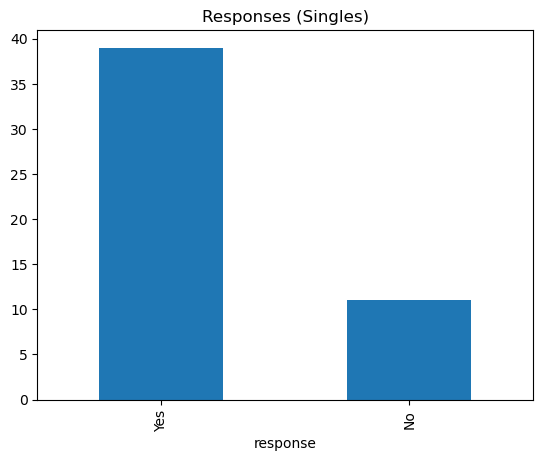

In [32]:
extract_and_analyze_results(singles, "Singles")


################# Analyzing results for Families... #################
Extraction raw result message: {'content': '{"response": "No", "justification": "While I appreciate the focus on luxury and relaxation, my priorities lean more towards family-friendly experiences that cater to my children\'s interests. I prefer vacations that allow us to explore and bond as a family rather than just seeking quiet luxury."}', 'refusal': None, 'role': 'assistant'}
Extraction raw result message: {'content': '{"response": "No", "justification": "While I appreciate the focus on luxury and relaxation, my family vacations are usually centered around family-friendly activities and experiences that cater to my children. I prefer destinations that offer a mix of adventure and fun for the whole family rather than just quiet luxury."}', 'refusal': None, 'role': 'assistant'}
Extraction raw result message: {'content': '{"response": "Yes", "justification": "I would likely use it for this vacation because it aligns 

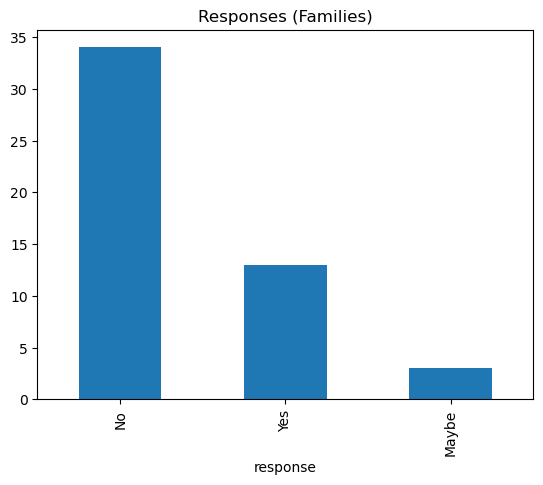

In [33]:
extract_and_analyze_results(families, "Families")

################# Analyzing results for Couples... #################
Extraction raw result message: {'content': '{"response": "Yes", "justification": "I value the focus on luxury and relaxation, which is exactly what I look for in a vacation. I appreciate the idea of avoiding fake reviews and bad experiences, as I want my getaway to be as enjoyable and stress-free as possible. I believe that a well-planned luxury vacation would enhance my experience and allow me to fully unwind."}', 'refusal': None, 'role': 'assistant'}
Extraction raw result message: {'content': '{"response": "Yes", "justification": "I appreciate the focus on luxury and relaxation, which aligns with my ideal vacation. However, I also enjoy adventure and spontaneity, so I would hope that the service could accommodate those aspects as well. Overall, I think it would be a great way to ensure a quality experience without the hassle of planning everything myself."}', 'refusal': None, 'role': 'assistant'}
Extraction raw resu

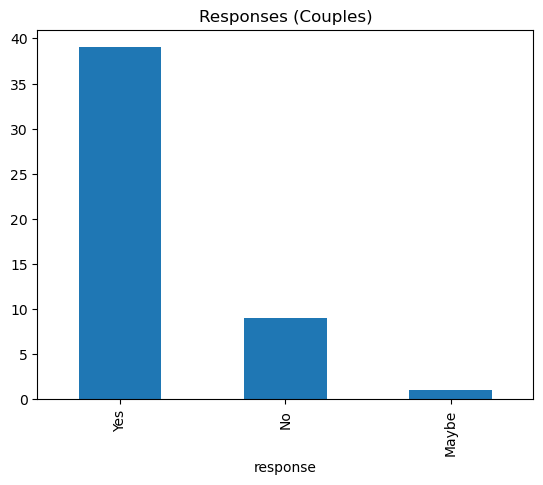

In [34]:
extract_and_analyze_results(couple, "Couples")

In [35]:
#extract_and_analyze_results(nongenuine_couples, "Non-genuine couples")

In [ ]:
control.end()